In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the data
file_path = "SPY_section_3.csv"
df = pd.read_csv(file_path)

In [4]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
# Define LSTM model
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [6]:
# Define the target variable
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)
df = df.dropna()

In [7]:
# Adding SMA and EMA to the feature
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean() # Short-term SMA
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean() # Medium-term SMA
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean() # Long-term SMA

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [8]:
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]

train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(X_scaled.shape)

Train: 1768, Val: 379, Test: 370
(2527, 11)


In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<span style="color: yellow; font-size: 40px;">Evaluating original LSTM</span>

In [10]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30

<ipython-input-11-2c00870e8411>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
/u


===== Evaluation Results =====
Test Loss: 1275.9279
Test MAE: 30.6079
Average Error Percentage: 10.94%
Largest Error Percentage: 23.87%


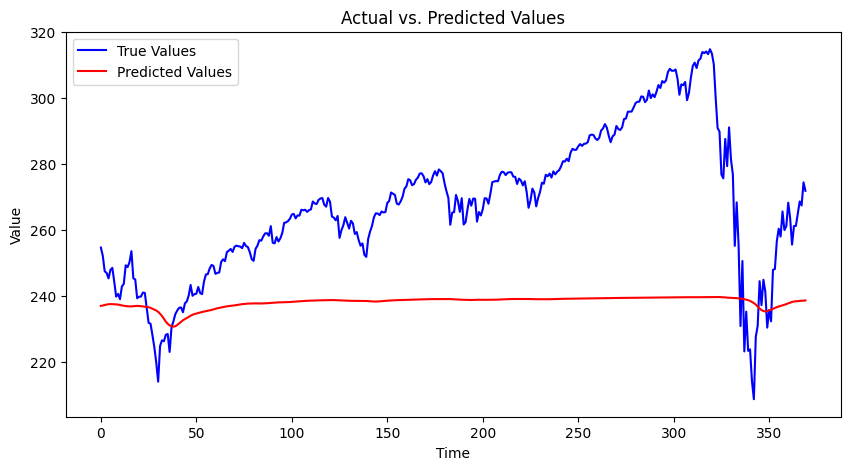

In [11]:
# Define paths
# LSTM_model_path = "./lstm_codes/lstm_models/lstm_section_3.pth"
LSTM_model_path = "lstm_section_3.pth"

# Load the trained model
LSTM_model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
LSTM_model.eval()

# Define loss function
criterion = torch.nn.MSELoss()

# Evaluate on test data
test_loss = 0.0
test_mae = 0.0
all_true = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = LSTM_model(X_batch)
        loss = criterion(outputs, y_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))

        test_loss += loss.item() * X_batch.size(0)
        test_mae += mae.item() * X_batch.size(0)

        all_true.extend(y_batch.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Compute final metrics
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

# Compute error percentages
all_true = np.array(all_true).flatten()
all_preds = np.array(all_preds).flatten()
error = np.abs(all_true - all_preds) / (np.abs(all_true) + 1e-8)
avg_error = np.mean(error) * 100
largest_error = np.max(error) * 100

# Print results
print("\n===== Evaluation Results =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Average Error Percentage: {avg_error:.2f}%")
print(f"Largest Error Percentage: {largest_error:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(all_true, label='True Values', color='blue')
plt.plot(all_preds, label='Predicted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


<span style="color: yellow; font-size: 40px;">Evaluating original autoencoder</span>

In [12]:
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

In [13]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [14]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [15]:
input_dim = X_train.shape[1]

# Hyperparameters
encoding_dim = 5
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 750
batch_size = 16
patience = 40

In [16]:
# autoencoder_model_path = "./autoencoder_codes/autoencoder_models/autoencoder_section_3.pth"
autoencoder_model_path = "autoencoder_section_3.pth"
autoencoder_model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate).to(device)
autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.device('cpu')))

<ipython-input-16-995c16865297>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.devi

<All keys matched successfully>

In [17]:
autoencoder_model.eval()
with torch.no_grad():
    reconstructed_test = autoencoder_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
mse = np.mean((X_test - reconstructed_test) ** 2)
mae = np.mean(np.abs(X_test - reconstructed_test))
ree = np.mean(np.linalg.norm(X_test - reconstructed_test, axis=1) / np.linalg.norm(X_test, axis=1))
euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
average_error = np.mean(reconstruction_error_percentage)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, REE: {ree:.4f}, Euclidean Distance: {euclidean_dist:.4f}, Average Error: {average_error:.4f}%')

MSE: 0.0052, MAE: 0.0563, REE: 0.0482, Euclidean Distance: 0.2232, Average Error: 38.4449%


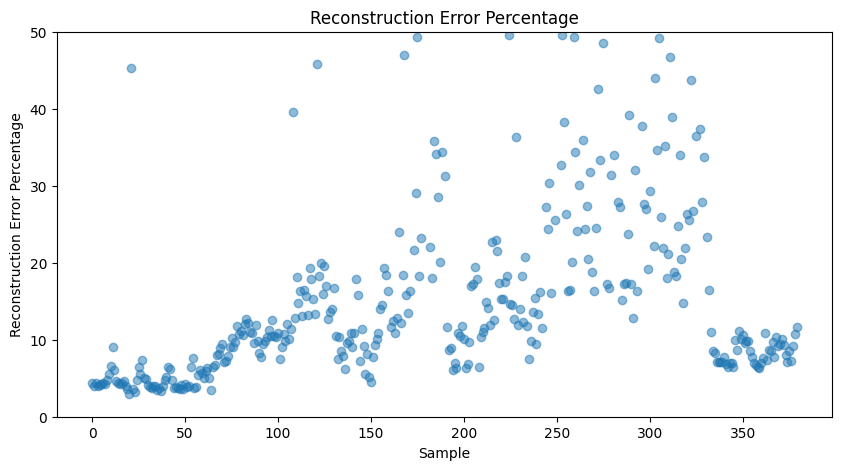

In [18]:
# Scatter plot of reconstruction error percentage
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, alpha=0.5)
plt.ylim(0, 50)
plt.xlabel('Sample')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage')
plt.show()


<span style="color: yellow; font-size: 40px;">Bias correction model - single input</span>

In [19]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size1, dropout_rate):
#         super(BiasPredictor, self).__init__()

#         hidden_size2 = hidden_size1 // 2
#         hidden_size3 = hidden_size2 // 2
#         hidden_size4 = hidden_size3 // 2  # New additional layer

#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, hidden_size4)  # New additional layer
#         self.dropout4 = nn.Dropout(dropout_rate)

#         self.fc5 = nn.Linear(hidden_size4, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         x = F.relu(self.fc4(x))  # New layer
#         x = self.dropout4(x)

#         return self.fc5(x)

##################################################################

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size, dropout_rate):
#         super(BiasPredictor, self).__init__()

#         # Calculate progressively halved hidden sizes
#         hidden_size2 = hidden_size // 2
#         hidden_size3 = hidden_size2 // 2

#         # Define layers
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_size, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         return self.fc4(x)  # Output layer without activation

##################################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(BiasPredictor, self).__init__()

        # Calculate progressively halved hidden sizes
        hidden_size2 = hidden_size // 2

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, 1)  # Final output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return self.fc3(x)  # Output layer without activation




In [20]:
# Get LSTM predictions of entire dataset
with torch.no_grad():
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
    LSTM_preds = LSTM_model(X_tensor).cpu().numpy()

# Put LSTM predictions into a new DataFrame
new_df = pd.DataFrame(LSTM_preds, columns=["LSTM_Pred"])


In [21]:
# Drop the first sequence_length rows
temp_y = y
temp_y = temp_y[sequence_length:]

# add the target variable to the new DataFrame
new_df["Target"] = temp_y.values

In [22]:
# Get reconstruction error percentage for the entire dataset
autoencoder_model.eval()
with torch.no_grad():
    reconstructed = autoencoder_model(torch.tensor(X_scaled.values, dtype=torch.float32).to(device)).cpu().numpy()

# Compute the MAE
reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed), axis=1)

# Compute the reconstruction error percentage
# reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed) / (np.abs(X_scaled.values) + 1e-8), axis=1) * 100
# reconstruction_error = np.mean((X_scaled.values - reconstructed) / ((X_scaled.values) + 1e-8), axis=1) * 100

# Drop the first sequence_length rows
reconstruction_error_new = reconstruction_error[sequence_length:]

# Add the reconstruction error to the new DataFrame
new_df["Reconstruction_error_single"] = reconstruction_error_new

# Get reconstruction error arr of past 10 days
reconstruction_error_arr = []
for i in range(sequence_length, len(reconstruction_error)):
    reconstruction_error_arr.append(reconstruction_error[i - sequence_length:i])


# Add the reconstruction error array to the new DataFrame
new_df["Reconstruction_error_arr"] = reconstruction_error_arr



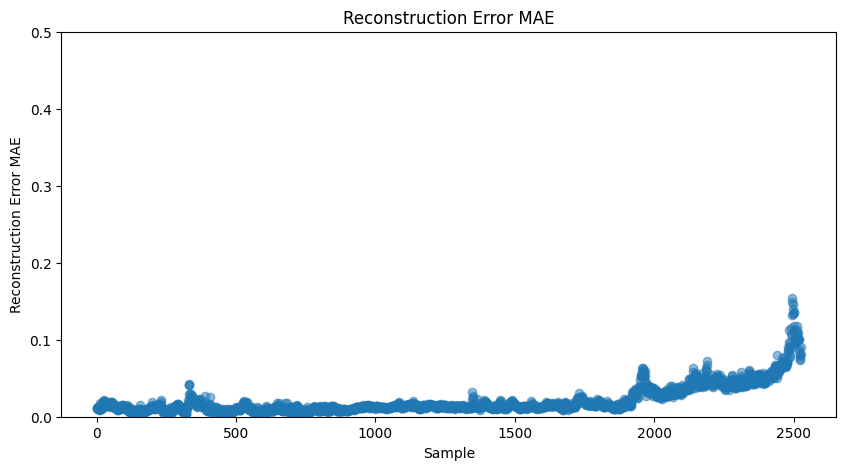

In [23]:
# plot reconstruction error scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, alpha=0.5)
plt.ylim(0, 0.5)
plt.xlabel('Sample')
# plt.ylabel('Reconstruction Error Percentage')
# plt.title('Reconstruction Error Percentage')
plt.ylabel('Reconstruction Error MAE')
plt.title('Reconstruction Error MAE')
plt.show()


In [24]:
reconstruction_error_arr[0]

array([0.01112294, 0.01061798, 0.01121775, 0.01175785, 0.01235988,
       0.01201897, 0.01181609, 0.00948298, 0.00851219, 0.0115408 ])

In [25]:
# Calculate the difference between the target and LSTM prediction
new_df["Bias"] = new_df["Target"] - new_df["LSTM_Pred"]

In [26]:
y = new_df["Bias"]
X = new_df["Reconstruction_error_single"]
# X = new_df["Reconstruction_error_arr"]

In [27]:
# Sequential split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]
X_val_raw = X[train_size:train_size + val_size]
y_val_raw = y[train_size:train_size + val_size]
X_test_raw = X[train_size + val_size:]
y_test_raw = y[train_size + val_size:]

# Scale using StandardScaler (fit only on train data)
# X_scaler = StandardScaler()
X_scaler = RobustScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw.values.reshape(-1, 1))
X_val_scaled = X_scaler.transform(X_val_raw.values.reshape(-1, 1))
X_test_scaled = X_scaler.transform(X_test_raw.values.reshape(-1, 1))

# y_scaler = StandardScaler()
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val_raw.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test_raw.values.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Print sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1761, Val: 377, Test: 379


In [28]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Define model
# input_size = 1
# hidden_size1 = 64
# dropout_rate = 0.1
# learning_rate = 0.0001
# num_epochs = 500
# patience = 30

# bias_model = BiasPredictor(input_size=input_size, hidden_size1=hidden_size1, dropout_rate=dropout_rate).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

# # Train the model (don't need to save the model yet)
# best_val_loss = np.inf
# best_epoch = 0

# for epoch in range(num_epochs):
#     bias_model.train()
#     train_loss = 0.0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         outputs = bias_model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * X_batch.size(0)

#     train_loss /= len(train_loader.dataset)

#     bias_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             outputs = bias_model(X_batch)
#             loss = criterion(outputs, y_batch)
#             val_loss += loss.item() * X_batch.size(0)

#     val_loss /= len(val_loader.dataset)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch
#     elif epoch - best_epoch >= patience:
#         print(f"Stopping early at epoch {epoch}")
#         break

#     print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameter search space
hidden_sizes = [16, 32, 64, 128]
dropout_rates = [0.0, 0.1, 0.2]
learning_rates = [0.0001, 0.0005, 0.001]
batch_sizes = [8, 16, 32]

# Total number of hyperparameter combinations
total_combinations = len(hidden_sizes) * len(dropout_rates) * len(learning_rates) * len(batch_sizes)
combination_counter = 0

# Store results
results = []

# Iterate over all hyperparameter combinations
for hidden_size, dropout_rate, learning_rate, batch_size in itertools.product(hidden_sizes, dropout_rates, learning_rates, batch_sizes):
    combination_counter += 1
    print(f"\n Running {combination_counter}/{total_combinations}: H={hidden_size}, D={dropout_rate}, LR={learning_rate}, B={batch_size}")

    val_losses = []
    accuracies = []  # To track accuracies for each run
    for run in range(5):  # Run each combination 5 times
        print(f"   Run {run + 1}/5 ...", end=" ", flush=True)

        # Define DataLoaders with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define the model
        bias_model = BiasPredictor(input_size=1, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

        # Training setup
        best_val_loss = np.inf
        best_epoch = 0
        patience = 20
        num_epochs = 500

        # Training loop
        for epoch in range(num_epochs):
            bias_model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = bias_model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * X_batch.size(0)

            train_loss /= len(train_loader.dataset)

            # Validation
            bias_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = bias_model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item() * X_batch.size(0)

            val_loss /= len(val_loader.dataset)

            # Print progress every 50 epochs
            if epoch % 5 == 0:
                print(f"     Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
            elif epoch - best_epoch >= patience:
                print(f"    ⏹️ Early stopping at epoch {epoch}")
                break  # Stop training if no improvement

        val_losses.append(best_val_loss)  # Store best val loss for this run
        print(f" Run {run + 1} finished with best val loss: {best_val_loss:.4f}")

        # Evaluate accuracy after each run
        combined_X = torch.cat((X_train, X_val, X_test), dim=0)
        combined_y = torch.cat((y_train, y_val, y_test), dim=0)

        # Convert combined_X to tensor and scale if necessary
        X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
        bias_model.eval()
        with torch.no_grad():
            y_pred = bias_model(X_scaled_tensor.to(device)).cpu().numpy()

        # Unscale outputs
        outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))

        # Calculate error percentages
        new_df["Bias_Pred"] = outputs_unscaled
        new_df["Corrected_LSTM_Pred"] = new_df["LSTM_Pred"] + new_df["Bias_Pred"]

        original_error_percent_test = np.mean(np.abs(new_df["Bias"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100
        corrected_error_percent_test = np.mean(np.abs(new_df["Target"].iloc[train_size + val_size:] - new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100

        print(f"Original Error Percentage (Test Dataset): {original_error_percent_test:.4f}%")
        print(f"Corrected Error Percentage (Test Dataset): {corrected_error_percent_test:.4f}%")

        # Store accuracy for this run
        accuracies.append(corrected_error_percent_test)

    # After all 5 trials, calculate the average accuracy
    avg_val_loss = np.mean(val_losses)
    avg_accuracy = np.mean(accuracies)  # Calculate the average error percentage over all runs

    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "avg_val_loss": avg_val_loss,
        "avg_accuracy": avg_accuracy
    })

    print(f" Finished configuration H={hidden_size}, D={dropout_rate}, LR={learning_rate}, B={batch_size} → Avg Val Loss: {avg_val_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}%")

# Sort results by lowest validation loss
results.sort(key=lambda x: x["avg_val_loss"])

# Print top 5 configurations
print("\n Top 5 Hyperparameter Configurations:")
for i, res in enumerate(results[:5]):
    print(f" {i+1}. {res}")




 Running 1/108: H=16, D=0.0, LR=0.0001, B=8
   Run 1/5 ...      Epoch 0: Train Loss = 0.6549, Val Loss = 10.5460
     Epoch 5: Train Loss = 0.6152, Val Loss = 11.6691
     Epoch 10: Train Loss = 0.6054, Val Loss = 12.3533
     Epoch 15: Train Loss = 0.6024, Val Loss = 12.7447
     Epoch 20: Train Loss = 0.6012, Val Loss = 12.9594
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.5460
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0168%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6213, Val Loss = 9.9103
     Epoch 5: Train Loss = 0.6097, Val Loss = 10.8944
     Epoch 10: Train Loss = 0.6038, Val Loss = 11.7581
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.2995
     Epoch 20: Train Loss = 0.6003, Val Loss = 12.6149
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.9103
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8309%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6679, Val Loss = 10.6414
     Epoch 5: Train Loss = 0.6098, Val Loss = 10.6962
     Epoch 10: Train Loss = 0.6045, Val Loss = 11.0764
     Epoch 15: Train Loss = 0.6022, Val Loss = 11.4266
     Epoch 20: Train Loss = 0.6013, Val Loss = 11.6811
    ⏹️ Early stopping at epoch 22
 Run 3 finished with best val loss: 10.6057
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5123%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6527, Val Loss = 11.7494
     Epoch 5: Train Loss = 0.6147, Val Loss = 12.5954
     Epoch 10: Train Loss = 0.6051, Val Loss = 13.4029
     Epoch 15: Train Loss = 0.6022, Val Loss = 13.7917
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.8959
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.7494
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3002%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6403, Val Loss = 12.1296
     Epoch 5: Train Loss = 0.6114, Val Loss = 12.4341
     Epoch 10: Train Loss = 0.6035, Val Loss = 13.0691
     Epoch 15: Train Loss = 0.6016, Val Loss = 13.4189
     Epoch 20: Train Loss = 0.6006, Val Loss = 13.7048
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 12.1193
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2359%
 Finished configuration H=16, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 10.9862, Avg Accuracy: 10.9792%

 Running 2/108: H=16, D=0.0, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6606, Val Loss = 10.6166


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6188, Val Loss = 10.6670
     Epoch 10: Train Loss = 0.6083, Val Loss = 10.9028
     Epoch 15: Train Loss = 0.6041, Val Loss = 11.2171
     Epoch 20: Train Loss = 0.6026, Val Loss = 11.4142
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 10.5903
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.4304%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7586, Val Loss = 13.0543


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6312, Val Loss = 12.4203
     Epoch 10: Train Loss = 0.6082, Val Loss = 12.5323
     Epoch 15: Train Loss = 0.6039, Val Loss = 12.7509
     Epoch 20: Train Loss = 0.6022, Val Loss = 12.9389
     Epoch 25: Train Loss = 0.6014, Val Loss = 13.0173
    ⏹️ Early stopping at epoch 26
 Run 2 finished with best val loss: 12.4158
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9892%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8892, Val Loss = 7.6395
     Epoch 5: Train Loss = 0.7025, Val Loss = 9.7476
     Epoch 10: Train Loss = 0.6284, Val Loss = 12.7442
     Epoch 15: Train Loss = 0.6131, Val Loss = 14.0522
     Epoch 20: Train Loss = 0.6079, Val Loss = 14.5196
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.6395
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.4815%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6109, Val Loss = 10.5911


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6040, Val Loss = 11.0921
     Epoch 10: Train Loss = 0.6025, Val Loss = 11.4144
     Epoch 15: Train Loss = 0.6020, Val Loss = 11.6401
     Epoch 20: Train Loss = 0.6017, Val Loss = 11.8112
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.5911
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5528%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6333, Val Loss = 10.0898


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6072, Val Loss = 11.3936
     Epoch 10: Train Loss = 0.6025, Val Loss = 12.0075
     Epoch 15: Train Loss = 0.6013, Val Loss = 12.2682
     Epoch 20: Train Loss = 0.6010, Val Loss = 12.4022
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.0898
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7338%
 Finished configuration H=16, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 10.2653, Avg Accuracy: 10.8375%

 Running 3/108: H=16, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6080, Val Loss = 11.6538


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6038, Val Loss = 12.1070
     Epoch 10: Train Loss = 0.6017, Val Loss = 12.5206
     Epoch 15: Train Loss = 0.6010, Val Loss = 12.8060
     Epoch 20: Train Loss = 0.6007, Val Loss = 12.9240
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.6538
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9395%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7410, Val Loss = 11.6401


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6686, Val Loss = 11.5671
     Epoch 10: Train Loss = 0.6344, Val Loss = 11.5950
     Epoch 15: Train Loss = 0.6197, Val Loss = 11.6986
     Epoch 20: Train Loss = 0.6123, Val Loss = 11.8545
     Epoch 25: Train Loss = 0.6081, Val Loss = 12.0147
    ⏹️ Early stopping at epoch 26
 Run 2 finished with best val loss: 11.5445
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5985%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6414, Val Loss = 10.6754
     Epoch 5: Train Loss = 0.6235, Val Loss = 10.9170
     Epoch 10: Train Loss = 0.6161, Val Loss = 11.2501
     Epoch 15: Train Loss = 0.6121, Val Loss = 11.6056
     Epoch 20: Train Loss = 0.6092, Val Loss = 11.8022
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.6754
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6413%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6456, Val Loss = 8.4038


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6308, Val Loss = 8.9393
     Epoch 10: Train Loss = 0.6208, Val Loss = 9.3803
     Epoch 15: Train Loss = 0.6141, Val Loss = 9.7758
     Epoch 20: Train Loss = 0.6107, Val Loss = 10.0873
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.4038
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 9.9580%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7624, Val Loss = 8.9649


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6731, Val Loss = 9.3921
     Epoch 10: Train Loss = 0.6408, Val Loss = 10.0095
     Epoch 15: Train Loss = 0.6231, Val Loss = 10.6715
     Epoch 20: Train Loss = 0.6123, Val Loss = 11.2795
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.9649
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.4085%
 Finished configuration H=16, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 10.2485, Avg Accuracy: 10.5091%

 Running 4/108: H=16, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6418, Val Loss = 14.2081
     Epoch 5: Train Loss = 0.6023, Val Loss = 14.2478
     Epoch 10: Train Loss = 0.6019, Val Loss = 13.7109
     Epoch 15: Train Loss = 0.6014, Val Loss = 13.3992
     Epoch 20: Train Loss = 0.6016, Val Loss = 13.4791
     Epoch 25: Train Loss = 0.6017, Val Loss = 13.6860
     Epoch 30: Train Loss = 0.6012, Val Loss = 13.6394
     Epoch 35: Train Loss = 0.6016, Val Loss = 13.1648
     Epoch 40: Train Loss = 0.6012, Val Loss = 13.2774
     Epoch 45: Train Loss = 0.6015, Val Loss = 13.4550
     Epoch 50: Train Loss = 0.6010, Val Loss = 13.6014
     Epoch 55: Train Loss = 0.6011, Val Loss = 13.3386
     Epoch 60: Train Loss = 0.6007, Val Loss = 12.8205
    ⏹️ Early stopping at epoch 64
 Run 1 finished with best val loss: 12.7723
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0139%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6161, Val Loss = 11.3073
     Epoch 5: Train Loss = 0.6015, Val Loss = 12.0441
     Epoch 10: Train Loss = 0.6011, Val Loss = 12.2532
     Epoch 15: Train Loss = 0.6009, Val Loss = 12.2470
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.4242
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3073
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7679%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6233, Val Loss = 11.8835
     Epoch 5: Train Loss = 0.6017, Val Loss = 12.7370
     Epoch 10: Train Loss = 0.6008, Val Loss = 12.9378
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.1506
     Epoch 20: Train Loss = 0.6002, Val Loss = 13.1367
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.8835
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0463%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6098, Val Loss = 9.4455
     Epoch 5: Train Loss = 0.6023, Val Loss = 10.9745
     Epoch 10: Train Loss = 0.6006, Val Loss = 12.1300
     Epoch 15: Train Loss = 0.6009, Val Loss = 12.2561
     Epoch 20: Train Loss = 0.6007, Val Loss = 12.3826
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.4455
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6785%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6157, Val Loss = 12.0763
     Epoch 5: Train Loss = 0.6008, Val Loss = 13.0884
     Epoch 10: Train Loss = 0.6002, Val Loss = 12.9682
     Epoch 15: Train Loss = 0.5999, Val Loss = 13.0687
     Epoch 20: Train Loss = 0.6001, Val Loss = 13.1517
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.0763
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0221%
 Finished configuration H=16, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 11.4970, Avg Accuracy: 10.9057%

 Running 5/108: H=16, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6290, Val Loss = 9.9608


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6015, Val Loss = 11.9448
     Epoch 10: Train Loss = 0.6008, Val Loss = 12.3751
     Epoch 15: Train Loss = 0.6009, Val Loss = 12.5291
     Epoch 20: Train Loss = 0.6003, Val Loss = 12.7566
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.9608
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8234%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6043, Val Loss = 13.1614


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6007, Val Loss = 12.9805
     Epoch 10: Train Loss = 0.6008, Val Loss = 12.6807
     Epoch 15: Train Loss = 0.6010, Val Loss = 12.5651
     Epoch 20: Train Loss = 0.6006, Val Loss = 12.5935
     Epoch 25: Train Loss = 0.6004, Val Loss = 12.6617
     Epoch 30: Train Loss = 0.6001, Val Loss = 12.5992
     Epoch 35: Train Loss = 0.6003, Val Loss = 12.7410
     Epoch 40: Train Loss = 0.6004, Val Loss = 12.6855
     Epoch 45: Train Loss = 0.5998, Val Loss = 12.5391
     Epoch 50: Train Loss = 0.5999, Val Loss = 12.5843
     Epoch 55: Train Loss = 0.5998, Val Loss = 13.1210
     Epoch 60: Train Loss = 0.5995, Val Loss = 12.6290
     Epoch 65: Train Loss = 0.5994, Val Loss = 12.8032
    ⏹️ Early stopping at epoch 68
 Run 2 finished with best val loss: 12.3317
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8868%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6188, Val Loss = 11.5181


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6016, Val Loss = 12.9620
     Epoch 10: Train Loss = 0.6020, Val Loss = 13.2545
     Epoch 15: Train Loss = 0.6013, Val Loss = 13.6804
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.5065
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.5181
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1672%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6201, Val Loss = 11.3405
     Epoch 5: Train Loss = 0.6057, Val Loss = 13.1519
     Epoch 10: Train Loss = 0.6038, Val Loss = 13.4067
     Epoch 15: Train Loss = 0.6030, Val Loss = 13.2345
     Epoch 20: Train Loss = 0.6027, Val Loss = 13.3000
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.3405
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0714%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6392, Val Loss = 10.4357


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6014, Val Loss = 12.7225
     Epoch 10: Train Loss = 0.6010, Val Loss = 12.7203
     Epoch 15: Train Loss = 0.6006, Val Loss = 12.6966
     Epoch 20: Train Loss = 0.6009, Val Loss = 12.5867
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.4357
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8072%
 Finished configuration H=16, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 11.1173, Avg Accuracy: 10.9512%

 Running 6/108: H=16, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7126, Val Loss = 10.7948


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6121, Val Loss = 14.0489
     Epoch 10: Train Loss = 0.6035, Val Loss = 14.8821
     Epoch 15: Train Loss = 0.6025, Val Loss = 14.7647
     Epoch 20: Train Loss = 0.6021, Val Loss = 14.4819
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.7948
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.5522%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8414, Val Loss = 14.6474


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6141, Val Loss = 12.7670
     Epoch 10: Train Loss = 0.6021, Val Loss = 13.1228
     Epoch 15: Train Loss = 0.6013, Val Loss = 13.3134
     Epoch 20: Train Loss = 0.6008, Val Loss = 13.1759
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 12.6246
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9950%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6246, Val Loss = 9.1775


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6060, Val Loss = 10.2008
     Epoch 10: Train Loss = 0.6026, Val Loss = 10.9012
     Epoch 15: Train Loss = 0.6018, Val Loss = 11.5237
     Epoch 20: Train Loss = 0.6013, Val Loss = 11.6671
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.1775
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.4367%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7178, Val Loss = 9.6855


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6052, Val Loss = 13.1671
     Epoch 10: Train Loss = 0.6010, Val Loss = 13.8975
     Epoch 15: Train Loss = 0.6007, Val Loss = 14.1160
     Epoch 20: Train Loss = 0.6001, Val Loss = 13.6712
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.6855
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1964%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6643, Val Loss = 11.9968


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6173, Val Loss = 12.3852
     Epoch 10: Train Loss = 0.6118, Val Loss = 13.0694
     Epoch 15: Train Loss = 0.6090, Val Loss = 13.7962
     Epoch 20: Train Loss = 0.6068, Val Loss = 13.6973
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 11.9852
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2403%
 Finished configuration H=16, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 10.8535, Avg Accuracy: 11.0841%

 Running 7/108: H=16, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6653, Val Loss = 12.2401
     Epoch 5: Train Loss = 0.6017, Val Loss = 13.6320
     Epoch 10: Train Loss = 0.6027, Val Loss = 13.8212
     Epoch 15: Train Loss = 0.6018, Val Loss = 13.6443
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.8845
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.2401
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3173%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6120, Val Loss = 10.6652
     Epoch 5: Train Loss = 0.6020, Val Loss = 12.1429
     Epoch 10: Train Loss = 0.6008, Val Loss = 12.3112
     Epoch 15: Train Loss = 0.6008, Val Loss = 12.8498
     Epoch 20: Train Loss = 0.6014, Val Loss = 12.7001
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.6652
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8635%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6062, Val Loss = 13.4242
     Epoch 5: Train Loss = 0.6021, Val Loss = 13.7610
     Epoch 10: Train Loss = 0.6014, Val Loss = 13.5293
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.2149
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.0519
     Epoch 25: Train Loss = 0.6007, Val Loss = 13.0832
     Epoch 30: Train Loss = 0.6008, Val Loss = 13.1803
     Epoch 35: Train Loss = 0.6005, Val Loss = 13.0606
     Epoch 40: Train Loss = 0.5991, Val Loss = 12.6704
     Epoch 45: Train Loss = 0.6002, Val Loss = 12.9542
     Epoch 50: Train Loss = 0.5994, Val Loss = 12.8830
     Epoch 55: Train Loss = 0.5991, Val Loss = 12.7606
     Epoch 60: Train Loss = 0.5986, Val Loss = 12.6971
     Epoch 65: Train Loss = 0.5992, Val Loss = 12.7225
     Epoch 70: Train Loss = 0.5988, Val Loss = 12.6830
     Epoch 75: Train Loss = 0.5990, Val Loss = 12.7471
    ⏹️ Early stopping at epoch 77
 Run 3 finished with best val loss: 12.2255
Original Error Percentage (Test Dataset): 10

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6517, Val Loss = 14.7383
     Epoch 5: Train Loss = 0.6021, Val Loss = 13.4565
     Epoch 10: Train Loss = 0.6019, Val Loss = 13.7586
     Epoch 15: Train Loss = 0.6018, Val Loss = 13.1020
     Epoch 20: Train Loss = 0.6025, Val Loss = 12.9580
     Epoch 25: Train Loss = 0.6028, Val Loss = 13.2037
     Epoch 30: Train Loss = 0.6008, Val Loss = 12.7806
     Epoch 35: Train Loss = 0.6016, Val Loss = 12.7068
     Epoch 40: Train Loss = 0.6004, Val Loss = 12.6124
     Epoch 45: Train Loss = 0.6013, Val Loss = 12.4835
     Epoch 50: Train Loss = 0.6004, Val Loss = 12.8383
     Epoch 55: Train Loss = 0.6006, Val Loss = 12.5294
     Epoch 60: Train Loss = 0.6000, Val Loss = 12.6670
     Epoch 65: Train Loss = 0.5998, Val Loss = 12.2409
     Epoch 70: Train Loss = 0.5993, Val Loss = 12.6244
    ⏹️ Early stopping at epoch 73
 Run 4 finished with best val loss: 12.0651
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.60

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6212, Val Loss = 14.2195
     Epoch 5: Train Loss = 0.6014, Val Loss = 14.0582
     Epoch 10: Train Loss = 0.6013, Val Loss = 13.8005
     Epoch 15: Train Loss = 0.6004, Val Loss = 13.3891
     Epoch 20: Train Loss = 0.5997, Val Loss = 13.3241
     Epoch 25: Train Loss = 0.6010, Val Loss = 13.4540
     Epoch 30: Train Loss = 0.6003, Val Loss = 13.3529
     Epoch 35: Train Loss = 0.6004, Val Loss = 13.1575
     Epoch 40: Train Loss = 0.6004, Val Loss = 13.3299
     Epoch 45: Train Loss = 0.5995, Val Loss = 13.2416
     Epoch 50: Train Loss = 0.5992, Val Loss = 12.9650
     Epoch 55: Train Loss = 0.5985, Val Loss = 12.8590
     Epoch 60: Train Loss = 0.5992, Val Loss = 12.5178
     Epoch 65: Train Loss = 0.5991, Val Loss = 12.5059
     Epoch 70: Train Loss = 0.5981, Val Loss = 12.5531
     Epoch 75: Train Loss = 0.5984, Val Loss = 12.4832
     Epoch 80: Train Loss = 0.5978, Val Loss = 12.6047
     Epoch 85: Train Loss = 0.5981, Val Loss = 12.5092
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 12.9063
     Epoch 10: Train Loss = 0.6011, Val Loss = 12.9684
     Epoch 15: Train Loss = 0.6010, Val Loss = 12.8100
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.6477
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.2371
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8206%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6142, Val Loss = 12.2388


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6020, Val Loss = 12.8169
     Epoch 10: Train Loss = 0.6012, Val Loss = 12.9326
     Epoch 15: Train Loss = 0.6021, Val Loss = 13.1219
     Epoch 20: Train Loss = 0.6009, Val Loss = 12.9144
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 12.1724
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9340%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6185, Val Loss = 12.4802
     Epoch 5: Train Loss = 0.6021, Val Loss = 13.1289
     Epoch 10: Train Loss = 0.5990, Val Loss = 13.4548
     Epoch 15: Train Loss = 0.5991, Val Loss = 13.0035
     Epoch 20: Train Loss = 0.5995, Val Loss = 12.2506
     Epoch 25: Train Loss = 0.5986, Val Loss = 12.8254
     Epoch 30: Train Loss = 0.5986, Val Loss = 12.9319
     Epoch 35: Train Loss = 0.5984, Val Loss = 12.5691
    ⏹️ Early stopping at epoch 39
 Run 3 finished with best val loss: 11.8640
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7984%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6368, Val Loss = 13.3539


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6016, Val Loss = 13.4726
     Epoch 10: Train Loss = 0.6050, Val Loss = 13.2049
     Epoch 15: Train Loss = 0.6011, Val Loss = 13.4478
     Epoch 20: Train Loss = 0.6022, Val Loss = 12.6967
     Epoch 25: Train Loss = 0.6006, Val Loss = 13.2623
     Epoch 30: Train Loss = 0.6004, Val Loss = 13.0817
     Epoch 35: Train Loss = 0.6012, Val Loss = 12.8191
     Epoch 40: Train Loss = 0.6017, Val Loss = 12.5169
     Epoch 45: Train Loss = 0.6005, Val Loss = 13.1232
     Epoch 50: Train Loss = 0.6018, Val Loss = 12.5078
     Epoch 55: Train Loss = 0.6002, Val Loss = 13.1264
     Epoch 60: Train Loss = 0.5998, Val Loss = 13.0597
     Epoch 65: Train Loss = 0.6003, Val Loss = 12.6675
     Epoch 70: Train Loss = 0.5995, Val Loss = 12.8904
     Epoch 75: Train Loss = 0.5995, Val Loss = 12.6920
     Epoch 80: Train Loss = 0.5994, Val Loss = 12.7812
     Epoch 85: Train Loss = 0.5985, Val Loss = 12.7100
     Epoch 90: Train Loss = 0.5984, Val Loss = 12.7818
     Epoch 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6016, Val Loss = 13.3191
     Epoch 10: Train Loss = 0.6019, Val Loss = 13.2016
     Epoch 15: Train Loss = 0.6013, Val Loss = 12.8907
     Epoch 20: Train Loss = 0.6012, Val Loss = 12.7728
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.2887
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8491%
 Finished configuration H=16, D=0.0, LR=0.001, B=16 → Avg Val Loss: 11.9713, Avg Accuracy: 10.8309%

 Running 9/108: H=16, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6873, Val Loss = 11.4241


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6019, Val Loss = 13.4975
     Epoch 10: Train Loss = 0.6013, Val Loss = 13.2770
     Epoch 15: Train Loss = 0.6013, Val Loss = 13.1550
     Epoch 20: Train Loss = 0.6029, Val Loss = 13.1406
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.4241
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0707%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6959, Val Loss = 11.0481


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6020, Val Loss = 13.7961
     Epoch 10: Train Loss = 0.6024, Val Loss = 13.8665
     Epoch 15: Train Loss = 0.6018, Val Loss = 13.7706
     Epoch 20: Train Loss = 0.6016, Val Loss = 13.6846
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.0481
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2808%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6373, Val Loss = 10.8792


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6018, Val Loss = 12.2345
     Epoch 10: Train Loss = 0.6014, Val Loss = 13.0853
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.7565
     Epoch 20: Train Loss = 0.6013, Val Loss = 12.7863
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.8792
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9004%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6182, Val Loss = 10.6718


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6038, Val Loss = 10.7511
     Epoch 10: Train Loss = 0.6030, Val Loss = 10.8075
     Epoch 15: Train Loss = 0.6034, Val Loss = 10.8433
     Epoch 20: Train Loss = 0.6023, Val Loss = 10.8693
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.6718
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.1866%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6547, Val Loss = 11.8166


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 13.5975
     Epoch 10: Train Loss = 0.6012, Val Loss = 13.5507
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.1059
     Epoch 20: Train Loss = 0.6009, Val Loss = 13.4778
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.8166
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1335%
 Finished configuration H=16, D=0.0, LR=0.001, B=32 → Avg Val Loss: 11.1680, Avg Accuracy: 10.9144%

 Running 10/108: H=16, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7140, Val Loss = 10.7806
     Epoch 5: Train Loss = 0.6172, Val Loss = 13.0834
     Epoch 10: Train Loss = 0.6048, Val Loss = 13.7264
     Epoch 15: Train Loss = 0.6084, Val Loss = 13.7205
     Epoch 20: Train Loss = 0.6083, Val Loss = 13.6230
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.7806
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2197%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6265, Val Loss = 13.6367
     Epoch 5: Train Loss = 0.6137, Val Loss = 13.8308
     Epoch 10: Train Loss = 0.6026, Val Loss = 13.8021
     Epoch 15: Train Loss = 0.6103, Val Loss = 13.5621
     Epoch 20: Train Loss = 0.6067, Val Loss = 13.2806
     Epoch 25: Train Loss = 0.6078, Val Loss = 13.1942
     Epoch 30: Train Loss = 0.6053, Val Loss = 13.0855
     Epoch 35: Train Loss = 0.6051, Val Loss = 12.9499
     Epoch 40: Train Loss = 0.5981, Val Loss = 12.8508
     Epoch 45: Train Loss = 0.6027, Val Loss = 12.9579
     Epoch 50: Train Loss = 0.6028, Val Loss = 12.8091
     Epoch 55: Train Loss = 0.5993, Val Loss = 12.8478
     Epoch 60: Train Loss = 0.6081, Val Loss = 12.7529
     Epoch 65: Train Loss = 0.6050, Val Loss = 12.6244
     Epoch 70: Train Loss = 0.6011, Val Loss = 12.7104
     Epoch 75: Train Loss = 0.6021, Val Loss = 12.6682
     Epoch 80: Train Loss = 0.6006, Val Loss = 12.7771
     Epoch 85: Train Loss = 0.6015, Val Loss = 12.6850
    ⏹️ Early

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6342, Val Loss = 11.7048
     Epoch 5: Train Loss = 0.6141, Val Loss = 12.7254
     Epoch 10: Train Loss = 0.6073, Val Loss = 13.3681
     Epoch 15: Train Loss = 0.6019, Val Loss = 13.7273
     Epoch 20: Train Loss = 0.6038, Val Loss = 13.7640
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.7048
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3194%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6157, Val Loss = 10.7079
     Epoch 5: Train Loss = 0.6103, Val Loss = 11.0804
     Epoch 10: Train Loss = 0.6074, Val Loss = 11.4013
     Epoch 15: Train Loss = 0.6057, Val Loss = 11.8231
     Epoch 20: Train Loss = 0.6029, Val Loss = 12.0362
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.7079
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7141%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6825, Val Loss = 9.2542
     Epoch 5: Train Loss = 0.6166, Val Loss = 12.1236
     Epoch 10: Train Loss = 0.6038, Val Loss = 13.2638
     Epoch 15: Train Loss = 0.6055, Val Loss = 13.6950
     Epoch 20: Train Loss = 0.6069, Val Loss = 13.7771
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.2542
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2998%
 Finished configuration H=16, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 11.0144, Avg Accuracy: 11.0889%

 Running 11/108: H=16, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6195, Val Loss = 12.7915


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6198, Val Loss = 13.3723
     Epoch 10: Train Loss = 0.6125, Val Loss = 13.3383
     Epoch 15: Train Loss = 0.6103, Val Loss = 13.4897
     Epoch 20: Train Loss = 0.5985, Val Loss = 13.4451
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.7915
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1590%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6434, Val Loss = 9.2831


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6198, Val Loss = 10.6260
     Epoch 10: Train Loss = 0.6103, Val Loss = 11.4067
     Epoch 15: Train Loss = 0.6004, Val Loss = 11.7735
     Epoch 20: Train Loss = 0.6074, Val Loss = 11.9055
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.2831
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6167%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8364, Val Loss = 9.7308


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7078, Val Loss = 11.4486
     Epoch 10: Train Loss = 0.6448, Val Loss = 13.0347
     Epoch 15: Train Loss = 0.6244, Val Loss = 14.1897
     Epoch 20: Train Loss = 0.6148, Val Loss = 14.7820
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.7308
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.7847%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7603, Val Loss = 8.2081


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6429, Val Loss = 9.1080
     Epoch 10: Train Loss = 0.6208, Val Loss = 9.8209
     Epoch 15: Train Loss = 0.6141, Val Loss = 10.3374
     Epoch 20: Train Loss = 0.6079, Val Loss = 10.7505
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.2081
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.1993%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6572, Val Loss = 10.8891


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6411, Val Loss = 11.6435
     Epoch 10: Train Loss = 0.6197, Val Loss = 12.6621
     Epoch 15: Train Loss = 0.6099, Val Loss = 13.3653
     Epoch 20: Train Loss = 0.6181, Val Loss = 13.4368
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.8891
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2180%
 Finished configuration H=16, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 10.1805, Avg Accuracy: 10.9955%

 Running 12/108: H=16, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6874, Val Loss = 10.2746


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6370, Val Loss = 11.9173
     Epoch 10: Train Loss = 0.6151, Val Loss = 13.0752
     Epoch 15: Train Loss = 0.6080, Val Loss = 13.7044
     Epoch 20: Train Loss = 0.6156, Val Loss = 13.7882
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.2746
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2674%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7843, Val Loss = 13.7709


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6865, Val Loss = 12.6978
     Epoch 10: Train Loss = 0.6575, Val Loss = 12.3226
     Epoch 15: Train Loss = 0.6403, Val Loss = 12.1556
     Epoch 20: Train Loss = 0.6313, Val Loss = 12.2896
     Epoch 25: Train Loss = 0.6274, Val Loss = 12.5202
     Epoch 30: Train Loss = 0.6215, Val Loss = 12.6627
     Epoch 35: Train Loss = 0.6162, Val Loss = 12.8132
    ⏹️ Early stopping at epoch 35
 Run 2 finished with best val loss: 12.1556
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9919%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6266, Val Loss = 10.5222


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6076, Val Loss = 11.2881
     Epoch 10: Train Loss = 0.6141, Val Loss = 11.8588
     Epoch 15: Train Loss = 0.6115, Val Loss = 12.2001
     Epoch 20: Train Loss = 0.6046, Val Loss = 12.6058
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.5222
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8961%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7005, Val Loss = 7.1349


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6734, Val Loss = 7.7439
     Epoch 10: Train Loss = 0.6451, Val Loss = 8.4354
     Epoch 15: Train Loss = 0.6327, Val Loss = 9.1127
     Epoch 20: Train Loss = 0.6231, Val Loss = 9.6854
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.1349
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 9.7508%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6431, Val Loss = 13.1407


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6193, Val Loss = 14.2980
     Epoch 10: Train Loss = 0.6225, Val Loss = 14.9274
     Epoch 15: Train Loss = 0.6206, Val Loss = 15.1806
     Epoch 20: Train Loss = 0.6217, Val Loss = 15.0285
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 13.1407
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.7597%
 Finished configuration H=16, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 10.6456, Avg Accuracy: 10.9332%

 Running 13/108: H=16, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6095, Val Loss = 10.9003
     Epoch 5: Train Loss = 0.6036, Val Loss = 11.7600
     Epoch 10: Train Loss = 0.6018, Val Loss = 12.4466
     Epoch 15: Train Loss = 0.6010, Val Loss = 12.8076
     Epoch 20: Train Loss = 0.6002, Val Loss = 12.9769
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.9003
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9797%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6886, Val Loss = 9.2899
     Epoch 5: Train Loss = 0.6129, Val Loss = 13.0784
     Epoch 10: Train Loss = 0.6067, Val Loss = 13.1036
     Epoch 15: Train Loss = 0.6080, Val Loss = 12.9003
     Epoch 20: Train Loss = 0.6074, Val Loss = 12.9874
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.2899
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0274%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6244, Val Loss = 10.3825
     Epoch 5: Train Loss = 0.6052, Val Loss = 11.9395
     Epoch 10: Train Loss = 0.6083, Val Loss = 12.6357
     Epoch 15: Train Loss = 0.6020, Val Loss = 12.8652
     Epoch 20: Train Loss = 0.6053, Val Loss = 12.6426
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.3825
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8591%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6429, Val Loss = 10.6474
     Epoch 5: Train Loss = 0.6193, Val Loss = 12.6596
     Epoch 10: Train Loss = 0.6111, Val Loss = 12.8081
     Epoch 15: Train Loss = 0.6062, Val Loss = 12.6547
     Epoch 20: Train Loss = 0.6068, Val Loss = 12.7445
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.6474
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8925%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6254, Val Loss = 12.0036
     Epoch 5: Train Loss = 0.6121, Val Loss = 12.6263
     Epoch 10: Train Loss = 0.6102, Val Loss = 13.0264
     Epoch 15: Train Loss = 0.6031, Val Loss = 13.5360
     Epoch 20: Train Loss = 0.6099, Val Loss = 13.1865
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.0036
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0560%
 Finished configuration H=16, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 10.6447, Avg Accuracy: 10.9629%

 Running 14/108: H=16, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6434, Val Loss = 11.1496


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6012, Val Loss = 13.1781
     Epoch 10: Train Loss = 0.6114, Val Loss = 13.1881
     Epoch 15: Train Loss = 0.6063, Val Loss = 13.2200
     Epoch 20: Train Loss = 0.6040, Val Loss = 13.3285
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.1496
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1396%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6388, Val Loss = 8.6348


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6071, Val Loss = 12.1681
     Epoch 10: Train Loss = 0.6127, Val Loss = 11.9515
     Epoch 15: Train Loss = 0.6073, Val Loss = 12.4734
     Epoch 20: Train Loss = 0.6083, Val Loss = 12.3204
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.6348
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6653%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7329, Val Loss = 10.9348


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6097, Val Loss = 13.3396
     Epoch 10: Train Loss = 0.6059, Val Loss = 13.2517
     Epoch 15: Train Loss = 0.6070, Val Loss = 12.9918
     Epoch 20: Train Loss = 0.6011, Val Loss = 12.9313
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.9348
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9152%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6608, Val Loss = 10.3987
     Epoch 5: Train Loss = 0.6048, Val Loss = 13.0160
     Epoch 10: Train Loss = 0.6109, Val Loss = 12.8877
     Epoch 15: Train Loss = 0.6081, Val Loss = 12.8919
     Epoch 20: Train Loss = 0.6111, Val Loss = 12.9994
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.3987
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9810%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6379, Val Loss = 11.4106


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6032, Val Loss = 12.0329
     Epoch 10: Train Loss = 0.6097, Val Loss = 12.0301
     Epoch 15: Train Loss = 0.6034, Val Loss = 12.1733
     Epoch 20: Train Loss = 0.6058, Val Loss = 12.0516
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.4106
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6110%
 Finished configuration H=16, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 10.5057, Avg Accuracy: 10.8624%

 Running 15/108: H=16, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6772, Val Loss = 10.1514


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6049, Val Loss = 12.5530
     Epoch 10: Train Loss = 0.6048, Val Loss = 12.8648
     Epoch 15: Train Loss = 0.6075, Val Loss = 12.5772
     Epoch 20: Train Loss = 0.6071, Val Loss = 12.5465
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.1514
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7879%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7227, Val Loss = 8.9866


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6173, Val Loss = 13.1519
     Epoch 10: Train Loss = 0.6146, Val Loss = 14.1825
     Epoch 15: Train Loss = 0.6088, Val Loss = 14.1451
     Epoch 20: Train Loss = 0.6202, Val Loss = 14.0674
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.9866
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.4563%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6400, Val Loss = 15.6076


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6162, Val Loss = 14.9409
     Epoch 10: Train Loss = 0.6126, Val Loss = 13.9489
     Epoch 15: Train Loss = 0.6015, Val Loss = 13.7219
     Epoch 20: Train Loss = 0.6098, Val Loss = 13.0668
     Epoch 25: Train Loss = 0.6046, Val Loss = 13.1895
     Epoch 30: Train Loss = 0.6058, Val Loss = 13.1309
     Epoch 35: Train Loss = 0.6038, Val Loss = 12.8956
     Epoch 40: Train Loss = 0.6030, Val Loss = 13.1497
     Epoch 45: Train Loss = 0.6066, Val Loss = 12.9230
     Epoch 50: Train Loss = 0.6026, Val Loss = 13.1475
     Epoch 55: Train Loss = 0.6003, Val Loss = 12.8890
     Epoch 60: Train Loss = 0.6016, Val Loss = 13.0235
     Epoch 65: Train Loss = 0.6007, Val Loss = 12.8658
     Epoch 70: Train Loss = 0.6049, Val Loss = 12.9147
    ⏹️ Early stopping at epoch 74
 Run 3 finished with best val loss: 12.6906
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8741%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6476, 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6114, Val Loss = 11.7912
     Epoch 10: Train Loss = 0.6077, Val Loss = 12.2563
     Epoch 15: Train Loss = 0.6052, Val Loss = 12.1331
     Epoch 20: Train Loss = 0.6078, Val Loss = 12.3408
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.7344
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7367%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7520, Val Loss = 12.5876


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6138, Val Loss = 12.5797
     Epoch 10: Train Loss = 0.6087, Val Loss = 13.5742
     Epoch 15: Train Loss = 0.6066, Val Loss = 13.4544
     Epoch 20: Train Loss = 0.6055, Val Loss = 13.0355
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 12.1634
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0596%
 Finished configuration H=16, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 10.7452, Avg Accuracy: 10.9829%

 Running 16/108: H=16, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6434, Val Loss = 12.7330
     Epoch 5: Train Loss = 0.6070, Val Loss = 14.0697
     Epoch 10: Train Loss = 0.6061, Val Loss = 13.1475
     Epoch 15: Train Loss = 0.6029, Val Loss = 13.4998
     Epoch 20: Train Loss = 0.6032, Val Loss = 12.9461
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.7330
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9507%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6291, Val Loss = 12.3508
     Epoch 5: Train Loss = 0.6058, Val Loss = 12.2857
     Epoch 10: Train Loss = 0.6067, Val Loss = 12.3947
     Epoch 15: Train Loss = 0.6023, Val Loss = 12.2128
     Epoch 20: Train Loss = 0.6025, Val Loss = 12.3948
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 11.8510
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8639%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6465, Val Loss = 13.4861
     Epoch 5: Train Loss = 0.6057, Val Loss = 13.0737
     Epoch 10: Train Loss = 0.6015, Val Loss = 12.5586
     Epoch 15: Train Loss = 0.6044, Val Loss = 12.7851
     Epoch 20: Train Loss = 0.6036, Val Loss = 12.4873
     Epoch 25: Train Loss = 0.6056, Val Loss = 12.5684
     Epoch 30: Train Loss = 0.6030, Val Loss = 12.7867
     Epoch 35: Train Loss = 0.6051, Val Loss = 12.6149
     Epoch 40: Train Loss = 0.6030, Val Loss = 12.4535
     Epoch 45: Train Loss = 0.5983, Val Loss = 12.3075
    ⏹️ Early stopping at epoch 47
 Run 3 finished with best val loss: 11.9519
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9066%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6233, Val Loss = 13.8376
     Epoch 5: Train Loss = 0.6051, Val Loss = 13.8396
     Epoch 10: Train Loss = 0.6044, Val Loss = 12.9817
     Epoch 15: Train Loss = 0.6089, Val Loss = 12.8609
     Epoch 20: Train Loss = 0.6058, Val Loss = 12.9147
     Epoch 25: Train Loss = 0.6025, Val Loss = 12.2673
     Epoch 30: Train Loss = 0.6019, Val Loss = 13.2218
     Epoch 35: Train Loss = 0.6036, Val Loss = 12.8102
    ⏹️ Early stopping at epoch 37
 Run 4 finished with best val loss: 12.2109
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9667%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6175, Val Loss = 11.1578
     Epoch 5: Train Loss = 0.6050, Val Loss = 12.7055
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.3694
     Epoch 15: Train Loss = 0.6011, Val Loss = 12.8682
     Epoch 20: Train Loss = 0.6018, Val Loss = 12.5976
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.1578
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8277%
 Finished configuration H=16, D=0.1, LR=0.001, B=8 → Avg Val Loss: 11.9809, Avg Accuracy: 10.9031%

 Running 17/108: H=16, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6367, Val Loss = 13.0317


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6065, Val Loss = 13.7997
     Epoch 10: Train Loss = 0.6074, Val Loss = 12.7287
     Epoch 15: Train Loss = 0.6043, Val Loss = 12.5715
     Epoch 20: Train Loss = 0.6109, Val Loss = 12.5543
     Epoch 25: Train Loss = 0.6032, Val Loss = 12.9862
     Epoch 30: Train Loss = 0.6091, Val Loss = 12.9539
     Epoch 35: Train Loss = 0.6064, Val Loss = 12.6271
     Epoch 40: Train Loss = 0.6012, Val Loss = 13.1596
     Epoch 45: Train Loss = 0.6032, Val Loss = 13.1156
     Epoch 50: Train Loss = 0.6018, Val Loss = 12.4049
    ⏹️ Early stopping at epoch 53
 Run 1 finished with best val loss: 12.0946
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8347%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6113, Val Loss = 10.6186
     Epoch 5: Train Loss = 0.6036, Val Loss = 11.8547
     Epoch 10: Train Loss = 0.6026, Val Loss = 12.1375
     Epoch 15: Train Loss = 0.6032, Val Loss = 12.5257
     Epoch 20: Train Loss = 0.5992, Val Loss = 12.7200
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.6186
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8877%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6432, Val Loss = 10.0588


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6058, Val Loss = 11.7302
     Epoch 10: Train Loss = 0.6038, Val Loss = 11.9254
     Epoch 15: Train Loss = 0.6053, Val Loss = 12.1318
     Epoch 20: Train Loss = 0.6047, Val Loss = 12.3754
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.0588
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7377%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6914, Val Loss = 12.6541


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6079, Val Loss = 14.0560
     Epoch 10: Train Loss = 0.6070, Val Loss = 13.3251
     Epoch 15: Train Loss = 0.6059, Val Loss = 13.1802
     Epoch 20: Train Loss = 0.6034, Val Loss = 13.2820
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.6541
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0855%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6133, Val Loss = 14.0885
     Epoch 5: Train Loss = 0.6072, Val Loss = 13.6010
     Epoch 10: Train Loss = 0.6019, Val Loss = 13.9421
     Epoch 15: Train Loss = 0.6056, Val Loss = 13.1926
     Epoch 20: Train Loss = 0.6033, Val Loss = 13.3918
     Epoch 25: Train Loss = 0.6029, Val Loss = 13.5773
     Epoch 30: Train Loss = 0.6013, Val Loss = 13.5763
    ⏹️ Early stopping at epoch 34
 Run 5 finished with best val loss: 12.8776
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2386%
 Finished configuration H=16, D=0.1, LR=0.001, B=16 → Avg Val Loss: 11.6608, Avg Accuracy: 10.9568%

 Running 18/108: H=16, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7201, Val Loss = 11.5056


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6145, Val Loss = 13.4580
     Epoch 10: Train Loss = 0.6073, Val Loss = 13.1296
     Epoch 15: Train Loss = 0.6102, Val Loss = 12.7863
     Epoch 20: Train Loss = 0.6036, Val Loss = 12.7454
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.5056
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9387%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6405, Val Loss = 10.3945


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6076, Val Loss = 11.8874
     Epoch 10: Train Loss = 0.6076, Val Loss = 12.5326
     Epoch 15: Train Loss = 0.6033, Val Loss = 12.8757
     Epoch 20: Train Loss = 0.6034, Val Loss = 13.0799
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.3945
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0520%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6606, Val Loss = 12.7315


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6053, Val Loss = 14.3286
     Epoch 10: Train Loss = 0.6063, Val Loss = 14.1491
     Epoch 15: Train Loss = 0.6086, Val Loss = 13.0963
     Epoch 20: Train Loss = 0.6045, Val Loss = 13.4320
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 12.7315
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1746%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6245, Val Loss = 11.0300


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6061, Val Loss = 12.3366
     Epoch 10: Train Loss = 0.6084, Val Loss = 12.7912
     Epoch 15: Train Loss = 0.6036, Val Loss = 12.8730
     Epoch 20: Train Loss = 0.6007, Val Loss = 12.8589
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.0300
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9335%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6449, Val Loss = 10.8979


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6048, Val Loss = 12.4036
     Epoch 10: Train Loss = 0.6023, Val Loss = 12.6702
     Epoch 15: Train Loss = 0.6100, Val Loss = 11.8701
     Epoch 20: Train Loss = 0.5983, Val Loss = 12.6264
     Epoch 25: Train Loss = 0.6010, Val Loss = 12.4362
     Epoch 30: Train Loss = 0.6034, Val Loss = 12.6672
    ⏹️ Early stopping at epoch 32
 Run 5 finished with best val loss: 10.8141
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6166%
 Finished configuration H=16, D=0.1, LR=0.001, B=32 → Avg Val Loss: 11.2951, Avg Accuracy: 10.9431%

 Running 19/108: H=16, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6398, Val Loss = 10.2866
     Epoch 5: Train Loss = 0.6187, Val Loss = 11.0667
     Epoch 10: Train Loss = 0.6101, Val Loss = 11.5695
     Epoch 15: Train Loss = 0.6055, Val Loss = 11.9317
     Epoch 20: Train Loss = 0.6075, Val Loss = 12.0801
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.2866
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6753%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6473, Val Loss = 19.5194
     Epoch 5: Train Loss = 0.6225, Val Loss = 16.5918
     Epoch 10: Train Loss = 0.6236, Val Loss = 15.4517
     Epoch 15: Train Loss = 0.6202, Val Loss = 14.9407
     Epoch 20: Train Loss = 0.6134, Val Loss = 14.6089
     Epoch 25: Train Loss = 0.6076, Val Loss = 14.3532
     Epoch 30: Train Loss = 0.6188, Val Loss = 13.9104
     Epoch 35: Train Loss = 0.6073, Val Loss = 13.7780
     Epoch 40: Train Loss = 0.6098, Val Loss = 13.3493
     Epoch 45: Train Loss = 0.6119, Val Loss = 13.1888
     Epoch 50: Train Loss = 0.6175, Val Loss = 12.7163
     Epoch 55: Train Loss = 0.6103, Val Loss = 12.6385
     Epoch 60: Train Loss = 0.6094, Val Loss = 13.1551
     Epoch 65: Train Loss = 0.6066, Val Loss = 13.0269
     Epoch 70: Train Loss = 0.6115, Val Loss = 13.0430
     Epoch 75: Train Loss = 0.6100, Val Loss = 13.0898
    ⏹️ Early stopping at epoch 75
 Run 2 finished with best val loss: 12.6385
Original Error Percentage (Test Dataset): 10

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6305, Val Loss = 10.5657
     Epoch 5: Train Loss = 0.6162, Val Loss = 11.6392
     Epoch 10: Train Loss = 0.6154, Val Loss = 12.1225
     Epoch 15: Train Loss = 0.6094, Val Loss = 12.3135
     Epoch 20: Train Loss = 0.6064, Val Loss = 12.6360
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.5657
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8845%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6297, Val Loss = 11.5518
     Epoch 5: Train Loss = 0.6136, Val Loss = 12.5728
     Epoch 10: Train Loss = 0.6155, Val Loss = 12.5742
     Epoch 15: Train Loss = 0.6181, Val Loss = 12.4926
     Epoch 20: Train Loss = 0.6138, Val Loss = 12.5540
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.5518
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7925%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6472, Val Loss = 8.2439
     Epoch 5: Train Loss = 0.6221, Val Loss = 9.3650
     Epoch 10: Train Loss = 0.6159, Val Loss = 10.0615
     Epoch 15: Train Loss = 0.6125, Val Loss = 10.5985
     Epoch 20: Train Loss = 0.6151, Val Loss = 10.9479
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.2439
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.2072%
 Finished configuration H=16, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 10.6573, Avg Accuracy: 10.7184%

 Running 20/108: H=16, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.9273, Val Loss = 9.5227


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6640, Val Loss = 11.5257
     Epoch 10: Train Loss = 0.6505, Val Loss = 12.5698
     Epoch 15: Train Loss = 0.6358, Val Loss = 12.9964
     Epoch 20: Train Loss = 0.6261, Val Loss = 13.0690
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.5227
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0956%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6639, Val Loss = 8.9073


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6466, Val Loss = 9.2337
     Epoch 10: Train Loss = 0.6329, Val Loss = 9.6409
     Epoch 15: Train Loss = 0.6276, Val Loss = 9.9727
     Epoch 20: Train Loss = 0.6214, Val Loss = 10.2370
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.9073
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.0204%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6809, Val Loss = 8.7993


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6466, Val Loss = 9.6407
     Epoch 10: Train Loss = 0.6347, Val Loss = 10.0731
     Epoch 15: Train Loss = 0.6297, Val Loss = 10.6153
     Epoch 20: Train Loss = 0.6291, Val Loss = 10.8456
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.7993
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.2322%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8301, Val Loss = 6.8369


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6887, Val Loss = 7.9111
     Epoch 10: Train Loss = 0.6380, Val Loss = 9.3135
     Epoch 15: Train Loss = 0.6152, Val Loss = 10.2312
     Epoch 20: Train Loss = 0.6087, Val Loss = 10.7948
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.8369
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.2411%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6967, Val Loss = 9.1379
     Epoch 5: Train Loss = 0.6312, Val Loss = 10.5804
     Epoch 10: Train Loss = 0.6296, Val Loss = 11.4418
     Epoch 15: Train Loss = 0.6112, Val Loss = 12.0636
     Epoch 20: Train Loss = 0.6190, Val Loss = 12.3753
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.1379
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8194%
 Finished configuration H=16, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 8.6408, Avg Accuracy: 10.4817%

 Running 21/108: H=16, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6464, Val Loss = 10.3530


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6292, Val Loss = 10.6854
     Epoch 10: Train Loss = 0.6284, Val Loss = 10.9467
     Epoch 15: Train Loss = 0.6285, Val Loss = 11.2857
     Epoch 20: Train Loss = 0.6197, Val Loss = 11.5529
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.3530
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5243%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6351, Val Loss = 10.5916


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6216, Val Loss = 10.9232
     Epoch 10: Train Loss = 0.6172, Val Loss = 11.1222
     Epoch 15: Train Loss = 0.6096, Val Loss = 11.4229
     Epoch 20: Train Loss = 0.6119, Val Loss = 11.6206
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.5916
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5023%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6319, Val Loss = 10.3336


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6138, Val Loss = 10.4564
     Epoch 10: Train Loss = 0.6133, Val Loss = 10.5147
     Epoch 15: Train Loss = 0.6150, Val Loss = 10.7836
     Epoch 20: Train Loss = 0.6147, Val Loss = 10.8389
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.3336
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.2137%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6348, Val Loss = 9.5498


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6208, Val Loss = 9.8799
     Epoch 10: Train Loss = 0.6208, Val Loss = 10.1693
     Epoch 15: Train Loss = 0.6148, Val Loss = 10.4994
     Epoch 20: Train Loss = 0.6177, Val Loss = 10.7575
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.5498
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.1741%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6654, Val Loss = 8.6725


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6440, Val Loss = 9.0818
     Epoch 10: Train Loss = 0.6319, Val Loss = 9.3848
     Epoch 15: Train Loss = 0.6258, Val Loss = 9.6201
     Epoch 20: Train Loss = 0.6197, Val Loss = 9.8292
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.6725
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 9.8684%
 Finished configuration H=16, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 9.9001, Avg Accuracy: 10.2566%

 Running 22/108: H=16, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6826, Val Loss = 11.5304
     Epoch 5: Train Loss = 0.6215, Val Loss = 12.9503
     Epoch 10: Train Loss = 0.6128, Val Loss = 13.1238
     Epoch 15: Train Loss = 0.6124, Val Loss = 12.7801
     Epoch 20: Train Loss = 0.6104, Val Loss = 13.0264
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.5304
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0606%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6449, Val Loss = 11.3110
     Epoch 5: Train Loss = 0.6109, Val Loss = 12.1189
     Epoch 10: Train Loss = 0.6091, Val Loss = 12.0201
     Epoch 15: Train Loss = 0.6066, Val Loss = 12.9020
     Epoch 20: Train Loss = 0.6036, Val Loss = 12.5008
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3110
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7953%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6494, Val Loss = 11.3024
     Epoch 5: Train Loss = 0.6119, Val Loss = 11.7929
     Epoch 10: Train Loss = 0.6109, Val Loss = 12.0900
     Epoch 15: Train Loss = 0.6086, Val Loss = 12.2592
     Epoch 20: Train Loss = 0.6047, Val Loss = 12.5498
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.3024
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8350%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6379, Val Loss = 10.8831
     Epoch 5: Train Loss = 0.6144, Val Loss = 11.8875
     Epoch 10: Train Loss = 0.6069, Val Loss = 11.9946
     Epoch 15: Train Loss = 0.6063, Val Loss = 12.3152
     Epoch 20: Train Loss = 0.6056, Val Loss = 12.4917
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.8831
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8082%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6882, Val Loss = 9.6300
     Epoch 5: Train Loss = 0.6104, Val Loss = 11.4796
     Epoch 10: Train Loss = 0.6076, Val Loss = 11.9566
     Epoch 15: Train Loss = 0.6098, Val Loss = 12.1785
     Epoch 20: Train Loss = 0.6048, Val Loss = 12.3085
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.6300
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7781%
 Finished configuration H=16, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 10.9314, Avg Accuracy: 10.8554%

 Running 23/108: H=16, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6281, Val Loss = 10.1593


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6061, Val Loss = 12.0502
     Epoch 10: Train Loss = 0.6063, Val Loss = 12.6102
     Epoch 15: Train Loss = 0.6092, Val Loss = 12.7312
     Epoch 20: Train Loss = 0.6041, Val Loss = 12.9347
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.1593
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9589%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6387, Val Loss = 10.6472


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6172, Val Loss = 11.3423
     Epoch 10: Train Loss = 0.6111, Val Loss = 11.9024
     Epoch 15: Train Loss = 0.6065, Val Loss = 12.4275
     Epoch 20: Train Loss = 0.6135, Val Loss = 11.9672
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.6472
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6638%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6492, Val Loss = 11.3652
     Epoch 5: Train Loss = 0.6128, Val Loss = 13.1907
     Epoch 10: Train Loss = 0.6085, Val Loss = 13.0696
     Epoch 15: Train Loss = 0.6085, Val Loss = 12.9850
     Epoch 20: Train Loss = 0.6013, Val Loss = 13.0734
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.3652
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0321%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6987, Val Loss = 12.1642


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6209, Val Loss = 13.4067
     Epoch 10: Train Loss = 0.6176, Val Loss = 12.7796
     Epoch 15: Train Loss = 0.6154, Val Loss = 12.6895
     Epoch 20: Train Loss = 0.6123, Val Loss = 12.6647
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.1642
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9162%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6515, Val Loss = 13.3873


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6141, Val Loss = 12.8927
     Epoch 10: Train Loss = 0.6077, Val Loss = 13.5283
     Epoch 15: Train Loss = 0.6036, Val Loss = 13.4079
     Epoch 20: Train Loss = 0.6069, Val Loss = 13.2693
     Epoch 25: Train Loss = 0.6033, Val Loss = 13.1778
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 12.8927
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0700%
 Finished configuration H=16, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 11.4457, Avg Accuracy: 10.9282%

 Running 24/108: H=16, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7912, Val Loss = 10.1312


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6172, Val Loss = 12.7623
     Epoch 10: Train Loss = 0.6171, Val Loss = 12.9203
     Epoch 15: Train Loss = 0.6166, Val Loss = 12.9627
     Epoch 20: Train Loss = 0.6158, Val Loss = 12.6288
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.1312
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9763%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6964, Val Loss = 10.9900


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6258, Val Loss = 14.2141
     Epoch 10: Train Loss = 0.6127, Val Loss = 14.4547
     Epoch 15: Train Loss = 0.6136, Val Loss = 14.1260
     Epoch 20: Train Loss = 0.6120, Val Loss = 13.8872
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.9900
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3212%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7803, Val Loss = 8.4515


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6313, Val Loss = 10.6159
     Epoch 10: Train Loss = 0.6160, Val Loss = 11.7464
     Epoch 15: Train Loss = 0.6039, Val Loss = 12.2110
     Epoch 20: Train Loss = 0.6105, Val Loss = 12.2307
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.4515
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7404%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7613, Val Loss = 8.8753


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6421, Val Loss = 11.3856
     Epoch 10: Train Loss = 0.6195, Val Loss = 13.4252
     Epoch 15: Train Loss = 0.6167, Val Loss = 13.6586
     Epoch 20: Train Loss = 0.6170, Val Loss = 13.1927
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.8753
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0780%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6238, Val Loss = 10.4628


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6076, Val Loss = 12.2739
     Epoch 10: Train Loss = 0.6048, Val Loss = 12.2952
     Epoch 15: Train Loss = 0.6133, Val Loss = 12.3310
     Epoch 20: Train Loss = 0.6121, Val Loss = 12.2668
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.4628
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6564%
 Finished configuration H=16, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 9.7822, Avg Accuracy: 10.9545%

 Running 25/108: H=16, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7064, Val Loss = 12.3751
     Epoch 5: Train Loss = 0.6227, Val Loss = 12.7002
     Epoch 10: Train Loss = 0.6075, Val Loss = 12.8317
     Epoch 15: Train Loss = 0.6068, Val Loss = 12.8522
     Epoch 20: Train Loss = 0.6050, Val Loss = 12.7504
     Epoch 25: Train Loss = 0.6030, Val Loss = 12.7787
     Epoch 30: Train Loss = 0.6047, Val Loss = 12.0927
     Epoch 35: Train Loss = 0.5968, Val Loss = 12.7555
     Epoch 40: Train Loss = 0.6096, Val Loss = 11.9221
     Epoch 45: Train Loss = 0.6020, Val Loss = 12.4621
    ⏹️ Early stopping at epoch 47
 Run 1 finished with best val loss: 11.8148
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.4444%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6620, Val Loss = 12.5435
     Epoch 5: Train Loss = 0.6166, Val Loss = 13.1278
     Epoch 10: Train Loss = 0.6131, Val Loss = 13.1393
     Epoch 15: Train Loss = 0.6082, Val Loss = 12.7718
     Epoch 20: Train Loss = 0.6070, Val Loss = 12.6817
     Epoch 25: Train Loss = 0.6025, Val Loss = 12.5711
     Epoch 30: Train Loss = 0.6063, Val Loss = 12.2270
     Epoch 35: Train Loss = 0.6041, Val Loss = 13.3476
     Epoch 40: Train Loss = 0.6061, Val Loss = 12.1298
     Epoch 45: Train Loss = 0.6049, Val Loss = 13.2691
     Epoch 50: Train Loss = 0.6037, Val Loss = 12.9631
     Epoch 55: Train Loss = 0.6013, Val Loss = 12.9412
     Epoch 60: Train Loss = 0.6066, Val Loss = 12.7787
    ⏹️ Early stopping at epoch 60
 Run 2 finished with best val loss: 12.1298
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9074%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6323, Val Loss = 11.8146
     Epoch 5: Train Loss = 0.6061, Val Loss = 13.5963
     Epoch 10: Train Loss = 0.6094, Val Loss = 13.6029
     Epoch 15: Train Loss = 0.6105, Val Loss = 12.5870
     Epoch 20: Train Loss = 0.6056, Val Loss = 13.2314
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.8146
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1948%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6149, Val Loss = 11.7611
     Epoch 5: Train Loss = 0.6045, Val Loss = 12.9016
     Epoch 10: Train Loss = 0.6087, Val Loss = 12.2122
     Epoch 15: Train Loss = 0.6047, Val Loss = 12.6466
     Epoch 20: Train Loss = 0.6057, Val Loss = 13.0303
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.7611
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0064%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6174, Val Loss = 12.5863
     Epoch 5: Train Loss = 0.6064, Val Loss = 12.4349
     Epoch 10: Train Loss = 0.6021, Val Loss = 12.5710
     Epoch 15: Train Loss = 0.6073, Val Loss = 12.6757
     Epoch 20: Train Loss = 0.6084, Val Loss = 12.2303
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 12.0551
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8718%
 Finished configuration H=16, D=0.2, LR=0.001, B=8 → Avg Val Loss: 11.9151, Avg Accuracy: 10.8849%

 Running 26/108: H=16, D=0.2, LR=0.001, B=16
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6325, Val Loss = 10.6727
     Epoch 5: Train Loss = 0.6001, Val Loss = 12.5160
     Epoch 10: Train Loss = 0.6060, Val Loss = 12.1795
     Epoch 15: Train Loss = 0.6067, Val Loss = 12.4625
     Epoch 20: Train Loss = 0.6041, Val Loss = 12.3588
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.6727
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7624%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7002, Val Loss = 9.9437


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6082, Val Loss = 13.0688
     Epoch 10: Train Loss = 0.6102, Val Loss = 12.8173
     Epoch 15: Train Loss = 0.6084, Val Loss = 12.5343
     Epoch 20: Train Loss = 0.6072, Val Loss = 12.8801
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.9437
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9610%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6825, Val Loss = 12.2624


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6086, Val Loss = 13.1551
     Epoch 10: Train Loss = 0.6114, Val Loss = 12.5954
     Epoch 15: Train Loss = 0.6040, Val Loss = 12.6061
     Epoch 20: Train Loss = 0.6094, Val Loss = 12.5758
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 12.2624
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8348%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6173, Val Loss = 10.2230
     Epoch 5: Train Loss = 0.6085, Val Loss = 11.5789
     Epoch 10: Train Loss = 0.6030, Val Loss = 12.6525
     Epoch 15: Train Loss = 0.6064, Val Loss = 12.9183
     Epoch 20: Train Loss = 0.6092, Val Loss = 12.5909
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.2230
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8738%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6302, Val Loss = 10.3551


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6120, Val Loss = 12.5928
     Epoch 10: Train Loss = 0.6066, Val Loss = 12.7744
     Epoch 15: Train Loss = 0.6052, Val Loss = 13.6685
     Epoch 20: Train Loss = 0.6068, Val Loss = 13.3409
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.3551
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1920%
 Finished configuration H=16, D=0.2, LR=0.001, B=16 → Avg Val Loss: 10.6914, Avg Accuracy: 10.9248%

 Running 27/108: H=16, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7428, Val Loss = 11.1648


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6145, Val Loss = 14.0779
     Epoch 10: Train Loss = 0.6127, Val Loss = 13.7388
     Epoch 15: Train Loss = 0.6147, Val Loss = 13.1826
     Epoch 20: Train Loss = 0.6126, Val Loss = 13.9322
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.1648
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3860%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8056, Val Loss = 9.0065


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6204, Val Loss = 13.0404
     Epoch 10: Train Loss = 0.6131, Val Loss = 13.2327
     Epoch 15: Train Loss = 0.6102, Val Loss = 12.9629
     Epoch 20: Train Loss = 0.6116, Val Loss = 12.6827
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.0065
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8993%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6308, Val Loss = 10.3431


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6085, Val Loss = 12.1635
     Epoch 10: Train Loss = 0.6092, Val Loss = 11.9920
     Epoch 15: Train Loss = 0.6058, Val Loss = 12.2915
     Epoch 20: Train Loss = 0.6138, Val Loss = 12.5441
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.3431
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8438%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6300, Val Loss = 10.1707


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6046, Val Loss = 11.9804
     Epoch 10: Train Loss = 0.6101, Val Loss = 12.4677
     Epoch 15: Train Loss = 0.6114, Val Loss = 12.5881
     Epoch 20: Train Loss = 0.6080, Val Loss = 12.3463
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.1707
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7704%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6632, Val Loss = 10.2898


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6103, Val Loss = 12.7971
     Epoch 10: Train Loss = 0.6091, Val Loss = 12.7361
     Epoch 15: Train Loss = 0.6063, Val Loss = 12.9296
     Epoch 20: Train Loss = 0.6085, Val Loss = 12.9091
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.2898
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9778%
 Finished configuration H=16, D=0.2, LR=0.001, B=32 → Avg Val Loss: 10.1950, Avg Accuracy: 10.9755%

 Running 28/108: H=32, D=0.0, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6356, Val Loss = 11.6368
     Epoch 5: Train Loss = 0.6029, Val Loss = 14.1769
     Epoch 10: Train Loss = 0.6014, Val Loss = 14.2923
     Epoch 15: Train Loss = 0.6012, Val Loss = 14.1024
     Epoch 20: Train Loss = 0.6012, Val Loss = 14.0073
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.6368
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3803%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6588, Val Loss = 13.7798
     Epoch 5: Train Loss = 0.6048, Val Loss = 15.3991
     Epoch 10: Train Loss = 0.6026, Val Loss = 14.7998
     Epoch 15: Train Loss = 0.6022, Val Loss = 14.3398
     Epoch 20: Train Loss = 0.6017, Val Loss = 14.2545
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 13.7798
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.5465%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6380, Val Loss = 11.5605
     Epoch 5: Train Loss = 0.6022, Val Loss = 13.2793
     Epoch 10: Train Loss = 0.6010, Val Loss = 13.6439
     Epoch 15: Train Loss = 0.6007, Val Loss = 13.6529
     Epoch 20: Train Loss = 0.6005, Val Loss = 13.7135
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.5605
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2657%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6334, Val Loss = 9.9739
     Epoch 5: Train Loss = 0.6067, Val Loss = 11.4397
     Epoch 10: Train Loss = 0.6021, Val Loss = 12.2626
     Epoch 15: Train Loss = 0.6013, Val Loss = 12.6688
     Epoch 20: Train Loss = 0.6010, Val Loss = 12.9147
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.9739
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9793%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7085, Val Loss = 9.6103
     Epoch 5: Train Loss = 0.6036, Val Loss = 12.3817
     Epoch 10: Train Loss = 0.6014, Val Loss = 13.1773
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.3071
     Epoch 20: Train Loss = 0.6009, Val Loss = 13.5050
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.6103
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1594%
 Finished configuration H=32, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 11.3123, Avg Accuracy: 11.2662%

 Running 29/108: H=32, D=0.0, LR=0.0001, B=16
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6995, Val Loss = 6.6741
     Epoch 5: Train Loss = 0.6034, Val Loss = 11.1315
     Epoch 10: Train Loss = 0.6004, Val Loss = 12.2510
     Epoch 15: Train Loss = 0.6003, Val Loss = 12.6276
     Epoch 20: Train Loss = 0.6002, Val Loss = 12.5072
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.6741
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7433%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7406, Val Loss = 10.3212


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6087, Val Loss = 14.4944
     Epoch 10: Train Loss = 0.6027, Val Loss = 14.8752
     Epoch 15: Train Loss = 0.6020, Val Loss = 14.3884
     Epoch 20: Train Loss = 0.6016, Val Loss = 13.9896
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.3212
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3501%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6719, Val Loss = 13.2836


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6011, Val Loss = 12.8014
     Epoch 10: Train Loss = 0.6006, Val Loss = 12.7887
     Epoch 15: Train Loss = 0.6003, Val Loss = 12.9434
     Epoch 20: Train Loss = 0.6003, Val Loss = 13.0458
     Epoch 25: Train Loss = 0.6003, Val Loss = 13.0892
    ⏹️ Early stopping at epoch 29
 Run 3 finished with best val loss: 12.7395
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9092%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6693, Val Loss = 10.3542


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6079, Val Loss = 11.0953
     Epoch 10: Train Loss = 0.6019, Val Loss = 11.7167
     Epoch 15: Train Loss = 0.6008, Val Loss = 12.0212
     Epoch 20: Train Loss = 0.6005, Val Loss = 12.2316
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.3542
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6506%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6348, Val Loss = 12.1554


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6036, Val Loss = 14.1025
     Epoch 10: Train Loss = 0.6013, Val Loss = 14.0773
     Epoch 15: Train Loss = 0.6009, Val Loss = 14.0252
     Epoch 20: Train Loss = 0.6008, Val Loss = 13.8717
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.1554
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2855%
 Finished configuration H=32, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 10.4489, Avg Accuracy: 10.9878%

 Running 30/108: H=32, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6827, Val Loss = 9.3786


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6076, Val Loss = 11.9725
     Epoch 10: Train Loss = 0.6017, Val Loss = 13.0344
     Epoch 15: Train Loss = 0.6014, Val Loss = 13.0662
     Epoch 20: Train Loss = 0.6011, Val Loss = 13.3113
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.3786
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1217%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6214, Val Loss = 11.3099


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6056, Val Loss = 11.7503
     Epoch 10: Train Loss = 0.6026, Val Loss = 12.2362
     Epoch 15: Train Loss = 0.6019, Val Loss = 12.5728
     Epoch 20: Train Loss = 0.6012, Val Loss = 12.8561
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3099
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9844%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6518, Val Loss = 8.4658


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6118, Val Loss = 10.7331
     Epoch 10: Train Loss = 0.6036, Val Loss = 11.8736
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.3135
     Epoch 20: Train Loss = 0.6007, Val Loss = 12.5133
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.4658
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7579%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7213, Val Loss = 7.0043


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6280, Val Loss = 8.7879
     Epoch 10: Train Loss = 0.6128, Val Loss = 9.7433
     Epoch 15: Train Loss = 0.6058, Val Loss = 10.9662
     Epoch 20: Train Loss = 0.6043, Val Loss = 11.2774
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.0043
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.3785%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6352, Val Loss = 11.0433


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6087, Val Loss = 11.6915
     Epoch 10: Train Loss = 0.6038, Val Loss = 12.1969
     Epoch 15: Train Loss = 0.6018, Val Loss = 12.5721
     Epoch 20: Train Loss = 0.6006, Val Loss = 12.9469
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.0433
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0053%
 Finished configuration H=32, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 9.4404, Avg Accuracy: 10.8496%

 Running 31/108: H=32, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6145, Val Loss = 13.5594
     Epoch 5: Train Loss = 0.6028, Val Loss = 13.2136
     Epoch 10: Train Loss = 0.6016, Val Loss = 13.2256
     Epoch 15: Train Loss = 0.6024, Val Loss = 13.2235
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.0669
     Epoch 25: Train Loss = 0.6006, Val Loss = 12.7255
     Epoch 30: Train Loss = 0.6008, Val Loss = 13.0870
     Epoch 35: Train Loss = 0.6011, Val Loss = 12.6244
     Epoch 40: Train Loss = 0.6004, Val Loss = 12.4010
     Epoch 45: Train Loss = 0.6004, Val Loss = 12.7830
     Epoch 50: Train Loss = 0.6011, Val Loss = 12.2036
     Epoch 55: Train Loss = 0.5990, Val Loss = 12.1355
     Epoch 60: Train Loss = 0.6005, Val Loss = 12.5746
     Epoch 65: Train Loss = 0.5999, Val Loss = 12.3208
     Epoch 70: Train Loss = 0.5996, Val Loss = 12.6274
     Epoch 75: Train Loss = 0.5988, Val Loss = 12.1355
     Epoch 80: Train Loss = 0.5992, Val Loss = 12.3378
     Epoch 85: Train Loss = 0.6010, Val Loss = 13.7555
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6397, Val Loss = 13.6806
     Epoch 5: Train Loss = 0.6024, Val Loss = 13.9549
     Epoch 10: Train Loss = 0.6026, Val Loss = 13.7431
     Epoch 15: Train Loss = 0.6016, Val Loss = 12.9794
     Epoch 20: Train Loss = 0.6013, Val Loss = 13.1239
     Epoch 25: Train Loss = 0.6019, Val Loss = 13.6768
     Epoch 30: Train Loss = 0.6017, Val Loss = 13.3093
     Epoch 35: Train Loss = 0.6010, Val Loss = 13.2465
     Epoch 40: Train Loss = 0.6009, Val Loss = 13.4669
     Epoch 45: Train Loss = 0.6011, Val Loss = 13.2831
     Epoch 50: Train Loss = 0.6006, Val Loss = 12.9641
     Epoch 55: Train Loss = 0.6009, Val Loss = 12.9360
     Epoch 60: Train Loss = 0.6007, Val Loss = 12.9651
     Epoch 65: Train Loss = 0.6011, Val Loss = 12.8337
     Epoch 70: Train Loss = 0.6003, Val Loss = 12.9259
     Epoch 75: Train Loss = 0.6009, Val Loss = 12.5757
     Epoch 80: Train Loss = 0.6004, Val Loss = 12.7096
     Epoch 85: Train Loss = 0.6001, Val Loss = 12.8156
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6268, Val Loss = 10.8527
     Epoch 5: Train Loss = 0.6016, Val Loss = 12.5762
     Epoch 10: Train Loss = 0.6017, Val Loss = 12.9791
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.6333
     Epoch 20: Train Loss = 0.6009, Val Loss = 12.3804
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.8527
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7040%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6109, Val Loss = 11.7137
     Epoch 5: Train Loss = 0.6020, Val Loss = 12.3457
     Epoch 10: Train Loss = 0.6012, Val Loss = 12.7862
     Epoch 15: Train Loss = 0.6007, Val Loss = 12.5714
     Epoch 20: Train Loss = 0.6004, Val Loss = 12.3978
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.7137
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7000%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6066, Val Loss = 12.2068
     Epoch 5: Train Loss = 0.6015, Val Loss = 12.7662
     Epoch 10: Train Loss = 0.6017, Val Loss = 13.3265
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.4656
     Epoch 20: Train Loss = 0.6010, Val Loss = 12.8935
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.2068
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9435%
 Finished configuration H=32, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 11.8093, Avg Accuracy: 10.7139%

 Running 32/108: H=32, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6506, Val Loss = 13.0754


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6022, Val Loss = 14.2935
     Epoch 10: Train Loss = 0.6025, Val Loss = 14.3581
     Epoch 15: Train Loss = 0.6027, Val Loss = 13.9442
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.7369
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 13.0754
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2533%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6194, Val Loss = 10.2505


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6014, Val Loss = 12.7052
     Epoch 10: Train Loss = 0.6013, Val Loss = 12.8757
     Epoch 15: Train Loss = 0.6002, Val Loss = 12.8677
     Epoch 20: Train Loss = 0.6000, Val Loss = 12.9531
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.2505
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9600%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6317, Val Loss = 10.8253


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6013, Val Loss = 12.7807
     Epoch 10: Train Loss = 0.6004, Val Loss = 12.9694
     Epoch 15: Train Loss = 0.6009, Val Loss = 13.6567
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.2940
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.8253
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0665%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6473, Val Loss = 10.5969


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6045, Val Loss = 13.2890
     Epoch 10: Train Loss = 0.6011, Val Loss = 13.1936
     Epoch 15: Train Loss = 0.6012, Val Loss = 13.1453
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.8840
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.5969
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8516%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6175, Val Loss = 11.9471


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6014, Val Loss = 12.7579
     Epoch 10: Train Loss = 0.6013, Val Loss = 12.8657
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.5303
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.6955
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.9471
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8069%
 Finished configuration H=32, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 11.3390, Avg Accuracy: 10.9877%

 Running 33/108: H=32, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6520, Val Loss = 9.6241


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6021, Val Loss = 13.6796
     Epoch 10: Train Loss = 0.6017, Val Loss = 13.2647
     Epoch 15: Train Loss = 0.6009, Val Loss = 13.0244
     Epoch 20: Train Loss = 0.6004, Val Loss = 12.7016
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.6241
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7716%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6162, Val Loss = 12.6906


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6009, Val Loss = 13.4599
     Epoch 10: Train Loss = 0.6004, Val Loss = 13.4576
     Epoch 15: Train Loss = 0.6003, Val Loss = 13.1746
     Epoch 20: Train Loss = 0.6002, Val Loss = 13.0924
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.6906
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9936%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6561, Val Loss = 13.1098


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6020, Val Loss = 13.2713
     Epoch 10: Train Loss = 0.6015, Val Loss = 12.6331
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.1279
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.1862
     Epoch 25: Train Loss = 0.6001, Val Loss = 12.8751
     Epoch 30: Train Loss = 0.6008, Val Loss = 12.8943
    ⏹️ Early stopping at epoch 30
 Run 3 finished with best val loss: 12.6331
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8879%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6359, Val Loss = 12.5558


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6022, Val Loss = 14.2545
     Epoch 10: Train Loss = 0.6016, Val Loss = 13.8684
     Epoch 15: Train Loss = 0.6022, Val Loss = 13.3976
     Epoch 20: Train Loss = 0.6015, Val Loss = 13.6060
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.5558
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2583%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6570, Val Loss = 13.5005


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6027, Val Loss = 15.3499
     Epoch 10: Train Loss = 0.6024, Val Loss = 14.8969
     Epoch 15: Train Loss = 0.6012, Val Loss = 14.4735
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.8555
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 13.5005
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3561%
 Finished configuration H=32, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 12.2008, Avg Accuracy: 11.0535%

 Running 34/108: H=32, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6133, Val Loss = 12.3388
     Epoch 5: Train Loss = 0.6017, Val Loss = 13.3108
     Epoch 10: Train Loss = 0.6028, Val Loss = 13.6328
     Epoch 15: Train Loss = 0.6020, Val Loss = 13.2041
     Epoch 20: Train Loss = 0.6015, Val Loss = 13.0779
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.3388
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0324%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6098, Val Loss = 14.8636
     Epoch 5: Train Loss = 0.6039, Val Loss = 13.4166
     Epoch 10: Train Loss = 0.6028, Val Loss = 14.2711
     Epoch 15: Train Loss = 0.6022, Val Loss = 13.1577
     Epoch 20: Train Loss = 0.6041, Val Loss = 13.5586
     Epoch 25: Train Loss = 0.6046, Val Loss = 13.2866
     Epoch 30: Train Loss = 0.6036, Val Loss = 13.4507
     Epoch 35: Train Loss = 0.6014, Val Loss = 13.8116
     Epoch 40: Train Loss = 0.6023, Val Loss = 12.7415
     Epoch 45: Train Loss = 0.6024, Val Loss = 12.9366
     Epoch 50: Train Loss = 0.6013, Val Loss = 12.4777
     Epoch 55: Train Loss = 0.6005, Val Loss = 13.0465
     Epoch 60: Train Loss = 0.6011, Val Loss = 12.8063
     Epoch 65: Train Loss = 0.6019, Val Loss = 12.4242
     Epoch 70: Train Loss = 0.6005, Val Loss = 12.7750
     Epoch 75: Train Loss = 0.6002, Val Loss = 12.7004
     Epoch 80: Train Loss = 0.5995, Val Loss = 12.3817
    ⏹️ Early stopping at epoch 84
 Run 2 finished with best val los

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6081, Val Loss = 12.5942
     Epoch 5: Train Loss = 0.6005, Val Loss = 12.7974
     Epoch 10: Train Loss = 0.6019, Val Loss = 12.7057
     Epoch 15: Train Loss = 0.6001, Val Loss = 12.7304
     Epoch 20: Train Loss = 0.6013, Val Loss = 12.9968
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 12.5309
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9799%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6204, Val Loss = 12.3529
     Epoch 5: Train Loss = 0.6032, Val Loss = 14.0786
     Epoch 10: Train Loss = 0.6029, Val Loss = 12.2695
     Epoch 15: Train Loss = 0.6031, Val Loss = 12.6745
     Epoch 20: Train Loss = 0.6034, Val Loss = 12.6177
     Epoch 25: Train Loss = 0.6022, Val Loss = 13.4926
     Epoch 30: Train Loss = 0.6010, Val Loss = 13.2715
    ⏹️ Early stopping at epoch 30
 Run 4 finished with best val loss: 12.2695
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0440%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6047, Val Loss = 13.9968
     Epoch 5: Train Loss = 0.6045, Val Loss = 13.0235
     Epoch 10: Train Loss = 0.6024, Val Loss = 12.7433
     Epoch 15: Train Loss = 0.6015, Val Loss = 12.9612
     Epoch 20: Train Loss = 0.6009, Val Loss = 12.9705
     Epoch 25: Train Loss = 0.6006, Val Loss = 12.9248
     Epoch 30: Train Loss = 0.5999, Val Loss = 12.4183
     Epoch 35: Train Loss = 0.6000, Val Loss = 12.5683
     Epoch 40: Train Loss = 0.5988, Val Loss = 12.9564
     Epoch 45: Train Loss = 0.5997, Val Loss = 12.6613
     Epoch 50: Train Loss = 0.5992, Val Loss = 12.5115
     Epoch 55: Train Loss = 0.5992, Val Loss = 12.5009
     Epoch 60: Train Loss = 0.5987, Val Loss = 12.8671
     Epoch 65: Train Loss = 0.5988, Val Loss = 12.7104
    ⏹️ Early stopping at epoch 67
 Run 5 finished with best val loss: 12.3139
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8945%
 Finished configuration H=32, D=0.0, LR=0.001, B=8 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6035, Val Loss = 13.1502
     Epoch 10: Train Loss = 0.6019, Val Loss = 12.8857
     Epoch 15: Train Loss = 0.6044, Val Loss = 12.9869
     Epoch 20: Train Loss = 0.6010, Val Loss = 13.1488
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 12.5734
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9445%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6185, Val Loss = 13.7876
     Epoch 5: Train Loss = 0.6019, Val Loss = 13.6581
     Epoch 10: Train Loss = 0.6020, Val Loss = 13.4268
     Epoch 15: Train Loss = 0.6021, Val Loss = 13.4907
     Epoch 20: Train Loss = 0.6020, Val Loss = 12.8822
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 12.7418
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2624%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6078, Val Loss = 12.8129
     Epoch 5: Train Loss = 0.6024, Val Loss = 12.9147
     Epoch 10: Train Loss = 0.6013, Val Loss = 12.8830
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.9142
     Epoch 20: Train Loss = 0.6019, Val Loss = 13.0067
     Epoch 25: Train Loss = 0.6020, Val Loss = 12.7758
     Epoch 30: Train Loss = 0.6019, Val Loss = 13.1807
    ⏹️ Early stopping at epoch 31
 Run 3 finished with best val loss: 12.4442
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8875%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6110, Val Loss = 13.2606
     Epoch 5: Train Loss = 0.6024, Val Loss = 13.6734
     Epoch 10: Train Loss = 0.6019, Val Loss = 13.9766
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.9921
     Epoch 20: Train Loss = 0.6027, Val Loss = 12.7352
     Epoch 25: Train Loss = 0.6012, Val Loss = 12.7496
     Epoch 30: Train Loss = 0.6004, Val Loss = 12.9553
     Epoch 35: Train Loss = 0.6000, Val Loss = 12.7512
    ⏹️ Early stopping at epoch 39
 Run 4 finished with best val loss: 12.4702
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8821%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6063, Val Loss = 13.6529
     Epoch 5: Train Loss = 0.6019, Val Loss = 12.4978
     Epoch 10: Train Loss = 0.6041, Val Loss = 12.7664
     Epoch 15: Train Loss = 0.6018, Val Loss = 12.8774
     Epoch 20: Train Loss = 0.6022, Val Loss = 11.9249
     Epoch 25: Train Loss = 0.6014, Val Loss = 12.6415
     Epoch 30: Train Loss = 0.6011, Val Loss = 13.1242
     Epoch 35: Train Loss = 0.6007, Val Loss = 12.7184
     Epoch 40: Train Loss = 0.6008, Val Loss = 12.8192
    ⏹️ Early stopping at epoch 40
 Run 5 finished with best val loss: 11.9249
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8731%
 Finished configuration H=32, D=0.0, LR=0.001, B=16 → Avg Val Loss: 12.4309, Avg Accuracy: 10.9699%

 Running 36/108: H=32, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6117, Val Loss = 12.0042


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6018, Val Loss = 13.0022
     Epoch 10: Train Loss = 0.6007, Val Loss = 13.2911
     Epoch 15: Train Loss = 0.6012, Val Loss = 13.0337
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.0524
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.0042
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0042%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6356, Val Loss = 12.5020


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6028, Val Loss = 14.0208
     Epoch 10: Train Loss = 0.6016, Val Loss = 13.5302
     Epoch 15: Train Loss = 0.6012, Val Loss = 13.7251
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.5536
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.5020
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2084%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6836, Val Loss = 13.3733


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 12.8126
     Epoch 10: Train Loss = 0.6025, Val Loss = 12.8295
     Epoch 15: Train Loss = 0.6017, Val Loss = 12.8378
     Epoch 20: Train Loss = 0.6023, Val Loss = 11.6652
     Epoch 25: Train Loss = 0.6004, Val Loss = 12.3931
     Epoch 30: Train Loss = 0.6013, Val Loss = 12.4993
     Epoch 35: Train Loss = 0.6008, Val Loss = 12.8191
    ⏹️ Early stopping at epoch 38
 Run 3 finished with best val loss: 10.0225
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9412%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6042, Val Loss = 12.6994


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6015, Val Loss = 12.6587
     Epoch 10: Train Loss = 0.6020, Val Loss = 13.0852
     Epoch 15: Train Loss = 0.6010, Val Loss = 12.9639
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.6453
     Epoch 25: Train Loss = 0.6003, Val Loss = 12.8211
     Epoch 30: Train Loss = 0.6001, Val Loss = 12.7063
     Epoch 35: Train Loss = 0.6002, Val Loss = 12.3312
    ⏹️ Early stopping at epoch 39
 Run 4 finished with best val loss: 11.8574
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1468%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6343, Val Loss = 13.4199


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6019, Val Loss = 13.2343
     Epoch 10: Train Loss = 0.6024, Val Loss = 13.1545
     Epoch 15: Train Loss = 0.6024, Val Loss = 13.7293
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.3005
     Epoch 25: Train Loss = 0.6036, Val Loss = 13.4674
     Epoch 30: Train Loss = 0.6048, Val Loss = 13.0562
     Epoch 35: Train Loss = 0.6007, Val Loss = 12.7901
     Epoch 40: Train Loss = 0.6004, Val Loss = 12.7273
     Epoch 45: Train Loss = 0.6003, Val Loss = 12.7769
     Epoch 50: Train Loss = 0.6003, Val Loss = 12.5710
     Epoch 55: Train Loss = 0.6025, Val Loss = 12.6684
     Epoch 60: Train Loss = 0.5996, Val Loss = 12.7198
     Epoch 65: Train Loss = 0.5994, Val Loss = 13.1809
     Epoch 70: Train Loss = 0.6003, Val Loss = 12.9769
     Epoch 75: Train Loss = 0.6010, Val Loss = 13.0157
     Epoch 80: Train Loss = 0.6004, Val Loss = 13.0865
     Epoch 85: Train Loss = 0.5998, Val Loss = 12.7755
     Epoch 90: Train Loss = 0.5998, Val Loss = 12.6111
    ⏹️ Earl

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6191, Val Loss = 11.0978
     Epoch 5: Train Loss = 0.6064, Val Loss = 12.2654
     Epoch 10: Train Loss = 0.6032, Val Loss = 12.4791
     Epoch 15: Train Loss = 0.6039, Val Loss = 12.5767
     Epoch 20: Train Loss = 0.6073, Val Loss = 12.6575
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.0978
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8056%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6923, Val Loss = 10.9598
     Epoch 5: Train Loss = 0.6173, Val Loss = 13.3307
     Epoch 10: Train Loss = 0.6091, Val Loss = 14.3470
     Epoch 15: Train Loss = 0.6117, Val Loss = 14.3251
     Epoch 20: Train Loss = 0.6081, Val Loss = 14.2545
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.9598
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.5826%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6829, Val Loss = 10.3294
     Epoch 5: Train Loss = 0.6064, Val Loss = 12.7429
     Epoch 10: Train Loss = 0.6052, Val Loss = 13.3998
     Epoch 15: Train Loss = 0.6049, Val Loss = 13.2836
     Epoch 20: Train Loss = 0.6079, Val Loss = 13.3512
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.3294
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2020%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7052, Val Loss = 9.1761
     Epoch 5: Train Loss = 0.6120, Val Loss = 12.3430
     Epoch 10: Train Loss = 0.6072, Val Loss = 13.2360
     Epoch 15: Train Loss = 0.6028, Val Loss = 13.3503
     Epoch 20: Train Loss = 0.6040, Val Loss = 13.3470
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.1761
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1409%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6131, Val Loss = 13.5157
     Epoch 5: Train Loss = 0.6043, Val Loss = 13.8351
     Epoch 10: Train Loss = 0.6101, Val Loss = 13.5753
     Epoch 15: Train Loss = 0.6074, Val Loss = 13.5722
     Epoch 20: Train Loss = 0.6042, Val Loss = 13.5659
     Epoch 25: Train Loss = 0.5995, Val Loss = 13.5570
     Epoch 30: Train Loss = 0.6045, Val Loss = 13.4695
     Epoch 35: Train Loss = 0.6023, Val Loss = 13.3943
     Epoch 40: Train Loss = 0.6037, Val Loss = 13.4171
     Epoch 45: Train Loss = 0.5986, Val Loss = 13.4023
     Epoch 50: Train Loss = 0.6019, Val Loss = 13.2388
     Epoch 55: Train Loss = 0.5975, Val Loss = 13.3540
     Epoch 60: Train Loss = 0.5972, Val Loss = 13.3925
     Epoch 65: Train Loss = 0.6030, Val Loss = 13.2898
    ⏹️ Early stopping at epoch 69
 Run 5 finished with best val loss: 13.1726
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0608%
 Finished configuration H=32, D=0.1, LR=0.0001, B=8

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6066, Val Loss = 12.1590
     Epoch 10: Train Loss = 0.6008, Val Loss = 13.1529
     Epoch 15: Train Loss = 0.6060, Val Loss = 13.3968
     Epoch 20: Train Loss = 0.6026, Val Loss = 13.4811
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.4753
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1529%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6215, Val Loss = 12.7127


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6037, Val Loss = 13.5206
     Epoch 10: Train Loss = 0.6137, Val Loss = 13.4263
     Epoch 15: Train Loss = 0.6112, Val Loss = 13.2909
     Epoch 20: Train Loss = 0.6093, Val Loss = 13.2055
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.7127
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0913%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6383, Val Loss = 10.6698


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6095, Val Loss = 12.1098
     Epoch 10: Train Loss = 0.6049, Val Loss = 12.6744
     Epoch 15: Train Loss = 0.6075, Val Loss = 13.0839
     Epoch 20: Train Loss = 0.6036, Val Loss = 13.1275
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.6698
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0228%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6533, Val Loss = 11.0333


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6105, Val Loss = 12.6171
     Epoch 10: Train Loss = 0.6094, Val Loss = 13.1528
     Epoch 15: Train Loss = 0.6042, Val Loss = 13.2877
     Epoch 20: Train Loss = 0.6054, Val Loss = 13.3064
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.0333
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1507%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6879, Val Loss = 9.8648
     Epoch 5: Train Loss = 0.6199, Val Loss = 13.4805
     Epoch 10: Train Loss = 0.6195, Val Loss = 14.5606
     Epoch 15: Train Loss = 0.6128, Val Loss = 14.6105
     Epoch 20: Train Loss = 0.6078, Val Loss = 14.3441
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.8648
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.5227%
 Finished configuration H=32, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 10.9512, Avg Accuracy: 11.1881%

 Running 39/108: H=32, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6324, Val Loss = 9.3628


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6087, Val Loss = 10.7503
     Epoch 10: Train Loss = 0.6067, Val Loss = 11.3447
     Epoch 15: Train Loss = 0.6092, Val Loss = 11.9294
     Epoch 20: Train Loss = 0.6004, Val Loss = 12.2661
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.3628
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7454%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6371, Val Loss = 9.2071


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6212, Val Loss = 10.8562
     Epoch 10: Train Loss = 0.6051, Val Loss = 11.7225
     Epoch 15: Train Loss = 0.6087, Val Loss = 12.1825
     Epoch 20: Train Loss = 0.6033, Val Loss = 12.4728
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.2071
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7919%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6260, Val Loss = 14.2594


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6158, Val Loss = 13.5495
     Epoch 10: Train Loss = 0.6047, Val Loss = 13.3664
     Epoch 15: Train Loss = 0.6061, Val Loss = 13.2207
     Epoch 20: Train Loss = 0.6085, Val Loss = 13.1505
     Epoch 25: Train Loss = 0.6060, Val Loss = 13.0031
     Epoch 30: Train Loss = 0.6028, Val Loss = 13.1755
     Epoch 35: Train Loss = 0.6071, Val Loss = 12.9780
     Epoch 40: Train Loss = 0.6049, Val Loss = 13.2686
    ⏹️ Early stopping at epoch 43
 Run 3 finished with best val loss: 12.9523
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9915%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6389, Val Loss = 10.5244


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6192, Val Loss = 11.6999
     Epoch 10: Train Loss = 0.6120, Val Loss = 12.6446
     Epoch 15: Train Loss = 0.6056, Val Loss = 13.2966
     Epoch 20: Train Loss = 0.6052, Val Loss = 13.5319
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.5244
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2434%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6163, Val Loss = 10.7167


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6055, Val Loss = 11.7452
     Epoch 10: Train Loss = 0.6056, Val Loss = 12.2331
     Epoch 15: Train Loss = 0.6033, Val Loss = 12.3954
     Epoch 20: Train Loss = 0.6052, Val Loss = 12.6271
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.7167
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8327%
 Finished configuration H=32, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 10.5527, Avg Accuracy: 10.9210%

 Running 40/108: H=32, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6363, Val Loss = 10.4266
     Epoch 5: Train Loss = 0.6036, Val Loss = 13.2107
     Epoch 10: Train Loss = 0.6043, Val Loss = 13.3595
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.2972
     Epoch 20: Train Loss = 0.6060, Val Loss = 13.0109
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.4266
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0142%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6215, Val Loss = 13.4181
     Epoch 5: Train Loss = 0.6055, Val Loss = 13.5942
     Epoch 10: Train Loss = 0.6055, Val Loss = 13.1451
     Epoch 15: Train Loss = 0.6038, Val Loss = 13.2645
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.5296
     Epoch 25: Train Loss = 0.6059, Val Loss = 13.1575
     Epoch 30: Train Loss = 0.6031, Val Loss = 12.9683
     Epoch 35: Train Loss = 0.6005, Val Loss = 13.1574
    ⏹️ Early stopping at epoch 37
 Run 2 finished with best val loss: 12.7893
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9979%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6121, Val Loss = 12.9621
     Epoch 5: Train Loss = 0.6020, Val Loss = 13.8096
     Epoch 10: Train Loss = 0.6020, Val Loss = 13.7123
     Epoch 15: Train Loss = 0.6026, Val Loss = 13.5992
     Epoch 20: Train Loss = 0.5993, Val Loss = 13.4101
     Epoch 25: Train Loss = 0.6033, Val Loss = 12.9472
     Epoch 30: Train Loss = 0.5998, Val Loss = 13.2514
     Epoch 35: Train Loss = 0.5973, Val Loss = 13.4239
     Epoch 40: Train Loss = 0.6037, Val Loss = 13.0261
     Epoch 45: Train Loss = 0.6003, Val Loss = 12.8410
     Epoch 50: Train Loss = 0.6025, Val Loss = 12.7718
     Epoch 55: Train Loss = 0.6022, Val Loss = 13.0102
     Epoch 60: Train Loss = 0.6014, Val Loss = 12.6156
     Epoch 65: Train Loss = 0.5995, Val Loss = 12.7076
     Epoch 70: Train Loss = 0.5994, Val Loss = 12.7162
     Epoch 75: Train Loss = 0.6001, Val Loss = 12.0908
     Epoch 80: Train Loss = 0.6021, Val Loss = 12.5873
     Epoch 85: Train Loss = 0.6023, Val Loss = 12.2435
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6147, Val Loss = 10.9068
     Epoch 5: Train Loss = 0.6041, Val Loss = 13.0491
     Epoch 10: Train Loss = 0.6029, Val Loss = 13.1531
     Epoch 15: Train Loss = 0.6014, Val Loss = 13.0897
     Epoch 20: Train Loss = 0.6020, Val Loss = 12.9141
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.9068
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9114%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6441, Val Loss = 12.7000
     Epoch 5: Train Loss = 0.6045, Val Loss = 13.4813
     Epoch 10: Train Loss = 0.6029, Val Loss = 13.5695
     Epoch 15: Train Loss = 0.6050, Val Loss = 13.4070
     Epoch 20: Train Loss = 0.6083, Val Loss = 13.1187
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.7000
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0651%
 Finished configuration H=32, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 11.7827, Avg Accuracy: 10.9565%

 Running 41/108: H=32, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6324, Val Loss = 11.0632


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6061, Val Loss = 12.5004
     Epoch 10: Train Loss = 0.6065, Val Loss = 13.1545
     Epoch 15: Train Loss = 0.6050, Val Loss = 14.4741
     Epoch 20: Train Loss = 0.6050, Val Loss = 13.1605
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.0632
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0627%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6269, Val Loss = 10.7656
     Epoch 5: Train Loss = 0.6052, Val Loss = 12.7603
     Epoch 10: Train Loss = 0.6073, Val Loss = 12.5240
     Epoch 15: Train Loss = 0.6052, Val Loss = 12.5432
     Epoch 20: Train Loss = 0.6025, Val Loss = 12.2712
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.7656
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6817%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6134, Val Loss = 15.0452


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6086, Val Loss = 13.0743
     Epoch 10: Train Loss = 0.6008, Val Loss = 13.6234
     Epoch 15: Train Loss = 0.6066, Val Loss = 13.5521
     Epoch 20: Train Loss = 0.6039, Val Loss = 13.0163
     Epoch 25: Train Loss = 0.5997, Val Loss = 13.3154
    ⏹️ Early stopping at epoch 26
 Run 3 finished with best val loss: 12.8461
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1529%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6392, Val Loss = 13.2290
     Epoch 5: Train Loss = 0.6042, Val Loss = 13.8833
     Epoch 10: Train Loss = 0.6093, Val Loss = 13.5518
     Epoch 15: Train Loss = 0.6062, Val Loss = 13.5901
     Epoch 20: Train Loss = 0.6052, Val Loss = 12.5143
     Epoch 25: Train Loss = 0.6013, Val Loss = 13.3143
     Epoch 30: Train Loss = 0.6044, Val Loss = 13.0501
     Epoch 35: Train Loss = 0.5983, Val Loss = 12.9390
     Epoch 40: Train Loss = 0.6023, Val Loss = 13.1131
    ⏹️ Early stopping at epoch 43
 Run 4 finished with best val loss: 12.3746
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8961%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6273, Val Loss = 14.4147


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6125, Val Loss = 13.6443
     Epoch 10: Train Loss = 0.6033, Val Loss = 13.3283
     Epoch 15: Train Loss = 0.6024, Val Loss = 13.6799
     Epoch 20: Train Loss = 0.6048, Val Loss = 13.1818
     Epoch 25: Train Loss = 0.6071, Val Loss = 13.0596
     Epoch 30: Train Loss = 0.6006, Val Loss = 13.1605
     Epoch 35: Train Loss = 0.6032, Val Loss = 12.7188
     Epoch 40: Train Loss = 0.6038, Val Loss = 12.6630
     Epoch 45: Train Loss = 0.6002, Val Loss = 12.8702
     Epoch 50: Train Loss = 0.6017, Val Loss = 12.7771
     Epoch 55: Train Loss = 0.5989, Val Loss = 12.3884
     Epoch 60: Train Loss = 0.6015, Val Loss = 12.7619
     Epoch 65: Train Loss = 0.6013, Val Loss = 12.8632
     Epoch 70: Train Loss = 0.5987, Val Loss = 13.0194
    ⏹️ Early stopping at epoch 74
 Run 5 finished with best val loss: 12.1667
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7593%
 Finished configuration H=32, D=0.1, LR=0.0005, B=

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6061, Val Loss = 13.1598
     Epoch 10: Train Loss = 0.6067, Val Loss = 13.6251
     Epoch 15: Train Loss = 0.6054, Val Loss = 13.5985
     Epoch 20: Train Loss = 0.6039, Val Loss = 13.2423
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.1183
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1029%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6271, Val Loss = 10.1670


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6084, Val Loss = 11.6982
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.5190
     Epoch 15: Train Loss = 0.6064, Val Loss = 12.2532
     Epoch 20: Train Loss = 0.6040, Val Loss = 12.4343
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.1670
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8043%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6171, Val Loss = 10.4959


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6044, Val Loss = 12.1559
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.3806
     Epoch 15: Train Loss = 0.6040, Val Loss = 13.1195
     Epoch 20: Train Loss = 0.6023, Val Loss = 13.0433
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.4959
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9953%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6346, Val Loss = 9.7823


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6076, Val Loss = 11.6349
     Epoch 10: Train Loss = 0.6039, Val Loss = 12.0505
     Epoch 15: Train Loss = 0.6029, Val Loss = 12.0931
     Epoch 20: Train Loss = 0.6034, Val Loss = 12.4113
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.7823
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7412%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6182, Val Loss = 11.5333


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6082, Val Loss = 12.5821
     Epoch 10: Train Loss = 0.6038, Val Loss = 12.8106
     Epoch 15: Train Loss = 0.6000, Val Loss = 13.0207
     Epoch 20: Train Loss = 0.6026, Val Loss = 12.4763
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.5333
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8194%
 Finished configuration H=32, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 10.2194, Avg Accuracy: 10.8926%

 Running 43/108: H=32, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6113, Val Loss = 12.9625
     Epoch 5: Train Loss = 0.6025, Val Loss = 12.8137
     Epoch 10: Train Loss = 0.6058, Val Loss = 12.6765
     Epoch 15: Train Loss = 0.6007, Val Loss = 13.3400
     Epoch 20: Train Loss = 0.6043, Val Loss = 12.6868
     Epoch 25: Train Loss = 0.6014, Val Loss = 12.8089
     Epoch 30: Train Loss = 0.5976, Val Loss = 13.4045
    ⏹️ Early stopping at epoch 31
 Run 1 finished with best val loss: 12.1763
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7800%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6108, Val Loss = 12.0410
     Epoch 5: Train Loss = 0.6071, Val Loss = 12.4478
     Epoch 10: Train Loss = 0.6033, Val Loss = 12.8922
     Epoch 15: Train Loss = 0.6011, Val Loss = 13.0121
     Epoch 20: Train Loss = 0.6032, Val Loss = 12.9784
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.0410
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9376%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6126, Val Loss = 11.8751
     Epoch 5: Train Loss = 0.6055, Val Loss = 12.8299
     Epoch 10: Train Loss = 0.6001, Val Loss = 12.5335
     Epoch 15: Train Loss = 0.6036, Val Loss = 12.8147
     Epoch 20: Train Loss = 0.6020, Val Loss = 13.3867
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 11.6301
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0769%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6108, Val Loss = 11.7243
     Epoch 5: Train Loss = 0.6025, Val Loss = 12.4644
     Epoch 10: Train Loss = 0.6049, Val Loss = 12.2438
     Epoch 15: Train Loss = 0.6024, Val Loss = 12.4935
     Epoch 20: Train Loss = 0.6028, Val Loss = 12.5732
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.7243
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8377%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6062, Val Loss = 14.1346
     Epoch 5: Train Loss = 0.6046, Val Loss = 12.3060
     Epoch 10: Train Loss = 0.6032, Val Loss = 13.4970
     Epoch 15: Train Loss = 0.6060, Val Loss = 13.2421
     Epoch 20: Train Loss = 0.6027, Val Loss = 13.1263
     Epoch 25: Train Loss = 0.5995, Val Loss = 12.9029
    ⏹️ Early stopping at epoch 27
 Run 5 finished with best val loss: 11.2652
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8489%
 Finished configuration H=32, D=0.1, LR=0.001, B=8 → Avg Val Loss: 11.7674, Avg Accuracy: 10.8962%

 Running 44/108: H=32, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6246, Val Loss = 14.3160


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6073, Val Loss = 13.3562
     Epoch 10: Train Loss = 0.6096, Val Loss = 13.1359
     Epoch 15: Train Loss = 0.6077, Val Loss = 12.9434
     Epoch 20: Train Loss = 0.6036, Val Loss = 13.2602
     Epoch 25: Train Loss = 0.6025, Val Loss = 12.8051
     Epoch 30: Train Loss = 0.6018, Val Loss = 13.5462
     Epoch 35: Train Loss = 0.6045, Val Loss = 12.8752
     Epoch 40: Train Loss = 0.6041, Val Loss = 13.0111
    ⏹️ Early stopping at epoch 41
 Run 1 finished with best val loss: 12.4480
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9664%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6121, Val Loss = 14.0158
     Epoch 5: Train Loss = 0.6041, Val Loss = 13.5830
     Epoch 10: Train Loss = 0.6029, Val Loss = 13.3371
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.0256
     Epoch 20: Train Loss = 0.6006, Val Loss = 13.2562
     Epoch 25: Train Loss = 0.6004, Val Loss = 12.8937
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 12.4399
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9532%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6247, Val Loss = 11.6804
     Epoch 5: Train Loss = 0.6018, Val Loss = 13.0314
     Epoch 10: Train Loss = 0.5998, Val Loss = 13.2758
     Epoch 15: Train Loss = 0.6030, Val Loss = 12.9139
     Epoch 20: Train Loss = 0.6033, Val Loss = 12.6974
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.6804
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8481%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6128, Val Loss = 12.1920


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6060, Val Loss = 12.3535
     Epoch 10: Train Loss = 0.6080, Val Loss = 12.6171
     Epoch 15: Train Loss = 0.6040, Val Loss = 13.0579
     Epoch 20: Train Loss = 0.6023, Val Loss = 12.6828
    ⏹️ Early stopping at epoch 24
 Run 4 finished with best val loss: 12.1671
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9347%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6910, Val Loss = 12.2503


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6141, Val Loss = 12.2282
     Epoch 10: Train Loss = 0.6024, Val Loss = 13.6621
     Epoch 15: Train Loss = 0.6031, Val Loss = 13.3677
     Epoch 20: Train Loss = 0.6077, Val Loss = 12.6245
     Epoch 25: Train Loss = 0.6026, Val Loss = 13.0071
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 12.2282
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9812%
 Finished configuration H=32, D=0.1, LR=0.001, B=16 → Avg Val Loss: 12.1927, Avg Accuracy: 10.9367%

 Running 45/108: H=32, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6200, Val Loss = 12.0451


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6032, Val Loss = 13.5829
     Epoch 10: Train Loss = 0.6062, Val Loss = 13.1928
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.2249
     Epoch 20: Train Loss = 0.6034, Val Loss = 13.2066
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.0451
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0908%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6133, Val Loss = 13.2853


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6060, Val Loss = 13.5684
     Epoch 10: Train Loss = 0.6035, Val Loss = 13.0072
     Epoch 15: Train Loss = 0.6033, Val Loss = 13.0954
     Epoch 20: Train Loss = 0.6043, Val Loss = 12.8126
     Epoch 25: Train Loss = 0.6021, Val Loss = 13.0626
    ⏹️ Early stopping at epoch 29
 Run 2 finished with best val loss: 12.5785
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9547%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6226, Val Loss = 13.3135


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6019, Val Loss = 12.9738
     Epoch 10: Train Loss = 0.6040, Val Loss = 12.6031
     Epoch 15: Train Loss = 0.6021, Val Loss = 13.0809
     Epoch 20: Train Loss = 0.6050, Val Loss = 13.0546
     Epoch 25: Train Loss = 0.6039, Val Loss = 12.9657
     Epoch 30: Train Loss = 0.6011, Val Loss = 13.2988
     Epoch 35: Train Loss = 0.6009, Val Loss = 13.4798
     Epoch 40: Train Loss = 0.6038, Val Loss = 13.1222
     Epoch 45: Train Loss = 0.6012, Val Loss = 13.1364
    ⏹️ Early stopping at epoch 47
 Run 3 finished with best val loss: 12.3584
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9495%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6435, Val Loss = 11.8353
     Epoch 5: Train Loss = 0.6021, Val Loss = 12.4644
     Epoch 10: Train Loss = 0.6033, Val Loss = 12.7922
     Epoch 15: Train Loss = 0.6031, Val Loss = 12.8673
     Epoch 20: Train Loss = 0.6030, Val Loss = 12.9362
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.8353
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9230%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6760, Val Loss = 10.7731


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6055, Val Loss = 14.4406
     Epoch 10: Train Loss = 0.6038, Val Loss = 13.3262
     Epoch 15: Train Loss = 0.6057, Val Loss = 13.5424
     Epoch 20: Train Loss = 0.6017, Val Loss = 13.5613
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.7731
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2125%
 Finished configuration H=32, D=0.1, LR=0.001, B=32 → Avg Val Loss: 11.9181, Avg Accuracy: 11.0261%

 Running 46/108: H=32, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6275, Val Loss = 11.3701
     Epoch 5: Train Loss = 0.6130, Val Loss = 12.4689
     Epoch 10: Train Loss = 0.6093, Val Loss = 13.0271
     Epoch 15: Train Loss = 0.6071, Val Loss = 13.2140
     Epoch 20: Train Loss = 0.6050, Val Loss = 13.1421
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.3701
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1116%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6356, Val Loss = 12.2027
     Epoch 5: Train Loss = 0.6123, Val Loss = 12.6365
     Epoch 10: Train Loss = 0.6158, Val Loss = 12.8289
     Epoch 15: Train Loss = 0.6068, Val Loss = 12.8451
     Epoch 20: Train Loss = 0.6078, Val Loss = 12.7324
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.2027
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8920%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6680, Val Loss = 9.4317
     Epoch 5: Train Loss = 0.6132, Val Loss = 11.9554
     Epoch 10: Train Loss = 0.6113, Val Loss = 12.4722
     Epoch 15: Train Loss = 0.6091, Val Loss = 12.4685
     Epoch 20: Train Loss = 0.6080, Val Loss = 12.4214
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.4317
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7781%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6512, Val Loss = 8.7927
     Epoch 5: Train Loss = 0.6079, Val Loss = 10.8734
     Epoch 10: Train Loss = 0.6051, Val Loss = 12.2370
     Epoch 15: Train Loss = 0.6000, Val Loss = 12.8182
     Epoch 20: Train Loss = 0.6068, Val Loss = 12.6429
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.7927
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8406%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6626, Val Loss = 10.0005
     Epoch 5: Train Loss = 0.6092, Val Loss = 12.4915
     Epoch 10: Train Loss = 0.6113, Val Loss = 12.8342
     Epoch 15: Train Loss = 0.6056, Val Loss = 13.0215
     Epoch 20: Train Loss = 0.6099, Val Loss = 13.1854
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.0005
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0738%
 Finished configuration H=32, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 10.3595, Avg Accuracy: 10.9392%

 Running 47/108: H=32, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6227, Val Loss = 9.5988


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6190, Val Loss = 10.5882
     Epoch 10: Train Loss = 0.6122, Val Loss = 11.2608
     Epoch 15: Train Loss = 0.6077, Val Loss = 11.6443
     Epoch 20: Train Loss = 0.6042, Val Loss = 11.9851
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.5988
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5946%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6339, Val Loss = 16.2294


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6127, Val Loss = 14.4827
     Epoch 10: Train Loss = 0.6084, Val Loss = 13.7946
     Epoch 15: Train Loss = 0.6137, Val Loss = 13.5152
     Epoch 20: Train Loss = 0.6089, Val Loss = 13.2615
     Epoch 25: Train Loss = 0.6127, Val Loss = 12.9328
     Epoch 30: Train Loss = 0.6133, Val Loss = 12.7523
     Epoch 35: Train Loss = 0.6077, Val Loss = 12.7271
     Epoch 40: Train Loss = 0.6039, Val Loss = 12.5970
     Epoch 45: Train Loss = 0.6067, Val Loss = 12.6334
     Epoch 50: Train Loss = 0.6094, Val Loss = 12.4924
     Epoch 55: Train Loss = 0.6053, Val Loss = 12.6122
     Epoch 60: Train Loss = 0.6047, Val Loss = 12.5210
     Epoch 65: Train Loss = 0.6029, Val Loss = 12.3597
     Epoch 70: Train Loss = 0.6021, Val Loss = 12.4526
     Epoch 75: Train Loss = 0.6009, Val Loss = 12.4237
     Epoch 80: Train Loss = 0.6060, Val Loss = 12.3127
     Epoch 85: Train Loss = 0.6060, Val Loss = 12.4246
    ⏹️ Early stopping at epoch 86
 Run 2 finished with best val lo

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6292, Val Loss = 11.2200
     Epoch 5: Train Loss = 0.6230, Val Loss = 12.4115
     Epoch 10: Train Loss = 0.6108, Val Loss = 12.9608
     Epoch 15: Train Loss = 0.6124, Val Loss = 13.1773
     Epoch 20: Train Loss = 0.6102, Val Loss = 13.0569
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.2200
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9986%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6305, Val Loss = 12.0774
     Epoch 5: Train Loss = 0.6116, Val Loss = 12.6035
     Epoch 10: Train Loss = 0.6101, Val Loss = 12.9670
     Epoch 15: Train Loss = 0.6066, Val Loss = 12.9207
     Epoch 20: Train Loss = 0.6139, Val Loss = 13.0044
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.0774
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9653%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6378, Val Loss = 9.1715


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6101, Val Loss = 11.2785
     Epoch 10: Train Loss = 0.6071, Val Loss = 12.4799
     Epoch 15: Train Loss = 0.6072, Val Loss = 12.8880
     Epoch 20: Train Loss = 0.6036, Val Loss = 12.9350
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.1715
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0110%
 Finished configuration H=32, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 10.8720, Avg Accuracy: 10.8594%

 Running 48/108: H=32, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6540, Val Loss = 13.3184


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6215, Val Loss = 12.5083
     Epoch 10: Train Loss = 0.6127, Val Loss = 12.5078
     Epoch 15: Train Loss = 0.6095, Val Loss = 12.7236
     Epoch 20: Train Loss = 0.6047, Val Loss = 12.6198
     Epoch 25: Train Loss = 0.6050, Val Loss = 12.5904
    ⏹️ Early stopping at epoch 26
 Run 1 finished with best val loss: 12.3436
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8272%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6818, Val Loss = 10.1490


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6313, Val Loss = 12.0272
     Epoch 10: Train Loss = 0.6134, Val Loss = 13.0458
     Epoch 15: Train Loss = 0.6173, Val Loss = 13.5431
     Epoch 20: Train Loss = 0.6160, Val Loss = 13.3787
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.1490
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1481%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6396, Val Loss = 10.5498


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6054, Val Loss = 11.7637
     Epoch 10: Train Loss = 0.6124, Val Loss = 12.4524
     Epoch 15: Train Loss = 0.6054, Val Loss = 12.9272
     Epoch 20: Train Loss = 0.6145, Val Loss = 12.9048
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.5498
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9024%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6257, Val Loss = 12.6556


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6126, Val Loss = 12.9423
     Epoch 10: Train Loss = 0.6067, Val Loss = 13.3610
     Epoch 15: Train Loss = 0.6173, Val Loss = 13.4420
     Epoch 20: Train Loss = 0.6117, Val Loss = 13.4050
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.6556
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1146%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6825, Val Loss = 9.0893


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6344, Val Loss = 10.6451
     Epoch 10: Train Loss = 0.6186, Val Loss = 11.8632
     Epoch 15: Train Loss = 0.6143, Val Loss = 12.4578
     Epoch 20: Train Loss = 0.6075, Val Loss = 12.8250
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.0893
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9329%
 Finished configuration H=32, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 10.9575, Avg Accuracy: 10.9850%

 Running 49/108: H=32, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6471, Val Loss = 10.4435
     Epoch 5: Train Loss = 0.6050, Val Loss = 12.7525
     Epoch 10: Train Loss = 0.6036, Val Loss = 13.3968
     Epoch 15: Train Loss = 0.6041, Val Loss = 12.9669
     Epoch 20: Train Loss = 0.6021, Val Loss = 13.2136
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.4435
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0458%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6488, Val Loss = 10.9301
     Epoch 5: Train Loss = 0.6047, Val Loss = 12.5227
     Epoch 10: Train Loss = 0.6068, Val Loss = 13.0661
     Epoch 15: Train Loss = 0.6063, Val Loss = 12.9611
     Epoch 20: Train Loss = 0.6114, Val Loss = 12.6652
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.9301
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8807%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6355, Val Loss = 10.5583
     Epoch 5: Train Loss = 0.6050, Val Loss = 12.3772
     Epoch 10: Train Loss = 0.6026, Val Loss = 12.3699
     Epoch 15: Train Loss = 0.6025, Val Loss = 12.4818
     Epoch 20: Train Loss = 0.6023, Val Loss = 12.6703
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.5583
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8688%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6160, Val Loss = 12.3938
     Epoch 5: Train Loss = 0.6061, Val Loss = 12.9375
     Epoch 10: Train Loss = 0.6031, Val Loss = 12.8040
     Epoch 15: Train Loss = 0.6031, Val Loss = 13.0459
     Epoch 20: Train Loss = 0.6082, Val Loss = 12.9575
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.3938
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9771%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6167, Val Loss = 13.9381
     Epoch 5: Train Loss = 0.6064, Val Loss = 13.5964
     Epoch 10: Train Loss = 0.6126, Val Loss = 12.7328
     Epoch 15: Train Loss = 0.6133, Val Loss = 12.7591
     Epoch 20: Train Loss = 0.6048, Val Loss = 12.9351
     Epoch 25: Train Loss = 0.6071, Val Loss = 12.9074
     Epoch 30: Train Loss = 0.6024, Val Loss = 13.0577
     Epoch 35: Train Loss = 0.6026, Val Loss = 12.9324
     Epoch 40: Train Loss = 0.6040, Val Loss = 12.7453
     Epoch 45: Train Loss = 0.6050, Val Loss = 12.3401
    ⏹️ Early stopping at epoch 46
 Run 5 finished with best val loss: 12.3191
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7889%
 Finished configuration H=32, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 11.3289, Avg Accuracy: 10.9123%

 Running 50/108: H=32, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6523, Val Loss = 13.3024


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6146, Val Loss = 14.2510
     Epoch 10: Train Loss = 0.6132, Val Loss = 13.6887
     Epoch 15: Train Loss = 0.6118, Val Loss = 13.8909
     Epoch 20: Train Loss = 0.6098, Val Loss = 13.4130
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 13.3024
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1432%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7405, Val Loss = 12.8300


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6121, Val Loss = 13.2968
     Epoch 10: Train Loss = 0.5975, Val Loss = 13.0784
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.1491
     Epoch 20: Train Loss = 0.6121, Val Loss = 12.3994
     Epoch 25: Train Loss = 0.6040, Val Loss = 12.6588
     Epoch 30: Train Loss = 0.6044, Val Loss = 12.6783
     Epoch 35: Train Loss = 0.6082, Val Loss = 12.3793
     Epoch 40: Train Loss = 0.6030, Val Loss = 12.9497
     Epoch 45: Train Loss = 0.6080, Val Loss = 12.8244
    ⏹️ Early stopping at epoch 48
 Run 2 finished with best val loss: 12.0586
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7477%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6240, Val Loss = 10.5537


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6116, Val Loss = 12.2847
     Epoch 10: Train Loss = 0.6031, Val Loss = 12.4645
     Epoch 15: Train Loss = 0.6039, Val Loss = 13.0366
     Epoch 20: Train Loss = 0.6031, Val Loss = 12.7234
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.5537
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9113%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6345, Val Loss = 10.3975


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6061, Val Loss = 12.5702
     Epoch 10: Train Loss = 0.6096, Val Loss = 12.6588
     Epoch 15: Train Loss = 0.6053, Val Loss = 12.8138
     Epoch 20: Train Loss = 0.6101, Val Loss = 12.4710
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.3975
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8457%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6302, Val Loss = 11.3820


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6035, Val Loss = 12.5914
     Epoch 10: Train Loss = 0.6022, Val Loss = 12.6817
     Epoch 15: Train Loss = 0.6037, Val Loss = 12.3452
     Epoch 20: Train Loss = 0.6074, Val Loss = 12.4732
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3820
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7866%
 Finished configuration H=32, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 11.5388, Avg Accuracy: 10.8869%

 Running 51/108: H=32, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7154, Val Loss = 10.2790


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6104, Val Loss = 13.9283
     Epoch 10: Train Loss = 0.6107, Val Loss = 13.3384
     Epoch 15: Train Loss = 0.6033, Val Loss = 13.8250
     Epoch 20: Train Loss = 0.6084, Val Loss = 12.9679
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.2790
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0044%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6435, Val Loss = 12.1272


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6168, Val Loss = 13.1220
     Epoch 10: Train Loss = 0.6068, Val Loss = 13.5350
     Epoch 15: Train Loss = 0.6085, Val Loss = 13.4664
     Epoch 20: Train Loss = 0.6015, Val Loss = 13.9738
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.1272
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3789%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6812, Val Loss = 10.5722


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6090, Val Loss = 13.3828
     Epoch 10: Train Loss = 0.6002, Val Loss = 13.4816
     Epoch 15: Train Loss = 0.6004, Val Loss = 14.0344
     Epoch 20: Train Loss = 0.6152, Val Loss = 12.8758
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.5722
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9296%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6297, Val Loss = 11.3877


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6080, Val Loss = 12.8763
     Epoch 10: Train Loss = 0.6103, Val Loss = 13.0621
     Epoch 15: Train Loss = 0.6110, Val Loss = 12.2854
     Epoch 20: Train Loss = 0.6042, Val Loss = 12.3910
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.3877
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7420%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6327, Val Loss = 10.8750


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6057, Val Loss = 13.2865
     Epoch 10: Train Loss = 0.6078, Val Loss = 13.6988
     Epoch 15: Train Loss = 0.6082, Val Loss = 13.2769
     Epoch 20: Train Loss = 0.6004, Val Loss = 12.8239
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.8750
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9246%
 Finished configuration H=32, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 11.0482, Avg Accuracy: 10.9959%

 Running 52/108: H=32, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6235, Val Loss = 13.5878
     Epoch 5: Train Loss = 0.6056, Val Loss = 13.3559
     Epoch 10: Train Loss = 0.6066, Val Loss = 12.4981
     Epoch 15: Train Loss = 0.6043, Val Loss = 12.6975
     Epoch 20: Train Loss = 0.6014, Val Loss = 12.7968
     Epoch 25: Train Loss = 0.6052, Val Loss = 12.6412
    ⏹️ Early stopping at epoch 28
 Run 1 finished with best val loss: 11.9697
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0080%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6186, Val Loss = 13.4228
     Epoch 5: Train Loss = 0.6034, Val Loss = 13.5626
     Epoch 10: Train Loss = 0.6067, Val Loss = 12.5956
     Epoch 15: Train Loss = 0.6005, Val Loss = 12.9905
     Epoch 20: Train Loss = 0.6034, Val Loss = 11.8024
     Epoch 25: Train Loss = 0.6027, Val Loss = 13.2925
    ⏹️ Early stopping at epoch 28
 Run 2 finished with best val loss: 11.4781
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7363%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6108, Val Loss = 14.4235
     Epoch 5: Train Loss = 0.6053, Val Loss = 13.3385
     Epoch 10: Train Loss = 0.6080, Val Loss = 12.9022
     Epoch 15: Train Loss = 0.6057, Val Loss = 12.9036
     Epoch 20: Train Loss = 0.6081, Val Loss = 12.8280
     Epoch 25: Train Loss = 0.6071, Val Loss = 12.8815
     Epoch 30: Train Loss = 0.6069, Val Loss = 12.5829
     Epoch 35: Train Loss = 0.6025, Val Loss = 12.4104
     Epoch 40: Train Loss = 0.6036, Val Loss = 12.4262
     Epoch 45: Train Loss = 0.6054, Val Loss = 12.6594
     Epoch 50: Train Loss = 0.6045, Val Loss = 12.3625
     Epoch 55: Train Loss = 0.6063, Val Loss = 12.5659
     Epoch 60: Train Loss = 0.6046, Val Loss = 11.9373
    ⏹️ Early stopping at epoch 64
 Run 3 finished with best val loss: 11.6727
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7460%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6160, Val Loss = 12.0612
     Epoch 5: Train Loss = 0.6058, Val Loss = 12.7685
     Epoch 10: Train Loss = 0.6057, Val Loss = 12.3432
     Epoch 15: Train Loss = 0.6131, Val Loss = 12.5614
     Epoch 20: Train Loss = 0.6048, Val Loss = 12.9231
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.0612
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8628%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6078, Val Loss = 12.4395
     Epoch 5: Train Loss = 0.6066, Val Loss = 12.5356
     Epoch 10: Train Loss = 0.6030, Val Loss = 12.8883
     Epoch 15: Train Loss = 0.6013, Val Loss = 12.9285
     Epoch 20: Train Loss = 0.6018, Val Loss = 11.8763
     Epoch 25: Train Loss = 0.6030, Val Loss = 12.6483
     Epoch 30: Train Loss = 0.6044, Val Loss = 11.9892
     Epoch 35: Train Loss = 0.6063, Val Loss = 12.4125
     Epoch 40: Train Loss = 0.6040, Val Loss = 12.4420
     Epoch 45: Train Loss = 0.6007, Val Loss = 12.8422
    ⏹️ Early stopping at epoch 49
 Run 5 finished with best val loss: 11.8021
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8932%
 Finished configuration H=32, D=0.2, LR=0.001, B=8 → Avg Val Loss: 11.7967, Avg Accuracy: 10.8492%

 Running 53/108: H=32, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6612, Val Loss = 13.7460


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6133, Val Loss = 12.7551
     Epoch 10: Train Loss = 0.6035, Val Loss = 12.9664
     Epoch 15: Train Loss = 0.6059, Val Loss = 13.2083
     Epoch 20: Train Loss = 0.6035, Val Loss = 12.9934
     Epoch 25: Train Loss = 0.6085, Val Loss = 11.9180
     Epoch 30: Train Loss = 0.6011, Val Loss = 12.7779
     Epoch 35: Train Loss = 0.6078, Val Loss = 12.6144
     Epoch 40: Train Loss = 0.6059, Val Loss = 13.1969
     Epoch 45: Train Loss = 0.6006, Val Loss = 13.2408
    ⏹️ Early stopping at epoch 45
 Run 1 finished with best val loss: 11.9180
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0539%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6166, Val Loss = 12.5805
     Epoch 5: Train Loss = 0.6051, Val Loss = 12.9624
     Epoch 10: Train Loss = 0.6058, Val Loss = 12.1962
     Epoch 15: Train Loss = 0.6049, Val Loss = 12.4372
     Epoch 20: Train Loss = 0.6058, Val Loss = 12.2089
     Epoch 25: Train Loss = 0.6031, Val Loss = 12.9273
    ⏹️ Early stopping at epoch 29
 Run 2 finished with best val loss: 12.0065
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8930%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6256, Val Loss = 15.6058


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 13.9656
     Epoch 10: Train Loss = 0.6034, Val Loss = 13.2110
     Epoch 15: Train Loss = 0.6053, Val Loss = 12.4823
     Epoch 20: Train Loss = 0.6048, Val Loss = 12.3882
     Epoch 25: Train Loss = 0.6029, Val Loss = 12.5937
     Epoch 30: Train Loss = 0.6032, Val Loss = 12.5408
     Epoch 35: Train Loss = 0.5987, Val Loss = 12.8965
     Epoch 40: Train Loss = 0.6034, Val Loss = 11.9595
     Epoch 45: Train Loss = 0.6032, Val Loss = 12.5817
     Epoch 50: Train Loss = 0.6048, Val Loss = 12.5690
     Epoch 55: Train Loss = 0.6054, Val Loss = 11.5072
     Epoch 60: Train Loss = 0.6037, Val Loss = 11.9268
     Epoch 65: Train Loss = 0.6051, Val Loss = 12.4024
     Epoch 70: Train Loss = 0.6015, Val Loss = 12.5021
     Epoch 75: Train Loss = 0.6019, Val Loss = 12.8457
    ⏹️ Early stopping at epoch 76
 Run 3 finished with best val loss: 11.4968
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6117, Val Loss = 14.8622
     Epoch 5: Train Loss = 0.6049, Val Loss = 13.6464
     Epoch 10: Train Loss = 0.6030, Val Loss = 13.6154
     Epoch 15: Train Loss = 0.6074, Val Loss = 12.8344
     Epoch 20: Train Loss = 0.6047, Val Loss = 12.8329
     Epoch 25: Train Loss = 0.6000, Val Loss = 12.9289
     Epoch 30: Train Loss = 0.6019, Val Loss = 13.3184
     Epoch 35: Train Loss = 0.6099, Val Loss = 12.4872
     Epoch 40: Train Loss = 0.6060, Val Loss = 12.3879
     Epoch 45: Train Loss = 0.6028, Val Loss = 12.1486
     Epoch 50: Train Loss = 0.6050, Val Loss = 11.9530
     Epoch 55: Train Loss = 0.6017, Val Loss = 11.9712
     Epoch 60: Train Loss = 0.5992, Val Loss = 12.2640
    ⏹️ Early stopping at epoch 64
 Run 4 finished with best val loss: 11.8696
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8876%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6462, Val Loss = 13.5741
     Epoch 5: Train Loss = 0.6094, Val Loss = 13.4208
     Epoch 10: Train Loss = 0.6130, Val Loss = 13.0086
     Epoch 15: Train Loss = 0.6111, Val Loss = 13.5219
     Epoch 20: Train Loss = 0.6125, Val Loss = 13.1913
     Epoch 25: Train Loss = 0.6076, Val Loss = 12.7664
     Epoch 30: Train Loss = 0.6089, Val Loss = 12.5223
     Epoch 35: Train Loss = 0.6033, Val Loss = 12.7200
     Epoch 40: Train Loss = 0.6036, Val Loss = 13.2686
     Epoch 45: Train Loss = 0.6011, Val Loss = 12.6419
     Epoch 50: Train Loss = 0.6022, Val Loss = 12.8042
     Epoch 55: Train Loss = 0.6053, Val Loss = 12.4785
     Epoch 60: Train Loss = 0.6067, Val Loss = 12.6004
     Epoch 65: Train Loss = 0.6000, Val Loss = 12.3354
     Epoch 70: Train Loss = 0.5989, Val Loss = 13.1992
     Epoch 75: Train Loss = 0.6018, Val Loss = 12.6982
     Epoch 80: Train Loss = 0.6005, Val Loss = 12.1971
     Epoch 85: Train Loss = 0.6015, Val Loss = 12.3402
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6103, Val Loss = 12.0403
     Epoch 10: Train Loss = 0.6072, Val Loss = 12.2741
     Epoch 15: Train Loss = 0.6026, Val Loss = 12.5830
     Epoch 20: Train Loss = 0.6023, Val Loss = 12.6318
     Epoch 25: Train Loss = 0.6021, Val Loss = 12.8236
     Epoch 30: Train Loss = 0.6026, Val Loss = 12.4703
    ⏹️ Early stopping at epoch 31
 Run 1 finished with best val loss: 12.0161
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7801%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6319, Val Loss = 11.3199
     Epoch 5: Train Loss = 0.6077, Val Loss = 12.6766
     Epoch 10: Train Loss = 0.6096, Val Loss = 12.5842
     Epoch 15: Train Loss = 0.6059, Val Loss = 13.0160
     Epoch 20: Train Loss = 0.6069, Val Loss = 12.7599
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3199
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8625%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6348, Val Loss = 11.1172


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6120, Val Loss = 12.4179
     Epoch 10: Train Loss = 0.6045, Val Loss = 12.5169
     Epoch 15: Train Loss = 0.6019, Val Loss = 12.9481
     Epoch 20: Train Loss = 0.6050, Val Loss = 12.5816
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.1172
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8301%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6218, Val Loss = 12.2159


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6173, Val Loss = 13.9673
     Epoch 10: Train Loss = 0.6026, Val Loss = 14.1899
     Epoch 15: Train Loss = 0.6073, Val Loss = 13.1949
     Epoch 20: Train Loss = 0.6050, Val Loss = 14.8446
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.2159
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.6338%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6198, Val Loss = 11.5532


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6004, Val Loss = 12.4310
     Epoch 10: Train Loss = 0.6053, Val Loss = 12.7500
     Epoch 15: Train Loss = 0.6039, Val Loss = 13.1617
     Epoch 20: Train Loss = 0.5986, Val Loss = 13.1832
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.5532
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0297%
 Finished configuration H=32, D=0.2, LR=0.001, B=32 → Avg Val Loss: 11.6445, Avg Accuracy: 11.0272%

 Running 55/108: H=64, D=0.0, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6150, Val Loss = 11.4762
     Epoch 5: Train Loss = 0.6013, Val Loss = 12.8441
     Epoch 10: Train Loss = 0.6008, Val Loss = 13.0092
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.1407
     Epoch 20: Train Loss = 0.6006, Val Loss = 13.0999
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.4762
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9797%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6142, Val Loss = 11.3091
     Epoch 5: Train Loss = 0.6013, Val Loss = 12.8911
     Epoch 10: Train Loss = 0.6011, Val Loss = 13.0359
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.0471
     Epoch 20: Train Loss = 0.6004, Val Loss = 12.9758
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3091
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9596%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6112, Val Loss = 13.0467
     Epoch 5: Train Loss = 0.6010, Val Loss = 13.2987
     Epoch 10: Train Loss = 0.6010, Val Loss = 13.5203
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.1098
     Epoch 20: Train Loss = 0.6010, Val Loss = 12.7225
     Epoch 25: Train Loss = 0.6006, Val Loss = 13.0374
     Epoch 30: Train Loss = 0.6007, Val Loss = 13.2459
     Epoch 35: Train Loss = 0.6007, Val Loss = 12.8969
     Epoch 40: Train Loss = 0.6003, Val Loss = 13.2620
     Epoch 45: Train Loss = 0.6008, Val Loss = 13.4256
     Epoch 50: Train Loss = 0.6003, Val Loss = 12.9640
     Epoch 55: Train Loss = 0.6001, Val Loss = 12.9424
    ⏹️ Early stopping at epoch 56
 Run 3 finished with best val loss: 12.7107
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9846%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6154, Val Loss = 11.5060
     Epoch 5: Train Loss = 0.6007, Val Loss = 13.1213
     Epoch 10: Train Loss = 0.6010, Val Loss = 13.4295
     Epoch 15: Train Loss = 0.6005, Val Loss = 13.3086
     Epoch 20: Train Loss = 0.6005, Val Loss = 13.2373
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.5060
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0959%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6221, Val Loss = 14.1120
     Epoch 5: Train Loss = 0.6013, Val Loss = 14.2405
     Epoch 10: Train Loss = 0.6011, Val Loss = 13.6860
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.1159
     Epoch 20: Train Loss = 0.6007, Val Loss = 13.6402
     Epoch 25: Train Loss = 0.5998, Val Loss = 13.1243
     Epoch 30: Train Loss = 0.6003, Val Loss = 13.0778
     Epoch 35: Train Loss = 0.6004, Val Loss = 13.2059
     Epoch 40: Train Loss = 0.6005, Val Loss = 13.0375
     Epoch 45: Train Loss = 0.6001, Val Loss = 13.0493
     Epoch 50: Train Loss = 0.5997, Val Loss = 13.1999
     Epoch 55: Train Loss = 0.5994, Val Loss = 12.7536
     Epoch 60: Train Loss = 0.5993, Val Loss = 12.9233
    ⏹️ Early stopping at epoch 64
 Run 5 finished with best val loss: 12.6720
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8448%
 Finished configuration H=64, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 11.9348, Avg Accuracy: 10.9729%

 Runn

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6028, Val Loss = 13.2616
     Epoch 10: Train Loss = 0.6019, Val Loss = 13.6794
     Epoch 15: Train Loss = 0.6015, Val Loss = 13.8028
     Epoch 20: Train Loss = 0.6011, Val Loss = 13.7821
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.7984
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3167%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6782, Val Loss = 11.1171


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6018, Val Loss = 13.7211
     Epoch 10: Train Loss = 0.6010, Val Loss = 13.8065
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.4422
     Epoch 20: Train Loss = 0.6003, Val Loss = 13.3609
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.1171
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1314%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6113, Val Loss = 11.3280
     Epoch 5: Train Loss = 0.6015, Val Loss = 12.6474
     Epoch 10: Train Loss = 0.6008, Val Loss = 12.7150
     Epoch 15: Train Loss = 0.6004, Val Loss = 12.8939
     Epoch 20: Train Loss = 0.6005, Val Loss = 12.8713
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.3280
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8320%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7125, Val Loss = 8.7565


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6016, Val Loss = 12.9486
     Epoch 10: Train Loss = 0.6011, Val Loss = 13.0684
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.1298
     Epoch 20: Train Loss = 0.6009, Val Loss = 13.0026
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.7565
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9996%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6300, Val Loss = 11.2853


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6009, Val Loss = 13.3208
     Epoch 10: Train Loss = 0.6010, Val Loss = 13.1978
     Epoch 15: Train Loss = 0.6011, Val Loss = 13.1672
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.7201
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.2853
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2499%
 Finished configuration H=64, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 10.4571, Avg Accuracy: 11.1059%

 Running 57/108: H=64, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6368, Val Loss = 11.4386


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6015, Val Loss = 13.4306
     Epoch 10: Train Loss = 0.6009, Val Loss = 13.4453
     Epoch 15: Train Loss = 0.6005, Val Loss = 13.2605
     Epoch 20: Train Loss = 0.6003, Val Loss = 13.2004
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.4386
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0695%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6335, Val Loss = 11.9389


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6015, Val Loss = 13.8806
     Epoch 10: Train Loss = 0.6010, Val Loss = 13.7845
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.1483
     Epoch 20: Train Loss = 0.6003, Val Loss = 13.1759
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.9389
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0328%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6430, Val Loss = 9.8827


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 13.1490
     Epoch 10: Train Loss = 0.6009, Val Loss = 12.9970
     Epoch 15: Train Loss = 0.6012, Val Loss = 13.6511
     Epoch 20: Train Loss = 0.6003, Val Loss = 13.0860
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.8827
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9632%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7178, Val Loss = 9.1715


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6042, Val Loss = 14.0604
     Epoch 10: Train Loss = 0.6020, Val Loss = 13.9105
     Epoch 15: Train Loss = 0.6011, Val Loss = 13.4852
     Epoch 20: Train Loss = 0.6010, Val Loss = 13.3344
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.1715
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1551%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6204, Val Loss = 11.3241


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6007, Val Loss = 12.8752
     Epoch 10: Train Loss = 0.6001, Val Loss = 12.9258
     Epoch 15: Train Loss = 0.6001, Val Loss = 12.9572
     Epoch 20: Train Loss = 0.5998, Val Loss = 13.1337
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3241
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9962%
 Finished configuration H=64, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 10.7512, Avg Accuracy: 11.0433%

 Running 58/108: H=64, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6103, Val Loss = 13.8687
     Epoch 5: Train Loss = 0.6021, Val Loss = 12.9605
     Epoch 10: Train Loss = 0.6029, Val Loss = 13.4158
     Epoch 15: Train Loss = 0.6012, Val Loss = 13.3837
     Epoch 20: Train Loss = 0.6008, Val Loss = 13.1675
     Epoch 25: Train Loss = 0.6009, Val Loss = 12.9592
     Epoch 30: Train Loss = 0.6007, Val Loss = 13.2945
    ⏹️ Early stopping at epoch 33
 Run 1 finished with best val loss: 12.0358
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8646%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6131, Val Loss = 14.6603
     Epoch 5: Train Loss = 0.6045, Val Loss = 13.5816
     Epoch 10: Train Loss = 0.6031, Val Loss = 12.9836
     Epoch 15: Train Loss = 0.6024, Val Loss = 13.7834
     Epoch 20: Train Loss = 0.6031, Val Loss = 13.4873
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 12.3634
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0584%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6095, Val Loss = 12.4412
     Epoch 5: Train Loss = 0.6012, Val Loss = 12.5893
     Epoch 10: Train Loss = 0.6017, Val Loss = 12.6263
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.0038
     Epoch 20: Train Loss = 0.6000, Val Loss = 12.8454
    ⏹️ Early stopping at epoch 23
 Run 3 finished with best val loss: 12.1250
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8699%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6093, Val Loss = 13.6558
     Epoch 5: Train Loss = 0.6034, Val Loss = 13.3797
     Epoch 10: Train Loss = 0.6023, Val Loss = 13.6629
     Epoch 15: Train Loss = 0.6020, Val Loss = 12.9423
     Epoch 20: Train Loss = 0.6018, Val Loss = 14.0289
     Epoch 25: Train Loss = 0.6020, Val Loss = 12.7862
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 12.1953
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7141%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6082, Val Loss = 11.1088
     Epoch 5: Train Loss = 0.6058, Val Loss = 12.4621
     Epoch 10: Train Loss = 0.6018, Val Loss = 14.4764
     Epoch 15: Train Loss = 0.6004, Val Loss = 13.7499
     Epoch 20: Train Loss = 0.6027, Val Loss = 12.6128
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.1088
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7368%
 Finished configuration H=64, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 11.9657, Avg Accuracy: 10.8487%

 Running 59/108: H=64, D=0.0, LR=0.0005, B=16
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6104, Val Loss = 12.5197
     Epoch 5: Train Loss = 0.6023, Val Loss = 12.6021
     Epoch 10: Train Loss = 0.6040, Val Loss = 12.8630
     Epoch 15: Train Loss = 0.6027, Val Loss = 12.9341
     Epoch 20: Train Loss = 0.6022, Val Loss = 13.4708
     Epoch 25: Train Loss = 0.6013, Val Loss = 13.6090
     Epoch 30: Train Loss = 0.6027, Val Loss = 13.1502
     Epoch 35: Train Loss = 0.5994, Val Loss = 12.4809
     Epoch 40: Train Loss = 0.5980, Val Loss = 11.9583
    ⏹️ Early stopping at epoch 42
 Run 1 finished with best val loss: 11.4954
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8444%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6086, Val Loss = 14.5973


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6064, Val Loss = 13.3222
     Epoch 10: Train Loss = 0.6034, Val Loss = 12.8693
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.9436
     Epoch 20: Train Loss = 0.6011, Val Loss = 13.8489
     Epoch 25: Train Loss = 0.6006, Val Loss = 12.7741
     Epoch 30: Train Loss = 0.5998, Val Loss = 12.8238
     Epoch 35: Train Loss = 0.6012, Val Loss = 12.7467
     Epoch 40: Train Loss = 0.6010, Val Loss = 12.3619
     Epoch 45: Train Loss = 0.6006, Val Loss = 12.6455
     Epoch 50: Train Loss = 0.6000, Val Loss = 12.5504
    ⏹️ Early stopping at epoch 52
 Run 2 finished with best val loss: 12.0354
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6884%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6104, Val Loss = 12.0407


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6020, Val Loss = 12.5428
     Epoch 10: Train Loss = 0.6011, Val Loss = 12.6135
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.4253
     Epoch 20: Train Loss = 0.6008, Val Loss = 13.0260
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 12.0407
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9187%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6129, Val Loss = 12.6149


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6028, Val Loss = 13.4383
     Epoch 10: Train Loss = 0.6016, Val Loss = 13.5120
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.2603
     Epoch 20: Train Loss = 0.6007, Val Loss = 12.8490
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 12.5193
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9325%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6101, Val Loss = 13.9787
     Epoch 5: Train Loss = 0.6018, Val Loss = 14.1251
     Epoch 10: Train Loss = 0.6015, Val Loss = 13.6642
     Epoch 15: Train Loss = 0.6031, Val Loss = 12.5527
     Epoch 20: Train Loss = 0.6011, Val Loss = 13.2233
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 12.2758
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8805%
 Finished configuration H=64, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 12.0733, Avg Accuracy: 10.8529%

 Running 60/108: H=64, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6260, Val Loss = 13.1072


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 13.4228
     Epoch 10: Train Loss = 0.6009, Val Loss = 13.1806
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.3546
     Epoch 20: Train Loss = 0.6024, Val Loss = 13.0735
     Epoch 25: Train Loss = 0.5997, Val Loss = 12.8026
     Epoch 30: Train Loss = 0.6001, Val Loss = 13.0375
     Epoch 35: Train Loss = 0.6000, Val Loss = 13.1119
     Epoch 40: Train Loss = 0.5989, Val Loss = 13.1492
     Epoch 45: Train Loss = 0.5997, Val Loss = 12.4801
     Epoch 50: Train Loss = 0.5992, Val Loss = 13.2025
     Epoch 55: Train Loss = 0.5989, Val Loss = 12.7874
     Epoch 60: Train Loss = 0.6011, Val Loss = 12.5805
     Epoch 65: Train Loss = 0.5980, Val Loss = 12.6510
    ⏹️ Early stopping at epoch 66
 Run 1 finished with best val loss: 12.0280
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7875%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6302, Val Loss = 11.1392


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6010, Val Loss = 13.7066
     Epoch 10: Train Loss = 0.6021, Val Loss = 12.8067
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.1435
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.5900
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.1392
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7969%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6190, Val Loss = 12.1341


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6048, Val Loss = 12.4328
     Epoch 10: Train Loss = 0.6003, Val Loss = 13.0118
     Epoch 15: Train Loss = 0.6004, Val Loss = 12.9781
     Epoch 20: Train Loss = 0.6031, Val Loss = 12.7813
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 12.1341
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8294%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6127, Val Loss = 11.5457


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6019, Val Loss = 13.0832
     Epoch 10: Train Loss = 0.6014, Val Loss = 12.9769
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.9702
     Epoch 20: Train Loss = 0.6013, Val Loss = 12.5503
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.5457
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7884%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6064, Val Loss = 13.7230


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 13.6932
     Epoch 10: Train Loss = 0.6019, Val Loss = 14.1329
     Epoch 15: Train Loss = 0.6013, Val Loss = 13.5888
     Epoch 20: Train Loss = 0.6016, Val Loss = 13.4901
     Epoch 25: Train Loss = 0.6026, Val Loss = 13.0583
     Epoch 30: Train Loss = 0.6007, Val Loss = 13.2443
     Epoch 35: Train Loss = 0.6005, Val Loss = 12.9872
     Epoch 40: Train Loss = 0.6034, Val Loss = 15.5883
     Epoch 45: Train Loss = 0.6008, Val Loss = 14.2986
     Epoch 50: Train Loss = 0.6010, Val Loss = 13.7330
     Epoch 55: Train Loss = 0.6003, Val Loss = 13.4752
    ⏹️ Early stopping at epoch 55
 Run 5 finished with best val loss: 12.9872
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0937%
 Finished configuration H=64, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 11.9668, Avg Accuracy: 10.8592%

 Running 61/108: H=64, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6098, Val Loss = 12.9330
     Epoch 5: Train Loss = 0.6035, Val Loss = 13.1999
     Epoch 10: Train Loss = 0.6034, Val Loss = 12.4103
     Epoch 15: Train Loss = 0.6021, Val Loss = 11.6526
     Epoch 20: Train Loss = 0.6030, Val Loss = 12.2807
     Epoch 25: Train Loss = 0.6010, Val Loss = 12.5052
    ⏹️ Early stopping at epoch 26
 Run 1 finished with best val loss: 11.1525
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7359%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6134, Val Loss = 15.0812
     Epoch 5: Train Loss = 0.6034, Val Loss = 13.7312
     Epoch 10: Train Loss = 0.6022, Val Loss = 13.2846
     Epoch 15: Train Loss = 0.6027, Val Loss = 12.8264
     Epoch 20: Train Loss = 0.6022, Val Loss = 13.2486
     Epoch 25: Train Loss = 0.6012, Val Loss = 12.3570
     Epoch 30: Train Loss = 0.6009, Val Loss = 13.1009
    ⏹️ Early stopping at epoch 32
 Run 2 finished with best val loss: 12.0397
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7956%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6094, Val Loss = 10.9928
     Epoch 5: Train Loss = 0.6050, Val Loss = 13.9658
     Epoch 10: Train Loss = 0.6030, Val Loss = 12.7679
     Epoch 15: Train Loss = 0.6035, Val Loss = 13.4235
     Epoch 20: Train Loss = 0.6045, Val Loss = 12.0960
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.9928
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6055%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6059, Val Loss = 13.3982
     Epoch 5: Train Loss = 0.6042, Val Loss = 12.9179
     Epoch 10: Train Loss = 0.6028, Val Loss = 12.4372
     Epoch 15: Train Loss = 0.6026, Val Loss = 12.3827
     Epoch 20: Train Loss = 0.6005, Val Loss = 13.8069
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 11.7500
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8906%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6044, Val Loss = 13.3782
     Epoch 5: Train Loss = 0.6047, Val Loss = 12.5517
     Epoch 10: Train Loss = 0.6017, Val Loss = 12.9198
     Epoch 15: Train Loss = 0.6031, Val Loss = 13.1342
     Epoch 20: Train Loss = 0.6012, Val Loss = 12.7166
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 11.7608
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7512%
 Finished configuration H=64, D=0.0, LR=0.001, B=8 → Avg Val Loss: 11.5392, Avg Accuracy: 10.7558%

 Running 62/108: H=64, D=0.0, LR=0.001, B=16
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6087, Val Loss = 13.3197
     Epoch 5: Train Loss = 0.6040, Val Loss = 13.2819
     Epoch 10: Train Loss = 0.6015, Val Loss = 13.7465
     Epoch 15: Train Loss = 0.6019, Val Loss = 13.0518
     Epoch 20: Train Loss = 0.6031, Val Loss = 12.9618
     Epoch 25: Train Loss = 0.6008, Val Loss = 12.4514
     Epoch 30: Train Loss = 0.6012, Val Loss = 12.9396
    ⏹️ Early stopping at epoch 32
 Run 1 finished with best val loss: 11.5243
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1476%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6054, Val Loss = 14.5198


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6081, Val Loss = 12.6183
     Epoch 10: Train Loss = 0.6038, Val Loss = 13.0857
     Epoch 15: Train Loss = 0.6036, Val Loss = 12.5911
     Epoch 20: Train Loss = 0.5998, Val Loss = 13.3878
     Epoch 25: Train Loss = 0.6016, Val Loss = 12.5686
     Epoch 30: Train Loss = 0.6012, Val Loss = 13.2791
     Epoch 35: Train Loss = 0.6020, Val Loss = 12.3426
     Epoch 40: Train Loss = 0.6010, Val Loss = 12.4363
     Epoch 45: Train Loss = 0.5998, Val Loss = 12.7392
    ⏹️ Early stopping at epoch 47
 Run 2 finished with best val loss: 11.8557
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8304%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6082, Val Loss = 13.4018


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6045, Val Loss = 11.9823
     Epoch 10: Train Loss = 0.6024, Val Loss = 12.7281
     Epoch 15: Train Loss = 0.6014, Val Loss = 13.1778
     Epoch 20: Train Loss = 0.6026, Val Loss = 11.8921
    ⏹️ Early stopping at epoch 22
 Run 3 finished with best val loss: 11.7604
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1426%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6146, Val Loss = 12.0111


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6022, Val Loss = 12.9843
     Epoch 10: Train Loss = 0.6032, Val Loss = 12.2773
     Epoch 15: Train Loss = 0.6018, Val Loss = 12.7609
     Epoch 20: Train Loss = 0.6005, Val Loss = 12.5967
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.0111
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7998%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6091, Val Loss = 13.4878


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6039, Val Loss = 13.2097
     Epoch 10: Train Loss = 0.6035, Val Loss = 13.7915
     Epoch 15: Train Loss = 0.6013, Val Loss = 12.7778
     Epoch 20: Train Loss = 0.6023, Val Loss = 13.1019
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 12.2893
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0171%
 Finished configuration H=64, D=0.0, LR=0.001, B=16 → Avg Val Loss: 11.8882, Avg Accuracy: 10.9875%

 Running 63/108: H=64, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6102, Val Loss = 13.5140


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6044, Val Loss = 13.4772
     Epoch 10: Train Loss = 0.6021, Val Loss = 13.2700
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.6855
     Epoch 20: Train Loss = 0.6026, Val Loss = 12.9072
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 12.2991
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9196%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6093, Val Loss = 12.6900
     Epoch 5: Train Loss = 0.6037, Val Loss = 13.2225
     Epoch 10: Train Loss = 0.6025, Val Loss = 14.1239
     Epoch 15: Train Loss = 0.6026, Val Loss = 13.4132
     Epoch 20: Train Loss = 0.6020, Val Loss = 12.8878
     Epoch 25: Train Loss = 0.6021, Val Loss = 12.8184
    ⏹️ Early stopping at epoch 29
 Run 2 finished with best val loss: 12.5066
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7856%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6102, Val Loss = 13.6725


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6040, Val Loss = 13.1605
     Epoch 10: Train Loss = 0.6008, Val Loss = 12.3389
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.0197
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.7786
     Epoch 25: Train Loss = 0.6005, Val Loss = 12.6790
    ⏹️ Early stopping at epoch 26
 Run 3 finished with best val loss: 10.3335
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8814%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6166, Val Loss = 13.5053


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6030, Val Loss = 13.8764
     Epoch 10: Train Loss = 0.6035, Val Loss = 12.7871
     Epoch 15: Train Loss = 0.6065, Val Loss = 13.7118
     Epoch 20: Train Loss = 0.6008, Val Loss = 13.1071
     Epoch 25: Train Loss = 0.6021, Val Loss = 13.5174
     Epoch 30: Train Loss = 0.6002, Val Loss = 12.6506
     Epoch 35: Train Loss = 0.5999, Val Loss = 13.1391
     Epoch 40: Train Loss = 0.5993, Val Loss = 12.7240
    ⏹️ Early stopping at epoch 42
 Run 4 finished with best val loss: 12.6155
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9474%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6094, Val Loss = 13.1445


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6014, Val Loss = 12.8532
     Epoch 10: Train Loss = 0.6009, Val Loss = 13.1251
     Epoch 15: Train Loss = 0.5999, Val Loss = 13.0916
     Epoch 20: Train Loss = 0.6003, Val Loss = 12.8901
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 12.3744
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8366%
 Finished configuration H=64, D=0.0, LR=0.001, B=32 → Avg Val Loss: 12.0258, Avg Accuracy: 10.8741%

 Running 64/108: H=64, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6235, Val Loss = 13.4837
     Epoch 5: Train Loss = 0.6047, Val Loss = 13.6848
     Epoch 10: Train Loss = 0.6076, Val Loss = 13.0773
     Epoch 15: Train Loss = 0.6039, Val Loss = 13.2610
     Epoch 20: Train Loss = 0.6058, Val Loss = 13.3099
     Epoch 25: Train Loss = 0.6037, Val Loss = 13.0420
     Epoch 30: Train Loss = 0.6017, Val Loss = 13.1744
     Epoch 35: Train Loss = 0.6072, Val Loss = 12.8046
     Epoch 40: Train Loss = 0.5994, Val Loss = 13.2395
     Epoch 45: Train Loss = 0.6016, Val Loss = 13.2813
     Epoch 50: Train Loss = 0.6015, Val Loss = 13.2505
     Epoch 55: Train Loss = 0.6019, Val Loss = 12.9605
     Epoch 60: Train Loss = 0.6023, Val Loss = 12.7991
     Epoch 65: Train Loss = 0.6021, Val Loss = 12.7067
     Epoch 70: Train Loss = 0.6005, Val Loss = 12.8155
     Epoch 75: Train Loss = 0.6044, Val Loss = 12.3552
     Epoch 80: Train Loss = 0.6005, Val Loss = 12.5750
     Epoch 85: Train Loss = 0.5980, Val Loss = 12.9361
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6223, Val Loss = 10.6933
     Epoch 5: Train Loss = 0.6052, Val Loss = 12.5975
     Epoch 10: Train Loss = 0.6027, Val Loss = 12.5043
     Epoch 15: Train Loss = 0.6003, Val Loss = 12.8568
     Epoch 20: Train Loss = 0.6010, Val Loss = 12.5513
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.6933
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7895%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6195, Val Loss = 11.5442
     Epoch 5: Train Loss = 0.6086, Val Loss = 12.8923
     Epoch 10: Train Loss = 0.6048, Val Loss = 12.9942
     Epoch 15: Train Loss = 0.6043, Val Loss = 12.6113
     Epoch 20: Train Loss = 0.6081, Val Loss = 12.7071
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.5442
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8769%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6845, Val Loss = 10.0450
     Epoch 5: Train Loss = 0.6079, Val Loss = 13.4458
     Epoch 10: Train Loss = 0.6059, Val Loss = 13.3764
     Epoch 15: Train Loss = 0.6046, Val Loss = 13.4918
     Epoch 20: Train Loss = 0.6018, Val Loss = 13.4884
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.0450
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1731%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6245, Val Loss = 10.0261
     Epoch 5: Train Loss = 0.6071, Val Loss = 12.3469
     Epoch 10: Train Loss = 0.6040, Val Loss = 12.6435
     Epoch 15: Train Loss = 0.6006, Val Loss = 12.8012
     Epoch 20: Train Loss = 0.6053, Val Loss = 12.8508
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.0261
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8846%
 Finished configuration H=64, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 10.9327, Avg Accuracy: 10.9305%

 Running 65/108: H=64, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6332, Val Loss = 9.6249


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6055, Val Loss = 12.6036
     Epoch 10: Train Loss = 0.6060, Val Loss = 13.0095
     Epoch 15: Train Loss = 0.6067, Val Loss = 13.1212
     Epoch 20: Train Loss = 0.6006, Val Loss = 13.2212
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.6249
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0334%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6488, Val Loss = 13.6364


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6067, Val Loss = 14.9202
     Epoch 10: Train Loss = 0.6086, Val Loss = 14.7956
     Epoch 15: Train Loss = 0.6030, Val Loss = 14.4561
     Epoch 20: Train Loss = 0.6083, Val Loss = 14.6031
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 13.6364
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.6912%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6545, Val Loss = 10.4037


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6073, Val Loss = 12.8591
     Epoch 10: Train Loss = 0.6045, Val Loss = 13.4048
     Epoch 15: Train Loss = 0.6060, Val Loss = 13.1181
     Epoch 20: Train Loss = 0.6027, Val Loss = 13.2681
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.4037
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1025%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6459, Val Loss = 12.6971


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6074, Val Loss = 13.8275
     Epoch 10: Train Loss = 0.6030, Val Loss = 13.2801
     Epoch 15: Train Loss = 0.6094, Val Loss = 13.3130
     Epoch 20: Train Loss = 0.6004, Val Loss = 13.3083
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.6971
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0811%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6442, Val Loss = 10.5748


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6074, Val Loss = 13.6106
     Epoch 10: Train Loss = 0.6116, Val Loss = 13.1820
     Epoch 15: Train Loss = 0.6050, Val Loss = 13.2602
     Epoch 20: Train Loss = 0.6045, Val Loss = 13.1795
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.5748
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0869%
 Finished configuration H=64, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 11.3874, Avg Accuracy: 11.1990%

 Running 66/108: H=64, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6337, Val Loss = 11.6231


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6039, Val Loss = 13.5997
     Epoch 10: Train Loss = 0.6068, Val Loss = 13.4142
     Epoch 15: Train Loss = 0.6073, Val Loss = 13.1432
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.4537
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.6231
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1478%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6169, Val Loss = 13.0623


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6036, Val Loss = 14.5111
     Epoch 10: Train Loss = 0.6004, Val Loss = 13.8508
     Epoch 15: Train Loss = 0.5987, Val Loss = 13.5601
     Epoch 20: Train Loss = 0.6052, Val Loss = 13.8435
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 13.0623
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2929%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6327, Val Loss = 9.4741


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6029, Val Loss = 11.7858
     Epoch 10: Train Loss = 0.6040, Val Loss = 11.9529
     Epoch 15: Train Loss = 0.6025, Val Loss = 12.6209
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.8732
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.4741
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9261%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6259, Val Loss = 10.6034


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6036, Val Loss = 12.6343
     Epoch 10: Train Loss = 0.6028, Val Loss = 12.8696
     Epoch 15: Train Loss = 0.6054, Val Loss = 13.0984
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.2031
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.6034
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0446%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6400, Val Loss = 11.3129


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6049, Val Loss = 14.2728
     Epoch 10: Train Loss = 0.6032, Val Loss = 13.8062
     Epoch 15: Train Loss = 0.6077, Val Loss = 13.6772
     Epoch 20: Train Loss = 0.6031, Val Loss = 13.6753
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3129
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2472%
 Finished configuration H=64, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 11.2152, Avg Accuracy: 11.1317%

 Running 67/108: H=64, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6303, Val Loss = 12.8053
     Epoch 5: Train Loss = 0.6027, Val Loss = 13.8212
     Epoch 10: Train Loss = 0.6044, Val Loss = 14.2064
     Epoch 15: Train Loss = 0.6041, Val Loss = 12.7813
     Epoch 20: Train Loss = 0.6005, Val Loss = 12.2614
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 12.1173
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2829%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6188, Val Loss = 13.2777
     Epoch 5: Train Loss = 0.6051, Val Loss = 12.0947
     Epoch 10: Train Loss = 0.6077, Val Loss = 12.6627
     Epoch 15: Train Loss = 0.6023, Val Loss = 12.8286
     Epoch 20: Train Loss = 0.6019, Val Loss = 13.0474
     Epoch 25: Train Loss = 0.6025, Val Loss = 12.7934
    ⏹️ Early stopping at epoch 25
 Run 2 finished with best val loss: 12.0947
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9033%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6149, Val Loss = 13.9838
     Epoch 5: Train Loss = 0.6042, Val Loss = 11.0463
     Epoch 10: Train Loss = 0.6073, Val Loss = 12.0281
     Epoch 15: Train Loss = 0.6072, Val Loss = 12.8239
     Epoch 20: Train Loss = 0.6045, Val Loss = 12.9825
     Epoch 25: Train Loss = 0.6010, Val Loss = 13.2990
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 11.0463
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0726%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6198, Val Loss = 12.1809
     Epoch 5: Train Loss = 0.6036, Val Loss = 13.4853
     Epoch 10: Train Loss = 0.6068, Val Loss = 12.6400
     Epoch 15: Train Loss = 0.6056, Val Loss = 13.3626
     Epoch 20: Train Loss = 0.6017, Val Loss = 12.8576
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.1809
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8879%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6109, Val Loss = 12.7943
     Epoch 5: Train Loss = 0.6076, Val Loss = 13.3234
     Epoch 10: Train Loss = 0.6042, Val Loss = 12.4469
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.8823
     Epoch 20: Train Loss = 0.6026, Val Loss = 12.7893
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 11.3463
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9858%
 Finished configuration H=64, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 11.7571, Avg Accuracy: 11.0265%

 Running 68/108: H=64, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6198, Val Loss = 13.1284


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6036, Val Loss = 13.4715
     Epoch 10: Train Loss = 0.6005, Val Loss = 12.9244
     Epoch 15: Train Loss = 0.6058, Val Loss = 12.4971
     Epoch 20: Train Loss = 0.6025, Val Loss = 13.0142
     Epoch 25: Train Loss = 0.6016, Val Loss = 12.5483
    ⏹️ Early stopping at epoch 27
 Run 1 finished with best val loss: 11.8370
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9279%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6133, Val Loss = 13.7427


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6076, Val Loss = 12.6850
     Epoch 10: Train Loss = 0.6019, Val Loss = 12.6185
     Epoch 15: Train Loss = 0.6062, Val Loss = 12.7645
     Epoch 20: Train Loss = 0.6079, Val Loss = 12.4550
     Epoch 25: Train Loss = 0.6072, Val Loss = 14.0665
     Epoch 30: Train Loss = 0.6032, Val Loss = 13.1385
     Epoch 35: Train Loss = 0.6021, Val Loss = 13.2421
    ⏹️ Early stopping at epoch 38
 Run 2 finished with best val loss: 11.8471
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0122%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6296, Val Loss = 14.1698


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6060, Val Loss = 12.7989
     Epoch 10: Train Loss = 0.6056, Val Loss = 13.6130
     Epoch 15: Train Loss = 0.6020, Val Loss = 12.9071
     Epoch 20: Train Loss = 0.6044, Val Loss = 12.9089
     Epoch 25: Train Loss = 0.6061, Val Loss = 11.8477
     Epoch 30: Train Loss = 0.6039, Val Loss = 12.0878
     Epoch 35: Train Loss = 0.6038, Val Loss = 11.8805
     Epoch 40: Train Loss = 0.5978, Val Loss = 12.3440
    ⏹️ Early stopping at epoch 44
 Run 3 finished with best val loss: 11.3806
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5956%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6128, Val Loss = 12.6340


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6034, Val Loss = 12.7347
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.8566
     Epoch 15: Train Loss = 0.6040, Val Loss = 12.3441
     Epoch 20: Train Loss = 0.6005, Val Loss = 13.0247
     Epoch 25: Train Loss = 0.6031, Val Loss = 12.7733
     Epoch 30: Train Loss = 0.6046, Val Loss = 12.5831
     Epoch 35: Train Loss = 0.5996, Val Loss = 12.7786
    ⏹️ Early stopping at epoch 36
 Run 4 finished with best val loss: 11.7743
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8672%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6122, Val Loss = 13.2067
     Epoch 5: Train Loss = 0.6022, Val Loss = 13.7762
     Epoch 10: Train Loss = 0.6025, Val Loss = 12.8201
     Epoch 15: Train Loss = 0.6027, Val Loss = 13.4674
     Epoch 20: Train Loss = 0.6025, Val Loss = 12.7699
     Epoch 25: Train Loss = 0.6009, Val Loss = 13.3990
     Epoch 30: Train Loss = 0.6031, Val Loss = 12.7149
     Epoch 35: Train Loss = 0.6015, Val Loss = 12.8746
     Epoch 40: Train Loss = 0.5997, Val Loss = 12.9005
     Epoch 45: Train Loss = 0.6016, Val Loss = 12.7439
     Epoch 50: Train Loss = 0.6012, Val Loss = 12.4379
     Epoch 55: Train Loss = 0.5996, Val Loss = 12.6096
     Epoch 60: Train Loss = 0.5996, Val Loss = 12.2045
     Epoch 65: Train Loss = 0.5983, Val Loss = 12.4596
     Epoch 70: Train Loss = 0.6011, Val Loss = 12.4695
     Epoch 75: Train Loss = 0.5996, Val Loss = 12.5521
     Epoch 80: Train Loss = 0.5985, Val Loss = 12.3821
    ⏹️ Early stopping at epoch 83
 Run 5 finished with best val los

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6072, Val Loss = 13.4676
     Epoch 10: Train Loss = 0.6074, Val Loss = 12.9852
     Epoch 15: Train Loss = 0.6051, Val Loss = 13.1064
     Epoch 20: Train Loss = 0.5985, Val Loss = 13.0264
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.4725
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8955%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6212, Val Loss = 14.6281


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6059, Val Loss = 13.0775
     Epoch 10: Train Loss = 0.6042, Val Loss = 12.8857
     Epoch 15: Train Loss = 0.6076, Val Loss = 13.8549
     Epoch 20: Train Loss = 0.6048, Val Loss = 12.4075
     Epoch 25: Train Loss = 0.6026, Val Loss = 13.1941
     Epoch 30: Train Loss = 0.6031, Val Loss = 13.1198
     Epoch 35: Train Loss = 0.6004, Val Loss = 13.8431
     Epoch 40: Train Loss = 0.6047, Val Loss = 12.3889
     Epoch 45: Train Loss = 0.6053, Val Loss = 13.1239
     Epoch 50: Train Loss = 0.6021, Val Loss = 13.1213
     Epoch 55: Train Loss = 0.6022, Val Loss = 13.2654
     Epoch 60: Train Loss = 0.6038, Val Loss = 13.0295
    ⏹️ Early stopping at epoch 60
 Run 2 finished with best val loss: 12.3889
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9420%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6243, Val Loss = 13.4098


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6069, Val Loss = 13.3298
     Epoch 10: Train Loss = 0.6045, Val Loss = 12.8949
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.7671
     Epoch 20: Train Loss = 0.5997, Val Loss = 13.1578
    ⏹️ Early stopping at epoch 22
 Run 3 finished with best val loss: 11.9865
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0570%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6325, Val Loss = 13.0734


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6077, Val Loss = 13.2599
     Epoch 10: Train Loss = 0.6091, Val Loss = 13.4967
     Epoch 15: Train Loss = 0.6013, Val Loss = 13.0601
     Epoch 20: Train Loss = 0.6024, Val Loss = 12.5961
     Epoch 25: Train Loss = 0.6040, Val Loss = 12.9157
     Epoch 30: Train Loss = 0.6039, Val Loss = 13.0664
     Epoch 35: Train Loss = 0.6053, Val Loss = 12.7007
     Epoch 40: Train Loss = 0.6034, Val Loss = 12.8464
     Epoch 45: Train Loss = 0.6026, Val Loss = 12.8254
     Epoch 50: Train Loss = 0.6036, Val Loss = 13.0281
     Epoch 55: Train Loss = 0.6015, Val Loss = 12.0174
     Epoch 60: Train Loss = 0.6033, Val Loss = 12.5101
     Epoch 65: Train Loss = 0.6027, Val Loss = 12.7119
     Epoch 70: Train Loss = 0.6042, Val Loss = 12.4562
    ⏹️ Early stopping at epoch 73
 Run 4 finished with best val loss: 10.9161
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7763%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6087, 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6062, Val Loss = 13.2752
     Epoch 10: Train Loss = 0.5993, Val Loss = 13.4944
     Epoch 15: Train Loss = 0.6038, Val Loss = 12.5546
     Epoch 20: Train Loss = 0.6004, Val Loss = 12.9095
     Epoch 25: Train Loss = 0.6040, Val Loss = 12.6613
     Epoch 30: Train Loss = 0.6012, Val Loss = 12.8761
    ⏹️ Early stopping at epoch 32
 Run 5 finished with best val loss: 10.9599
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0173%
 Finished configuration H=64, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 11.7448, Avg Accuracy: 10.9376%

 Running 70/108: H=64, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6057, Val Loss = 11.9157
     Epoch 5: Train Loss = 0.6065, Val Loss = 12.0411
     Epoch 10: Train Loss = 0.6053, Val Loss = 12.1920
     Epoch 15: Train Loss = 0.6047, Val Loss = 12.1360
     Epoch 20: Train Loss = 0.6033, Val Loss = 12.0509
     Epoch 25: Train Loss = 0.6074, Val Loss = 12.4731
     Epoch 30: Train Loss = 0.6014, Val Loss = 13.0202
     Epoch 35: Train Loss = 0.6031, Val Loss = 11.9727
     Epoch 40: Train Loss = 0.6037, Val Loss = 11.9199
     Epoch 45: Train Loss = 0.6024, Val Loss = 12.2659
    ⏹️ Early stopping at epoch 49
 Run 1 finished with best val loss: 11.6929
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1330%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6090, Val Loss = 12.0114
     Epoch 5: Train Loss = 0.6047, Val Loss = 12.7734
     Epoch 10: Train Loss = 0.6016, Val Loss = 13.5051
     Epoch 15: Train Loss = 0.6005, Val Loss = 13.5860
     Epoch 20: Train Loss = 0.6043, Val Loss = 13.3540
     Epoch 25: Train Loss = 0.6046, Val Loss = 13.3689
     Epoch 30: Train Loss = 0.6045, Val Loss = 13.1866
     Epoch 35: Train Loss = 0.6036, Val Loss = 12.7287
    ⏹️ Early stopping at epoch 38
 Run 2 finished with best val loss: 11.8182
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9570%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6158, Val Loss = 14.3886
     Epoch 5: Train Loss = 0.6065, Val Loss = 12.6617
     Epoch 10: Train Loss = 0.6042, Val Loss = 13.6593
     Epoch 15: Train Loss = 0.6057, Val Loss = 12.6912
     Epoch 20: Train Loss = 0.6007, Val Loss = 13.1244
     Epoch 25: Train Loss = 0.6027, Val Loss = 12.8407
     Epoch 30: Train Loss = 0.6051, Val Loss = 12.3499
     Epoch 35: Train Loss = 0.6006, Val Loss = 12.4888
     Epoch 40: Train Loss = 0.6017, Val Loss = 12.6559
     Epoch 45: Train Loss = 0.6041, Val Loss = 12.8455
    ⏹️ Early stopping at epoch 47
 Run 3 finished with best val loss: 11.6580
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8362%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6161, Val Loss = 12.6820
     Epoch 5: Train Loss = 0.6041, Val Loss = 13.0228
     Epoch 10: Train Loss = 0.6021, Val Loss = 13.1295
     Epoch 15: Train Loss = 0.6034, Val Loss = 13.0652
     Epoch 20: Train Loss = 0.6004, Val Loss = 12.5999
     Epoch 25: Train Loss = 0.6032, Val Loss = 12.4510
     Epoch 30: Train Loss = 0.6013, Val Loss = 12.8389
     Epoch 35: Train Loss = 0.6002, Val Loss = 12.9456
     Epoch 40: Train Loss = 0.6036, Val Loss = 12.5934
     Epoch 45: Train Loss = 0.6044, Val Loss = 12.4401
     Epoch 50: Train Loss = 0.5981, Val Loss = 12.8973
     Epoch 55: Train Loss = 0.6018, Val Loss = 12.2367
     Epoch 60: Train Loss = 0.5980, Val Loss = 12.4695
     Epoch 65: Train Loss = 0.5985, Val Loss = 13.5745
     Epoch 70: Train Loss = 0.5990, Val Loss = 13.0127
     Epoch 75: Train Loss = 0.6017, Val Loss = 12.0299
     Epoch 80: Train Loss = 0.6013, Val Loss = 12.2528
     Epoch 85: Train Loss = 0.5983, Val Loss = 12.5188
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6179, Val Loss = 11.6076
     Epoch 5: Train Loss = 0.6088, Val Loss = 14.4917
     Epoch 10: Train Loss = 0.6092, Val Loss = 13.0420
     Epoch 15: Train Loss = 0.6026, Val Loss = 13.4908
     Epoch 20: Train Loss = 0.6037, Val Loss = 13.1460
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 10.6618
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8300%
 Finished configuration H=64, D=0.1, LR=0.001, B=8 → Avg Val Loss: 11.4898, Avg Accuracy: 10.8526%

 Running 71/108: H=64, D=0.1, LR=0.001, B=16
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6104, Val Loss = 11.6963
     Epoch 5: Train Loss = 0.6110, Val Loss = 12.6182
     Epoch 10: Train Loss = 0.6046, Val Loss = 13.0414
     Epoch 15: Train Loss = 0.6054, Val Loss = 12.3449
     Epoch 20: Train Loss = 0.6025, Val Loss = 12.5471
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.6963
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7893%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6112, Val Loss = 13.3573
     Epoch 5: Train Loss = 0.6019, Val Loss = 12.9630
     Epoch 10: Train Loss = 0.6028, Val Loss = 13.8140
     Epoch 15: Train Loss = 0.6033, Val Loss = 12.3871
     Epoch 20: Train Loss = 0.6035, Val Loss = 12.6894
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 11.3172
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8976%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6159, Val Loss = 13.3731


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6075, Val Loss = 12.6264
     Epoch 10: Train Loss = 0.6003, Val Loss = 12.4017
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.7001
     Epoch 20: Train Loss = 0.6038, Val Loss = 12.7248
     Epoch 25: Train Loss = 0.6030, Val Loss = 13.2309
     Epoch 30: Train Loss = 0.6028, Val Loss = 12.4069
     Epoch 35: Train Loss = 0.6009, Val Loss = 11.9253
     Epoch 40: Train Loss = 0.6023, Val Loss = 12.4786
     Epoch 45: Train Loss = 0.6027, Val Loss = 12.2030
     Epoch 50: Train Loss = 0.6025, Val Loss = 12.9605
     Epoch 55: Train Loss = 0.6010, Val Loss = 12.5521
    ⏹️ Early stopping at epoch 55
 Run 3 finished with best val loss: 11.9253
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8085%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6184, Val Loss = 15.2184


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6056, Val Loss = 13.3099
     Epoch 10: Train Loss = 0.6048, Val Loss = 12.4176
     Epoch 15: Train Loss = 0.6045, Val Loss = 13.9123
     Epoch 20: Train Loss = 0.6050, Val Loss = 12.0106
     Epoch 25: Train Loss = 0.6040, Val Loss = 12.7533
     Epoch 30: Train Loss = 0.6042, Val Loss = 11.8056
     Epoch 35: Train Loss = 0.6069, Val Loss = 12.3715
     Epoch 40: Train Loss = 0.6037, Val Loss = 12.9214
     Epoch 45: Train Loss = 0.6013, Val Loss = 12.5232
     Epoch 50: Train Loss = 0.5993, Val Loss = 12.9107
    ⏹️ Early stopping at epoch 50
 Run 4 finished with best val loss: 11.8056
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8612%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6108, Val Loss = 12.0194


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6028, Val Loss = 12.7473
     Epoch 10: Train Loss = 0.6045, Val Loss = 12.0395
     Epoch 15: Train Loss = 0.6044, Val Loss = 13.1613
     Epoch 20: Train Loss = 0.6040, Val Loss = 13.0942
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.0194
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9904%
 Finished configuration H=64, D=0.1, LR=0.001, B=16 → Avg Val Loss: 11.7528, Avg Accuracy: 10.8694%

 Running 72/108: H=64, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6208, Val Loss = 12.2723


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6038, Val Loss = 12.7133
     Epoch 10: Train Loss = 0.6022, Val Loss = 12.7802
     Epoch 15: Train Loss = 0.6017, Val Loss = 12.8718
     Epoch 20: Train Loss = 0.6015, Val Loss = 13.4481
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 11.7183
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8305%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6137, Val Loss = 13.3595


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6019, Val Loss = 13.6600
     Epoch 10: Train Loss = 0.6053, Val Loss = 13.2676
     Epoch 15: Train Loss = 0.6008, Val Loss = 13.3424
     Epoch 20: Train Loss = 0.6031, Val Loss = 12.6260
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 12.1466
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6899%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6158, Val Loss = 11.7716
     Epoch 5: Train Loss = 0.6023, Val Loss = 12.8080
     Epoch 10: Train Loss = 0.6040, Val Loss = 13.0000
     Epoch 15: Train Loss = 0.6018, Val Loss = 12.9956
     Epoch 20: Train Loss = 0.5999, Val Loss = 12.3915
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.7716
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7632%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6153, Val Loss = 14.2430


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6026, Val Loss = 14.2673
     Epoch 10: Train Loss = 0.6051, Val Loss = 12.6456
     Epoch 15: Train Loss = 0.6018, Val Loss = 13.2162
     Epoch 20: Train Loss = 0.6047, Val Loss = 12.7693
     Epoch 25: Train Loss = 0.6021, Val Loss = 12.8757
     Epoch 30: Train Loss = 0.6033, Val Loss = 12.1571
     Epoch 35: Train Loss = 0.6031, Val Loss = 12.5562
     Epoch 40: Train Loss = 0.5981, Val Loss = 12.2250
    ⏹️ Early stopping at epoch 42
 Run 4 finished with best val loss: 11.7758
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7184%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6284, Val Loss = 13.8965


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6051, Val Loss = 14.1952
     Epoch 10: Train Loss = 0.6058, Val Loss = 14.7537
     Epoch 15: Train Loss = 0.6049, Val Loss = 13.7545
     Epoch 20: Train Loss = 0.6080, Val Loss = 12.0811
     Epoch 25: Train Loss = 0.6090, Val Loss = 12.6999
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 11.6219
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0278%
 Finished configuration H=64, D=0.1, LR=0.001, B=32 → Avg Val Loss: 11.8068, Avg Accuracy: 10.8060%

 Running 73/108: H=64, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6204, Val Loss = 12.6278
     Epoch 5: Train Loss = 0.6095, Val Loss = 13.6988
     Epoch 10: Train Loss = 0.6110, Val Loss = 13.8325
     Epoch 15: Train Loss = 0.6004, Val Loss = 13.9305
     Epoch 20: Train Loss = 0.6100, Val Loss = 13.5840
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.6278
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1916%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7043, Val Loss = 10.4938
     Epoch 5: Train Loss = 0.6030, Val Loss = 13.9845
     Epoch 10: Train Loss = 0.6048, Val Loss = 14.0020
     Epoch 15: Train Loss = 0.6020, Val Loss = 13.6102
     Epoch 20: Train Loss = 0.6112, Val Loss = 13.5607
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.4938
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2487%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6397, Val Loss = 11.6786
     Epoch 5: Train Loss = 0.6079, Val Loss = 13.7318
     Epoch 10: Train Loss = 0.6034, Val Loss = 13.3928
     Epoch 15: Train Loss = 0.6091, Val Loss = 13.3726
     Epoch 20: Train Loss = 0.6054, Val Loss = 13.1673
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.6786
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0770%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6330, Val Loss = 11.4416
     Epoch 5: Train Loss = 0.6063, Val Loss = 13.3065
     Epoch 10: Train Loss = 0.5943, Val Loss = 13.2949
     Epoch 15: Train Loss = 0.6055, Val Loss = 13.0497
     Epoch 20: Train Loss = 0.6075, Val Loss = 13.1934
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.4416
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1181%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6393, Val Loss = 12.3827
     Epoch 5: Train Loss = 0.6077, Val Loss = 13.1981
     Epoch 10: Train Loss = 0.6066, Val Loss = 13.6429
     Epoch 15: Train Loss = 0.6100, Val Loss = 13.6887
     Epoch 20: Train Loss = 0.6054, Val Loss = 13.4491
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.3827
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1855%
 Finished configuration H=64, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 11.7249, Avg Accuracy: 11.1642%

 Running 74/108: H=64, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6389, Val Loss = 11.8707


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6127, Val Loss = 13.5640
     Epoch 10: Train Loss = 0.6083, Val Loss = 13.8126
     Epoch 15: Train Loss = 0.6094, Val Loss = 13.2281
     Epoch 20: Train Loss = 0.6019, Val Loss = 13.0469
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.8707
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0216%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6265, Val Loss = 11.7083


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6109, Val Loss = 13.0146
     Epoch 10: Train Loss = 0.6139, Val Loss = 13.2536
     Epoch 15: Train Loss = 0.6004, Val Loss = 13.3268
     Epoch 20: Train Loss = 0.6100, Val Loss = 13.2422
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.7083
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0802%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6452, Val Loss = 10.7944
     Epoch 5: Train Loss = 0.6054, Val Loss = 12.6613
     Epoch 10: Train Loss = 0.6047, Val Loss = 13.1036
     Epoch 15: Train Loss = 0.6068, Val Loss = 13.3571
     Epoch 20: Train Loss = 0.6071, Val Loss = 13.1176
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.7944
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0375%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6257, Val Loss = 12.0858


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6059, Val Loss = 13.2882
     Epoch 10: Train Loss = 0.6047, Val Loss = 13.6736
     Epoch 15: Train Loss = 0.5983, Val Loss = 13.4307
     Epoch 20: Train Loss = 0.6027, Val Loss = 13.5574
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.0858
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2062%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6375, Val Loss = 9.3593


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 11.6679
     Epoch 10: Train Loss = 0.6022, Val Loss = 12.2233
     Epoch 15: Train Loss = 0.6048, Val Loss = 12.8029
     Epoch 20: Train Loss = 0.6048, Val Loss = 12.8245
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.3593
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8867%
 Finished configuration H=64, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 11.1637, Avg Accuracy: 11.0465%

 Running 75/108: H=64, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6282, Val Loss = 11.2299


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6107, Val Loss = 13.0530
     Epoch 10: Train Loss = 0.6115, Val Loss = 13.5981
     Epoch 15: Train Loss = 0.6071, Val Loss = 13.5835
     Epoch 20: Train Loss = 0.6055, Val Loss = 13.7092
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.2299
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2400%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6412, Val Loss = 11.5501


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6110, Val Loss = 13.2734
     Epoch 10: Train Loss = 0.6120, Val Loss = 13.1503
     Epoch 15: Train Loss = 0.6072, Val Loss = 13.6186
     Epoch 20: Train Loss = 0.6097, Val Loss = 13.6734
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.5501
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2531%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6240, Val Loss = 10.9417


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6014, Val Loss = 11.9054
     Epoch 10: Train Loss = 0.6106, Val Loss = 13.0645
     Epoch 15: Train Loss = 0.6057, Val Loss = 12.9287
     Epoch 20: Train Loss = 0.6042, Val Loss = 12.8383
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.9417
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9145%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6538, Val Loss = 11.5112


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6131, Val Loss = 14.0764
     Epoch 10: Train Loss = 0.6091, Val Loss = 14.0842
     Epoch 15: Train Loss = 0.6062, Val Loss = 13.9969
     Epoch 20: Train Loss = 0.6075, Val Loss = 13.8278
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.5112
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2956%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6740, Val Loss = 10.7101


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6186, Val Loss = 13.2555
     Epoch 10: Train Loss = 0.6102, Val Loss = 13.9303
     Epoch 15: Train Loss = 0.6072, Val Loss = 13.7568
     Epoch 20: Train Loss = 0.6094, Val Loss = 13.6963
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.7101
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2367%
 Finished configuration H=64, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 11.1886, Avg Accuracy: 11.1880%

 Running 76/108: H=64, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6172, Val Loss = 11.8724
     Epoch 5: Train Loss = 0.6064, Val Loss = 12.8040
     Epoch 10: Train Loss = 0.6050, Val Loss = 12.9407
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.9811
     Epoch 20: Train Loss = 0.6022, Val Loss = 13.2435
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.8724
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0442%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6280, Val Loss = 11.3212
     Epoch 5: Train Loss = 0.6086, Val Loss = 12.5071
     Epoch 10: Train Loss = 0.5997, Val Loss = 13.6143
     Epoch 15: Train Loss = 0.6047, Val Loss = 13.4378
     Epoch 20: Train Loss = 0.6063, Val Loss = 13.2566
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3212
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0260%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6064, Val Loss = 13.8272
     Epoch 5: Train Loss = 0.6021, Val Loss = 13.3171
     Epoch 10: Train Loss = 0.6039, Val Loss = 13.4314
     Epoch 15: Train Loss = 0.6042, Val Loss = 13.0147
     Epoch 20: Train Loss = 0.6045, Val Loss = 12.3422
     Epoch 25: Train Loss = 0.6072, Val Loss = 12.3894
     Epoch 30: Train Loss = 0.6043, Val Loss = 12.5779
     Epoch 35: Train Loss = 0.5990, Val Loss = 12.6530
     Epoch 40: Train Loss = 0.6009, Val Loss = 13.0393
    ⏹️ Early stopping at epoch 41
 Run 3 finished with best val loss: 12.2999
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8535%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6276, Val Loss = 13.4837
     Epoch 5: Train Loss = 0.6085, Val Loss = 14.6152
     Epoch 10: Train Loss = 0.6013, Val Loss = 14.2790
     Epoch 15: Train Loss = 0.6003, Val Loss = 13.2536
     Epoch 20: Train Loss = 0.6036, Val Loss = 12.3377
     Epoch 25: Train Loss = 0.6022, Val Loss = 13.3304
     Epoch 30: Train Loss = 0.6036, Val Loss = 12.5987
     Epoch 35: Train Loss = 0.6043, Val Loss = 12.4213
     Epoch 40: Train Loss = 0.6028, Val Loss = 12.3621
     Epoch 45: Train Loss = 0.6011, Val Loss = 12.1756
    ⏹️ Early stopping at epoch 48
 Run 4 finished with best val loss: 11.6216
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7459%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6192, Val Loss = 15.1099
     Epoch 5: Train Loss = 0.6111, Val Loss = 13.0368
     Epoch 10: Train Loss = 0.6033, Val Loss = 12.8717
     Epoch 15: Train Loss = 0.6000, Val Loss = 12.9863
     Epoch 20: Train Loss = 0.6077, Val Loss = 12.4985
     Epoch 25: Train Loss = 0.6054, Val Loss = 13.1333
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 11.6969
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7968%
 Finished configuration H=64, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 11.7624, Avg Accuracy: 10.8933%

 Running 77/108: H=64, D=0.2, LR=0.0005, B=16
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6190, Val Loss = 13.8249
     Epoch 5: Train Loss = 0.6077, Val Loss = 12.6050
     Epoch 10: Train Loss = 0.6080, Val Loss = 13.2916
     Epoch 15: Train Loss = 0.6057, Val Loss = 13.5073
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.1179
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 12.3508
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9795%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6352, Val Loss = 11.6406
     Epoch 5: Train Loss = 0.6038, Val Loss = 13.7213
     Epoch 10: Train Loss = 0.6036, Val Loss = 13.3864
     Epoch 15: Train Loss = 0.6044, Val Loss = 13.5994
     Epoch 20: Train Loss = 0.6053, Val Loss = 13.6850
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.6406
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2088%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6193, Val Loss = 12.8135


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6046, Val Loss = 14.3793
     Epoch 10: Train Loss = 0.6066, Val Loss = 12.7801
     Epoch 15: Train Loss = 0.6068, Val Loss = 12.8154
     Epoch 20: Train Loss = 0.6049, Val Loss = 12.4913
     Epoch 25: Train Loss = 0.5984, Val Loss = 13.9808
     Epoch 30: Train Loss = 0.6032, Val Loss = 13.1946
     Epoch 35: Train Loss = 0.6041, Val Loss = 12.7452
     Epoch 40: Train Loss = 0.6038, Val Loss = 12.8938
    ⏹️ Early stopping at epoch 40
 Run 3 finished with best val loss: 12.4913
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9702%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6223, Val Loss = 12.6326


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6042, Val Loss = 13.5918
     Epoch 10: Train Loss = 0.6012, Val Loss = 13.6106
     Epoch 15: Train Loss = 0.6021, Val Loss = 13.7416
     Epoch 20: Train Loss = 0.6047, Val Loss = 13.3804
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 12.3637
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2597%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6157, Val Loss = 12.9351


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6038, Val Loss = 12.8425
     Epoch 10: Train Loss = 0.6020, Val Loss = 12.9224
     Epoch 15: Train Loss = 0.6053, Val Loss = 13.1055
     Epoch 20: Train Loss = 0.6035, Val Loss = 12.5028
     Epoch 25: Train Loss = 0.6063, Val Loss = 13.0726
     Epoch 30: Train Loss = 0.6027, Val Loss = 12.8187
     Epoch 35: Train Loss = 0.6033, Val Loss = 12.3590
     Epoch 40: Train Loss = 0.6051, Val Loss = 12.8629
     Epoch 45: Train Loss = 0.6026, Val Loss = 12.5201
     Epoch 50: Train Loss = 0.6048, Val Loss = 12.7494
     Epoch 55: Train Loss = 0.6008, Val Loss = 12.8039
    ⏹️ Early stopping at epoch 56
 Run 5 finished with best val loss: 12.2367
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7932%
 Finished configuration H=64, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 12.2166, Avg Accuracy: 11.0423%

 Running 78/108: H=64, D=0.2, LR=0.0005, B=32
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6165, Val Loss = 13.5542
     Epoch 5: Train Loss = 0.6028, Val Loss = 12.8660
     Epoch 10: Train Loss = 0.6004, Val Loss = 14.0276
     Epoch 15: Train Loss = 0.6079, Val Loss = 12.9029
     Epoch 20: Train Loss = 0.6022, Val Loss = 12.9450
     Epoch 25: Train Loss = 0.6024, Val Loss = 13.1011
     Epoch 30: Train Loss = 0.6049, Val Loss = 12.8509
     Epoch 35: Train Loss = 0.6015, Val Loss = 13.3041
     Epoch 40: Train Loss = 0.6088, Val Loss = 13.2078
     Epoch 45: Train Loss = 0.6056, Val Loss = 12.6149
     Epoch 50: Train Loss = 0.6054, Val Loss = 12.7178
     Epoch 55: Train Loss = 0.6008, Val Loss = 12.3035
     Epoch 60: Train Loss = 0.6014, Val Loss = 12.8560
    ⏹️ Early stopping at epoch 61
 Run 1 finished with best val loss: 11.4968
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9160%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6231, Val Loss = 13.1652
     Epoch 5: Train Loss = 0.6190, Val Loss = 12.6856
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.9548
     Epoch 15: Train Loss = 0.6046, Val Loss = 12.9718
     Epoch 20: Train Loss = 0.6103, Val Loss = 14.1723
     Epoch 25: Train Loss = 0.6043, Val Loss = 13.6111
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 12.5080
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1562%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6274, Val Loss = 14.2496
     Epoch 5: Train Loss = 0.6042, Val Loss = 14.3024
     Epoch 10: Train Loss = 0.6081, Val Loss = 12.5394
     Epoch 15: Train Loss = 0.6028, Val Loss = 12.5729
     Epoch 20: Train Loss = 0.6038, Val Loss = 12.3436
     Epoch 25: Train Loss = 0.5996, Val Loss = 13.3806
     Epoch 30: Train Loss = 0.6050, Val Loss = 12.8865
     Epoch 35: Train Loss = 0.6031, Val Loss = 12.6239
     Epoch 40: Train Loss = 0.6055, Val Loss = 12.2531
    ⏹️ Early stopping at epoch 41
 Run 3 finished with best val loss: 11.9384
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8740%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6243, Val Loss = 14.7043
     Epoch 5: Train Loss = 0.6096, Val Loss = 13.8092
     Epoch 10: Train Loss = 0.6064, Val Loss = 13.1928
     Epoch 15: Train Loss = 0.6033, Val Loss = 12.9591
     Epoch 20: Train Loss = 0.6028, Val Loss = 13.5161
     Epoch 25: Train Loss = 0.6066, Val Loss = 13.3929
     Epoch 30: Train Loss = 0.6085, Val Loss = 13.0707
     Epoch 35: Train Loss = 0.6038, Val Loss = 12.2467
     Epoch 40: Train Loss = 0.6018, Val Loss = 13.2096
     Epoch 45: Train Loss = 0.6068, Val Loss = 12.4483
     Epoch 50: Train Loss = 0.6029, Val Loss = 12.9516
    ⏹️ Early stopping at epoch 54
 Run 4 finished with best val loss: 12.1475
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7088%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6191, Val Loss = 15.3039


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6136, Val Loss = 13.6525
     Epoch 10: Train Loss = 0.6011, Val Loss = 13.1431
     Epoch 15: Train Loss = 0.6063, Val Loss = 13.4350
     Epoch 20: Train Loss = 0.6053, Val Loss = 12.9095
     Epoch 25: Train Loss = 0.6026, Val Loss = 12.9915
     Epoch 30: Train Loss = 0.6091, Val Loss = 13.4959
     Epoch 35: Train Loss = 0.6043, Val Loss = 13.0060
     Epoch 40: Train Loss = 0.5992, Val Loss = 12.7410
     Epoch 45: Train Loss = 0.6048, Val Loss = 12.6816
    ⏹️ Early stopping at epoch 47
 Run 5 finished with best val loss: 11.8512
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7402%
 Finished configuration H=64, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 11.9884, Avg Accuracy: 10.8790%

 Running 79/108: H=64, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6194, Val Loss = 13.7541
     Epoch 5: Train Loss = 0.6042, Val Loss = 12.5531
     Epoch 10: Train Loss = 0.6072, Val Loss = 12.2449
     Epoch 15: Train Loss = 0.6043, Val Loss = 13.1952
     Epoch 20: Train Loss = 0.6066, Val Loss = 12.5610
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 11.6037
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7273%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6147, Val Loss = 14.0486
     Epoch 5: Train Loss = 0.6042, Val Loss = 13.3495
     Epoch 10: Train Loss = 0.6082, Val Loss = 13.3055
     Epoch 15: Train Loss = 0.6057, Val Loss = 12.9362
     Epoch 20: Train Loss = 0.6054, Val Loss = 13.2299
     Epoch 25: Train Loss = 0.6045, Val Loss = 13.3429
     Epoch 30: Train Loss = 0.6045, Val Loss = 12.4910
     Epoch 35: Train Loss = 0.6028, Val Loss = 13.3644
     Epoch 40: Train Loss = 0.6039, Val Loss = 12.0791
     Epoch 45: Train Loss = 0.6048, Val Loss = 12.5463
     Epoch 50: Train Loss = 0.6033, Val Loss = 12.6581
    ⏹️ Early stopping at epoch 54
 Run 2 finished with best val loss: 11.1971
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8504%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6209, Val Loss = 13.0724
     Epoch 5: Train Loss = 0.6086, Val Loss = 12.2044
     Epoch 10: Train Loss = 0.6060, Val Loss = 13.0448
     Epoch 15: Train Loss = 0.6013, Val Loss = 13.6979
     Epoch 20: Train Loss = 0.6072, Val Loss = 11.7871
     Epoch 25: Train Loss = 0.6086, Val Loss = 12.4137
     Epoch 30: Train Loss = 0.6064, Val Loss = 11.9527
     Epoch 35: Train Loss = 0.6015, Val Loss = 13.4137
     Epoch 40: Train Loss = 0.6021, Val Loss = 13.2980
     Epoch 45: Train Loss = 0.6057, Val Loss = 13.2001
    ⏹️ Early stopping at epoch 46
 Run 3 finished with best val loss: 11.4735
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1739%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6198, Val Loss = 15.0502
     Epoch 5: Train Loss = 0.6135, Val Loss = 13.2376
     Epoch 10: Train Loss = 0.6076, Val Loss = 13.0118
     Epoch 15: Train Loss = 0.6047, Val Loss = 12.9702
     Epoch 20: Train Loss = 0.6049, Val Loss = 12.5299
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 11.5800
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5930%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6147, Val Loss = 10.9993
     Epoch 5: Train Loss = 0.6055, Val Loss = 13.6823
     Epoch 10: Train Loss = 0.6073, Val Loss = 12.3195
     Epoch 15: Train Loss = 0.6052, Val Loss = 12.5181
     Epoch 20: Train Loss = 0.6045, Val Loss = 12.7067
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.9993
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8620%
 Finished configuration H=64, D=0.2, LR=0.001, B=8 → Avg Val Loss: 11.3707, Avg Accuracy: 10.8413%

 Running 80/108: H=64, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6214, Val Loss = 11.3097


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6091, Val Loss = 13.0195
     Epoch 10: Train Loss = 0.6045, Val Loss = 13.2013
     Epoch 15: Train Loss = 0.6004, Val Loss = 13.8036
     Epoch 20: Train Loss = 0.6009, Val Loss = 12.7116
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.3097
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9126%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6133, Val Loss = 13.3893
     Epoch 5: Train Loss = 0.6098, Val Loss = 10.8208
     Epoch 10: Train Loss = 0.6073, Val Loss = 13.4004
     Epoch 15: Train Loss = 0.6069, Val Loss = 13.5860
     Epoch 20: Train Loss = 0.6051, Val Loss = 12.3870
     Epoch 25: Train Loss = 0.6051, Val Loss = 11.7621
    ⏹️ Early stopping at epoch 25
 Run 2 finished with best val loss: 10.8208
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.4713%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6228, Val Loss = 12.3713


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6042, Val Loss = 12.0941
     Epoch 10: Train Loss = 0.6047, Val Loss = 12.6076
     Epoch 15: Train Loss = 0.6047, Val Loss = 13.4393
     Epoch 20: Train Loss = 0.6057, Val Loss = 11.7511
     Epoch 25: Train Loss = 0.6006, Val Loss = 13.6762
     Epoch 30: Train Loss = 0.6032, Val Loss = 12.5205
     Epoch 35: Train Loss = 0.6027, Val Loss = 12.3889
     Epoch 40: Train Loss = 0.6041, Val Loss = 12.0959
    ⏹️ Early stopping at epoch 40
 Run 3 finished with best val loss: 11.7511
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6603%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6112, Val Loss = 12.7303


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6088, Val Loss = 12.9686
     Epoch 10: Train Loss = 0.6082, Val Loss = 12.3244
     Epoch 15: Train Loss = 0.6051, Val Loss = 12.8428
     Epoch 20: Train Loss = 0.6077, Val Loss = 12.0719
     Epoch 25: Train Loss = 0.6022, Val Loss = 12.8307
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 11.5701
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7954%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6178, Val Loss = 12.1615


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6043, Val Loss = 13.2296
     Epoch 10: Train Loss = 0.6038, Val Loss = 12.5799
     Epoch 15: Train Loss = 0.6048, Val Loss = 13.4791
     Epoch 20: Train Loss = 0.6008, Val Loss = 13.0588
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.1615
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9561%
 Finished configuration H=64, D=0.2, LR=0.001, B=16 → Avg Val Loss: 11.5227, Avg Accuracy: 10.7591%

 Running 81/108: H=64, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6042, Val Loss = 14.0114


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6073, Val Loss = 11.8903
     Epoch 10: Train Loss = 0.6024, Val Loss = 12.6632
     Epoch 15: Train Loss = 0.6034, Val Loss = 12.2357
     Epoch 20: Train Loss = 0.5990, Val Loss = 13.0989
     Epoch 25: Train Loss = 0.6041, Val Loss = 13.5925
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 11.8903
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1783%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6189, Val Loss = 11.9861


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6092, Val Loss = 11.6205
     Epoch 10: Train Loss = 0.6021, Val Loss = 13.4809
     Epoch 15: Train Loss = 0.6087, Val Loss = 12.2879
     Epoch 20: Train Loss = 0.6039, Val Loss = 12.4884
     Epoch 25: Train Loss = 0.5985, Val Loss = 12.2360
    ⏹️ Early stopping at epoch 25
 Run 2 finished with best val loss: 11.6205
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6648%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6225, Val Loss = 14.3982


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6042, Val Loss = 13.7250
     Epoch 10: Train Loss = 0.6076, Val Loss = 13.4207
     Epoch 15: Train Loss = 0.6061, Val Loss = 13.9409
     Epoch 20: Train Loss = 0.6034, Val Loss = 13.2893
     Epoch 25: Train Loss = 0.6017, Val Loss = 13.7369
     Epoch 30: Train Loss = 0.6062, Val Loss = 13.1404
     Epoch 35: Train Loss = 0.6010, Val Loss = 13.5076
     Epoch 40: Train Loss = 0.6004, Val Loss = 12.9186
    ⏹️ Early stopping at epoch 44
 Run 3 finished with best val loss: 12.3803
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8081%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6182, Val Loss = 11.9312


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6059, Val Loss = 13.3004
     Epoch 10: Train Loss = 0.6034, Val Loss = 13.1550
     Epoch 15: Train Loss = 0.6037, Val Loss = 13.2010
     Epoch 20: Train Loss = 0.6037, Val Loss = 13.0585
    ⏹️ Early stopping at epoch 24
 Run 4 finished with best val loss: 11.8943
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9900%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6463, Val Loss = 12.2636


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6056, Val Loss = 12.7101
     Epoch 10: Train Loss = 0.6068, Val Loss = 13.3295
     Epoch 15: Train Loss = 0.6051, Val Loss = 12.7299
     Epoch 20: Train Loss = 0.6043, Val Loss = 12.3422
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.2636
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7385%
 Finished configuration H=64, D=0.2, LR=0.001, B=32 → Avg Val Loss: 12.0098, Avg Accuracy: 10.8759%

 Running 82/108: H=128, D=0.0, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6133, Val Loss = 12.1415
     Epoch 5: Train Loss = 0.6019, Val Loss = 12.9963
     Epoch 10: Train Loss = 0.6013, Val Loss = 13.0154
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.6299
     Epoch 20: Train Loss = 0.6016, Val Loss = 12.7535
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.1415
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8602%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6151, Val Loss = 11.8821
     Epoch 5: Train Loss = 0.6021, Val Loss = 12.9664
     Epoch 10: Train Loss = 0.6019, Val Loss = 13.3307
     Epoch 15: Train Loss = 0.6002, Val Loss = 12.7812
     Epoch 20: Train Loss = 0.6016, Val Loss = 12.8926
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.8821
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9026%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6093, Val Loss = 12.7495
     Epoch 5: Train Loss = 0.6028, Val Loss = 13.0475
     Epoch 10: Train Loss = 0.6025, Val Loss = 12.6087
     Epoch 15: Train Loss = 0.6012, Val Loss = 12.9477
     Epoch 20: Train Loss = 0.6014, Val Loss = 12.9352
     Epoch 25: Train Loss = 0.6004, Val Loss = 12.6028
    ⏹️ Early stopping at epoch 28
 Run 3 finished with best val loss: 11.9198
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9168%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6099, Val Loss = 15.1540
     Epoch 5: Train Loss = 0.6028, Val Loss = 13.9705
     Epoch 10: Train Loss = 0.6024, Val Loss = 13.3499
     Epoch 15: Train Loss = 0.6021, Val Loss = 13.1046
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.1591
     Epoch 25: Train Loss = 0.6009, Val Loss = 13.1258
     Epoch 30: Train Loss = 0.6008, Val Loss = 12.4081
     Epoch 35: Train Loss = 0.5997, Val Loss = 11.9929
     Epoch 40: Train Loss = 0.6003, Val Loss = 13.0247
     Epoch 45: Train Loss = 0.5995, Val Loss = 13.0215
     Epoch 50: Train Loss = 0.6013, Val Loss = 12.7526
     Epoch 55: Train Loss = 0.5994, Val Loss = 12.9285
     Epoch 60: Train Loss = 0.5982, Val Loss = 12.5610
     Epoch 65: Train Loss = 0.5992, Val Loss = 12.7399
     Epoch 70: Train Loss = 0.5996, Val Loss = 12.6626
    ⏹️ Early stopping at epoch 74
 Run 4 finished with best val loss: 11.8558
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.62

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6132, Val Loss = 12.3430
     Epoch 5: Train Loss = 0.6034, Val Loss = 13.3058
     Epoch 10: Train Loss = 0.6018, Val Loss = 12.9725
     Epoch 15: Train Loss = 0.6023, Val Loss = 12.9880
     Epoch 20: Train Loss = 0.6016, Val Loss = 12.6182
     Epoch 25: Train Loss = 0.6001, Val Loss = 12.6129
     Epoch 30: Train Loss = 0.6016, Val Loss = 13.2262
     Epoch 35: Train Loss = 0.6015, Val Loss = 12.1996
     Epoch 40: Train Loss = 0.6014, Val Loss = 12.6160
     Epoch 45: Train Loss = 0.6010, Val Loss = 12.7589
     Epoch 50: Train Loss = 0.6009, Val Loss = 12.7774
     Epoch 55: Train Loss = 0.6006, Val Loss = 12.5510
    ⏹️ Early stopping at epoch 56
 Run 5 finished with best val loss: 11.7778
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7813%
 Finished configuration H=128, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 11.9154, Avg Accuracy: 10.8174%

 Running 83/108: H=128, D=0.0, LR=0.0001, B=16
   Run 1/5 .

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6018, Val Loss = 12.8563
     Epoch 10: Train Loss = 0.6021, Val Loss = 13.1051
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.0681
     Epoch 20: Train Loss = 0.6009, Val Loss = 13.3333
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.1634
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0938%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6204, Val Loss = 13.4628


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6019, Val Loss = 13.2589
     Epoch 10: Train Loss = 0.6009, Val Loss = 13.3477
     Epoch 15: Train Loss = 0.6012, Val Loss = 13.0457
     Epoch 20: Train Loss = 0.6009, Val Loss = 13.1080
     Epoch 25: Train Loss = 0.6007, Val Loss = 13.1252
     Epoch 30: Train Loss = 0.6012, Val Loss = 13.2834
     Epoch 35: Train Loss = 0.6003, Val Loss = 13.4325
     Epoch 40: Train Loss = 0.6006, Val Loss = 12.8350
     Epoch 45: Train Loss = 0.6007, Val Loss = 12.5490
     Epoch 50: Train Loss = 0.6006, Val Loss = 12.5162
     Epoch 55: Train Loss = 0.6000, Val Loss = 12.6668
     Epoch 60: Train Loss = 0.6006, Val Loss = 12.7265
     Epoch 65: Train Loss = 0.6003, Val Loss = 13.4489
     Epoch 70: Train Loss = 0.6003, Val Loss = 12.3047
     Epoch 75: Train Loss = 0.5999, Val Loss = 12.7824
     Epoch 80: Train Loss = 0.6007, Val Loss = 12.0445
     Epoch 85: Train Loss = 0.5996, Val Loss = 12.5053
     Epoch 90: Train Loss = 0.5981, Val Loss = 12.2149
     Epoch 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6172, Val Loss = 12.4256
     Epoch 5: Train Loss = 0.6020, Val Loss = 13.4882
     Epoch 10: Train Loss = 0.6018, Val Loss = 13.2323
     Epoch 15: Train Loss = 0.6008, Val Loss = 12.9556
     Epoch 20: Train Loss = 0.6014, Val Loss = 13.3711
     Epoch 25: Train Loss = 0.6007, Val Loss = 13.1730
     Epoch 30: Train Loss = 0.6015, Val Loss = 12.3466
     Epoch 35: Train Loss = 0.6001, Val Loss = 13.0524
     Epoch 40: Train Loss = 0.6001, Val Loss = 12.4539
     Epoch 45: Train Loss = 0.6008, Val Loss = 12.9805
    ⏹️ Early stopping at epoch 47
 Run 3 finished with best val loss: 11.9875
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8338%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6150, Val Loss = 12.2384


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6024, Val Loss = 13.0880
     Epoch 10: Train Loss = 0.6018, Val Loss = 13.1222
     Epoch 15: Train Loss = 0.6017, Val Loss = 12.6729
     Epoch 20: Train Loss = 0.6007, Val Loss = 12.8296
     Epoch 25: Train Loss = 0.6012, Val Loss = 12.7617
     Epoch 30: Train Loss = 0.6014, Val Loss = 12.2991
     Epoch 35: Train Loss = 0.6009, Val Loss = 12.3810
    ⏹️ Early stopping at epoch 36
 Run 4 finished with best val loss: 12.1808
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7437%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6140, Val Loss = 13.2665
     Epoch 5: Train Loss = 0.6025, Val Loss = 13.7479
     Epoch 10: Train Loss = 0.6020, Val Loss = 13.2463
     Epoch 15: Train Loss = 0.6015, Val Loss = 13.6085
     Epoch 20: Train Loss = 0.6029, Val Loss = 13.3643
     Epoch 25: Train Loss = 0.6008, Val Loss = 13.3903
     Epoch 30: Train Loss = 0.6003, Val Loss = 13.0154
     Epoch 35: Train Loss = 0.6010, Val Loss = 13.5645
     Epoch 40: Train Loss = 0.5998, Val Loss = 13.0838
     Epoch 45: Train Loss = 0.6006, Val Loss = 12.9644
     Epoch 50: Train Loss = 0.6002, Val Loss = 12.7502
     Epoch 55: Train Loss = 0.5997, Val Loss = 13.1105
     Epoch 60: Train Loss = 0.5997, Val Loss = 12.9606
     Epoch 65: Train Loss = 0.5991, Val Loss = 12.9213
     Epoch 70: Train Loss = 0.5992, Val Loss = 12.4387
     Epoch 75: Train Loss = 0.5991, Val Loss = 12.5044
    ⏹️ Early stopping at epoch 79
 Run 5 finished with best val loss: 12.2506
Original Error Percentage (Test Dataset): 10

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6008, Val Loss = 13.2622
     Epoch 10: Train Loss = 0.6001, Val Loss = 13.3657
     Epoch 15: Train Loss = 0.6003, Val Loss = 13.3003
     Epoch 20: Train Loss = 0.6001, Val Loss = 13.0801
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 12.2303
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0313%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6166, Val Loss = 13.4898
     Epoch 5: Train Loss = 0.6011, Val Loss = 13.7796
     Epoch 10: Train Loss = 0.6003, Val Loss = 13.4609
     Epoch 15: Train Loss = 0.5998, Val Loss = 13.5028
     Epoch 20: Train Loss = 0.5997, Val Loss = 13.4750
     Epoch 25: Train Loss = 0.6000, Val Loss = 13.1500
     Epoch 30: Train Loss = 0.5990, Val Loss = 12.9414
     Epoch 35: Train Loss = 0.5999, Val Loss = 13.3726
     Epoch 40: Train Loss = 0.5992, Val Loss = 12.7633
     Epoch 45: Train Loss = 0.5987, Val Loss = 13.1338
     Epoch 50: Train Loss = 0.5992, Val Loss = 12.4930
     Epoch 55: Train Loss = 0.5982, Val Loss = 12.9184
     Epoch 60: Train Loss = 0.5989, Val Loss = 12.5854
     Epoch 65: Train Loss = 0.5980, Val Loss = 12.8033
     Epoch 70: Train Loss = 0.5984, Val Loss = 12.6880
     Epoch 75: Train Loss = 0.5978, Val Loss = 12.5152
     Epoch 80: Train Loss = 0.5974, Val Loss = 12.8883
     Epoch 85: Train Loss = 0.5976, Val Loss = 12.5364
     Epoch 9

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6012, Val Loss = 13.7994
     Epoch 10: Train Loss = 0.6013, Val Loss = 13.5197
     Epoch 15: Train Loss = 0.6028, Val Loss = 12.8342
     Epoch 20: Train Loss = 0.6007, Val Loss = 14.0544
     Epoch 25: Train Loss = 0.6018, Val Loss = 12.9924
     Epoch 30: Train Loss = 0.6003, Val Loss = 12.7833
     Epoch 35: Train Loss = 0.6008, Val Loss = 12.7292
     Epoch 40: Train Loss = 0.5999, Val Loss = 12.9941
     Epoch 45: Train Loss = 0.6008, Val Loss = 12.1398
     Epoch 50: Train Loss = 0.6005, Val Loss = 13.0794
     Epoch 55: Train Loss = 0.6001, Val Loss = 13.2930
     Epoch 60: Train Loss = 0.6019, Val Loss = 12.8328
     Epoch 65: Train Loss = 0.6018, Val Loss = 13.1287
    ⏹️ Early stopping at epoch 65
 Run 3 finished with best val loss: 12.1398
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9633%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6126, Val Loss = 14.0168


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6021, Val Loss = 13.3438
     Epoch 10: Train Loss = 0.6013, Val Loss = 13.2720
     Epoch 15: Train Loss = 0.6007, Val Loss = 13.2483
     Epoch 20: Train Loss = 0.6005, Val Loss = 13.1319
     Epoch 25: Train Loss = 0.6020, Val Loss = 13.1300
     Epoch 30: Train Loss = 0.6012, Val Loss = 12.8795
     Epoch 35: Train Loss = 0.6000, Val Loss = 13.1377
     Epoch 40: Train Loss = 0.5996, Val Loss = 12.9623
     Epoch 45: Train Loss = 0.6000, Val Loss = 13.0825
    ⏹️ Early stopping at epoch 46
 Run 4 finished with best val loss: 12.4904
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9291%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6116, Val Loss = 12.4400
     Epoch 5: Train Loss = 0.6018, Val Loss = 13.4947
     Epoch 10: Train Loss = 0.6012, Val Loss = 13.2839
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.2383
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.2301
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.4400
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0766%
 Finished configuration H=128, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 12.2722, Avg Accuracy: 10.9123%

 Running 85/108: H=128, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6109, Val Loss = 13.5989
     Epoch 5: Train Loss = 0.6037, Val Loss = 13.0742
     Epoch 10: Train Loss = 0.6025, Val Loss = 12.5029
     Epoch 15: Train Loss = 0.6009, Val Loss = 11.7259
     Epoch 20: Train Loss = 0.6008, Val Loss = 12.7997
     Epoch 25: Train Loss = 0.6009, Val Loss = 13.1747
     Epoch 30: Train Loss = 0.6004, Val Loss = 12.9053
     Epoch 35: Train Loss = 0.6000, Val Loss = 12.4115
    ⏹️ Early stopping at epoch 35
 Run 1 finished with best val loss: 11.7259
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7128%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6124, Val Loss = 11.4804
     Epoch 5: Train Loss = 0.6030, Val Loss = 12.2928
     Epoch 10: Train Loss = 0.6041, Val Loss = 13.6055
     Epoch 15: Train Loss = 0.6004, Val Loss = 14.7857
     Epoch 20: Train Loss = 0.6008, Val Loss = 11.6239
     Epoch 25: Train Loss = 0.6023, Val Loss = 13.0748
     Epoch 30: Train Loss = 0.6020, Val Loss = 13.0803
     Epoch 35: Train Loss = 0.5999, Val Loss = 11.6581
    ⏹️ Early stopping at epoch 37
 Run 2 finished with best val loss: 11.0580
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.4008%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6163, Val Loss = 13.1420
     Epoch 5: Train Loss = 0.6047, Val Loss = 13.2151
     Epoch 10: Train Loss = 0.6025, Val Loss = 13.8914
     Epoch 15: Train Loss = 0.6028, Val Loss = 12.3161
     Epoch 20: Train Loss = 0.6018, Val Loss = 12.3653
     Epoch 25: Train Loss = 0.6023, Val Loss = 12.1678
     Epoch 30: Train Loss = 0.6018, Val Loss = 12.5759
     Epoch 35: Train Loss = 0.6006, Val Loss = 12.4392
     Epoch 40: Train Loss = 0.6010, Val Loss = 12.4955
     Epoch 45: Train Loss = 0.6002, Val Loss = 12.7921
     Epoch 50: Train Loss = 0.6021, Val Loss = 12.4790
     Epoch 55: Train Loss = 0.5995, Val Loss = 12.6117
     Epoch 60: Train Loss = 0.5991, Val Loss = 12.2810
     Epoch 65: Train Loss = 0.5991, Val Loss = 12.4462
    ⏹️ Early stopping at epoch 68
 Run 3 finished with best val loss: 11.5005
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9030%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6124, Val Loss = 11.6210
     Epoch 5: Train Loss = 0.6044, Val Loss = 13.4909
     Epoch 10: Train Loss = 0.6034, Val Loss = 13.3121
     Epoch 15: Train Loss = 0.6027, Val Loss = 13.8523
     Epoch 20: Train Loss = 0.6039, Val Loss = 13.0809
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.6210
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0015%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6119, Val Loss = 14.3833
     Epoch 5: Train Loss = 0.6040, Val Loss = 12.4994
     Epoch 10: Train Loss = 0.6033, Val Loss = 13.4295
     Epoch 15: Train Loss = 0.6015, Val Loss = 12.9920
     Epoch 20: Train Loss = 0.6024, Val Loss = 12.6490
     Epoch 25: Train Loss = 0.5993, Val Loss = 12.6889
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 11.3121
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7593%
 Finished configuration H=128, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 11.4435, Avg Accuracy: 10.7555%

 Running 86/108: H=128, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6141, Val Loss = 13.4167


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6066, Val Loss = 13.2080
     Epoch 10: Train Loss = 0.6022, Val Loss = 13.5488
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.8308
     Epoch 20: Train Loss = 0.6020, Val Loss = 12.7408
     Epoch 25: Train Loss = 0.6029, Val Loss = 13.2057
    ⏹️ Early stopping at epoch 27
 Run 1 finished with best val loss: 12.1718
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9997%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6113, Val Loss = 13.5579


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6027, Val Loss = 14.5061
     Epoch 10: Train Loss = 0.6035, Val Loss = 12.3727
     Epoch 15: Train Loss = 0.6039, Val Loss = 12.8948
     Epoch 20: Train Loss = 0.6010, Val Loss = 13.4361
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 11.6676
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0201%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6105, Val Loss = 10.6526


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6034, Val Loss = 12.4750
     Epoch 10: Train Loss = 0.6032, Val Loss = 12.0924
     Epoch 15: Train Loss = 0.6025, Val Loss = 13.1781
     Epoch 20: Train Loss = 0.6014, Val Loss = 12.4684
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.6526
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7622%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6098, Val Loss = 12.1709


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6017, Val Loss = 11.4551
     Epoch 10: Train Loss = 0.6044, Val Loss = 12.1496
     Epoch 15: Train Loss = 0.6030, Val Loss = 13.3421
     Epoch 20: Train Loss = 0.6027, Val Loss = 12.6081
     Epoch 25: Train Loss = 0.6012, Val Loss = 12.7686
    ⏹️ Early stopping at epoch 25
 Run 4 finished with best val loss: 11.4551
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8030%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6093, Val Loss = 14.1531


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6041, Val Loss = 13.1395
     Epoch 10: Train Loss = 0.6055, Val Loss = 13.6237
     Epoch 15: Train Loss = 0.6008, Val Loss = 12.6217
     Epoch 20: Train Loss = 0.6014, Val Loss = 12.7796
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 11.4162
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0064%
 Finished configuration H=128, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 11.4727, Avg Accuracy: 10.9183%

 Running 87/108: H=128, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6093, Val Loss = 12.1266


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6038, Val Loss = 13.6053
     Epoch 10: Train Loss = 0.6033, Val Loss = 13.0171
     Epoch 15: Train Loss = 0.6027, Val Loss = 13.0834
     Epoch 20: Train Loss = 0.6010, Val Loss = 12.2240
     Epoch 25: Train Loss = 0.6032, Val Loss = 13.5493
     Epoch 30: Train Loss = 0.6008, Val Loss = 12.5514
     Epoch 35: Train Loss = 0.6021, Val Loss = 12.3445
     Epoch 40: Train Loss = 0.6012, Val Loss = 12.6306
    ⏹️ Early stopping at epoch 41
 Run 1 finished with best val loss: 11.8462
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8477%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6188, Val Loss = 12.7462
     Epoch 5: Train Loss = 0.6028, Val Loss = 12.3431
     Epoch 10: Train Loss = 0.6017, Val Loss = 12.0288
     Epoch 15: Train Loss = 0.6017, Val Loss = 12.5637
     Epoch 20: Train Loss = 0.6029, Val Loss = 12.3113
     Epoch 25: Train Loss = 0.6014, Val Loss = 12.2381
     Epoch 30: Train Loss = 0.6002, Val Loss = 13.0999
     Epoch 35: Train Loss = 0.6013, Val Loss = 12.8711
    ⏹️ Early stopping at epoch 36
 Run 2 finished with best val loss: 11.9829
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8900%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6119, Val Loss = 13.2105


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6089, Val Loss = 11.7309
     Epoch 10: Train Loss = 0.6050, Val Loss = 13.0934
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.5380
     Epoch 20: Train Loss = 0.6021, Val Loss = 13.5521
     Epoch 25: Train Loss = 0.6027, Val Loss = 12.5832
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 11.7309
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7958%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6105, Val Loss = 12.9395


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6056, Val Loss = 11.5822
     Epoch 10: Train Loss = 0.6043, Val Loss = 12.3383
     Epoch 15: Train Loss = 0.6011, Val Loss = 13.4934
     Epoch 20: Train Loss = 0.6022, Val Loss = 11.9770
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 10.8233
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8644%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6139, Val Loss = 11.5350
     Epoch 5: Train Loss = 0.6036, Val Loss = 13.9778
     Epoch 10: Train Loss = 0.6105, Val Loss = 13.2967
     Epoch 15: Train Loss = 0.6022, Val Loss = 13.8934
     Epoch 20: Train Loss = 0.6011, Val Loss = 11.7015
     Epoch 25: Train Loss = 0.6021, Val Loss = 12.4306
     Epoch 30: Train Loss = 0.6019, Val Loss = 12.8278
    ⏹️ Early stopping at epoch 33
 Run 5 finished with best val loss: 11.3267
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8384%
 Finished configuration H=128, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 11.5420, Avg Accuracy: 10.8473%

 Running 88/108: H=128, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6167, Val Loss = 16.5752
     Epoch 5: Train Loss = 0.6052, Val Loss = 13.2471
     Epoch 10: Train Loss = 0.6027, Val Loss = 13.1794
     Epoch 15: Train Loss = 0.6030, Val Loss = 14.4690
     Epoch 20: Train Loss = 0.6021, Val Loss = 12.7966
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 11.1782
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8840%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6130, Val Loss = 11.5482
     Epoch 5: Train Loss = 0.6036, Val Loss = 12.9801
     Epoch 10: Train Loss = 0.6034, Val Loss = 12.0740
     Epoch 15: Train Loss = 0.6033, Val Loss = 12.6558
     Epoch 20: Train Loss = 0.6017, Val Loss = 12.8849
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.5482
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8689%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6162, Val Loss = 10.9746
     Epoch 5: Train Loss = 0.6044, Val Loss = 13.3499
     Epoch 10: Train Loss = 0.6044, Val Loss = 12.6000
     Epoch 15: Train Loss = 0.6027, Val Loss = 12.3513
     Epoch 20: Train Loss = 0.6044, Val Loss = 12.5127
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.9746
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7611%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6169, Val Loss = 15.2765
     Epoch 5: Train Loss = 0.6024, Val Loss = 15.1380
     Epoch 10: Train Loss = 0.6039, Val Loss = 13.0589
     Epoch 15: Train Loss = 0.6032, Val Loss = 13.4904
     Epoch 20: Train Loss = 0.6031, Val Loss = 12.5113
     Epoch 25: Train Loss = 0.6010, Val Loss = 12.1421
     Epoch 30: Train Loss = 0.6008, Val Loss = 12.2608
     Epoch 35: Train Loss = 0.6001, Val Loss = 13.0325
    ⏹️ Early stopping at epoch 36
 Run 4 finished with best val loss: 11.8114
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8563%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6114, Val Loss = 13.8727
     Epoch 5: Train Loss = 0.6033, Val Loss = 13.5486
     Epoch 10: Train Loss = 0.5994, Val Loss = 11.5904
     Epoch 15: Train Loss = 0.6023, Val Loss = 12.7721
     Epoch 20: Train Loss = 0.6023, Val Loss = 12.9106
     Epoch 25: Train Loss = 0.6025, Val Loss = 11.9513
     Epoch 30: Train Loss = 0.6016, Val Loss = 12.4924
    ⏹️ Early stopping at epoch 30
 Run 5 finished with best val loss: 11.5904
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7518%
 Finished configuration H=128, D=0.0, LR=0.001, B=8 → Avg Val Loss: 11.4206, Avg Accuracy: 10.8244%

 Running 89/108: H=128, D=0.0, LR=0.001, B=16
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6146, Val Loss = 11.7458
     Epoch 5: Train Loss = 0.6039, Val Loss = 14.2108
     Epoch 10: Train Loss = 0.6020, Val Loss = 12.5516
     Epoch 15: Train Loss = 0.6021, Val Loss = 12.1308
     Epoch 20: Train Loss = 0.6009, Val Loss = 13.1255
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.7458
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9495%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6101, Val Loss = 15.3503


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6074, Val Loss = 13.0835
     Epoch 10: Train Loss = 0.6025, Val Loss = 13.7586
     Epoch 15: Train Loss = 0.6017, Val Loss = 13.1778
     Epoch 20: Train Loss = 0.6006, Val Loss = 12.6784
     Epoch 25: Train Loss = 0.6006, Val Loss = 12.5678
     Epoch 30: Train Loss = 0.5990, Val Loss = 12.8618
     Epoch 35: Train Loss = 0.5990, Val Loss = 12.5151
     Epoch 40: Train Loss = 0.6008, Val Loss = 11.9892
     Epoch 45: Train Loss = 0.5985, Val Loss = 12.7031
     Epoch 50: Train Loss = 0.5988, Val Loss = 12.6642
     Epoch 55: Train Loss = 0.5985, Val Loss = 12.7472
     Epoch 60: Train Loss = 0.5968, Val Loss = 13.1286
     Epoch 65: Train Loss = 0.5987, Val Loss = 12.7856
     Epoch 70: Train Loss = 0.5977, Val Loss = 12.6355
     Epoch 75: Train Loss = 0.5986, Val Loss = 12.0258
    ⏹️ Early stopping at epoch 79
 Run 2 finished with best val loss: 11.8675
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6025, Val Loss = 12.6882
     Epoch 10: Train Loss = 0.6031, Val Loss = 11.8704
     Epoch 15: Train Loss = 0.6031, Val Loss = 13.7193
     Epoch 20: Train Loss = 0.6034, Val Loss = 13.1698
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.3853
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9779%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6150, Val Loss = 15.6736
     Epoch 5: Train Loss = 0.6038, Val Loss = 13.1619
     Epoch 10: Train Loss = 0.6030, Val Loss = 12.1337
     Epoch 15: Train Loss = 0.6024, Val Loss = 12.4343
     Epoch 20: Train Loss = 0.6036, Val Loss = 12.8568
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 10.6514
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6487%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6318, Val Loss = 12.6782


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6101, Val Loss = 12.2589
     Epoch 10: Train Loss = 0.6038, Val Loss = 12.7569
     Epoch 15: Train Loss = 0.6025, Val Loss = 13.2400
     Epoch 20: Train Loss = 0.6019, Val Loss = 12.3873
     Epoch 25: Train Loss = 0.5995, Val Loss = 13.4653
     Epoch 30: Train Loss = 0.5996, Val Loss = 13.8451
    ⏹️ Early stopping at epoch 32
 Run 5 finished with best val loss: 11.4920
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5803%
 Finished configuration H=128, D=0.0, LR=0.001, B=16 → Avg Val Loss: 11.2284, Avg Accuracy: 10.7797%

 Running 90/108: H=128, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6122, Val Loss = 15.8390


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6064, Val Loss = 12.4423
     Epoch 10: Train Loss = 0.6017, Val Loss = 12.6572
     Epoch 15: Train Loss = 0.6019, Val Loss = 12.7751
     Epoch 20: Train Loss = 0.6017, Val Loss = 12.7462
    ⏹️ Early stopping at epoch 24
 Run 1 finished with best val loss: 10.5528
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1764%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6095, Val Loss = 14.4602


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6072, Val Loss = 12.0972
     Epoch 10: Train Loss = 0.6047, Val Loss = 13.8939
     Epoch 15: Train Loss = 0.6014, Val Loss = 12.1381
     Epoch 20: Train Loss = 0.6015, Val Loss = 12.5757
     Epoch 25: Train Loss = 0.6033, Val Loss = 12.7473
     Epoch 30: Train Loss = 0.5993, Val Loss = 13.0949
    ⏹️ Early stopping at epoch 32
 Run 2 finished with best val loss: 10.1484
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9526%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6083, Val Loss = 16.5669
     Epoch 5: Train Loss = 0.6035, Val Loss = 13.4568
     Epoch 10: Train Loss = 0.6014, Val Loss = 12.2726
     Epoch 15: Train Loss = 0.6010, Val Loss = 12.5179
     Epoch 20: Train Loss = 0.6005, Val Loss = 12.9521
     Epoch 25: Train Loss = 0.6003, Val Loss = 13.2013
     Epoch 30: Train Loss = 0.5993, Val Loss = 12.8601
    ⏹️ Early stopping at epoch 31
 Run 3 finished with best val loss: 12.0722
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6639%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6074, Val Loss = 16.2758
     Epoch 5: Train Loss = 0.6020, Val Loss = 13.0843
     Epoch 10: Train Loss = 0.6029, Val Loss = 13.2123
     Epoch 15: Train Loss = 0.6009, Val Loss = 12.9285
     Epoch 20: Train Loss = 0.6204, Val Loss = 10.6547
     Epoch 25: Train Loss = 0.6038, Val Loss = 13.3183
     Epoch 30: Train Loss = 0.6008, Val Loss = 13.0283
     Epoch 35: Train Loss = 0.6007, Val Loss = 12.9749
     Epoch 40: Train Loss = 0.6023, Val Loss = 12.8738
    ⏹️ Early stopping at epoch 40
 Run 4 finished with best val loss: 10.6547
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9459%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6161, Val Loss = 15.4709


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6092, Val Loss = 14.1015
     Epoch 10: Train Loss = 0.6041, Val Loss = 13.9277
     Epoch 15: Train Loss = 0.6022, Val Loss = 12.3762
     Epoch 20: Train Loss = 0.6025, Val Loss = 13.1721
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 11.3879
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9117%
 Finished configuration H=128, D=0.0, LR=0.001, B=32 → Avg Val Loss: 10.9632, Avg Accuracy: 10.9301%

 Running 91/108: H=128, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6186, Val Loss = 12.7181
     Epoch 5: Train Loss = 0.6004, Val Loss = 13.8290
     Epoch 10: Train Loss = 0.6013, Val Loss = 13.2561
     Epoch 15: Train Loss = 0.6007, Val Loss = 13.3272
     Epoch 20: Train Loss = 0.6019, Val Loss = 12.8872
     Epoch 25: Train Loss = 0.6021, Val Loss = 13.0423
     Epoch 30: Train Loss = 0.6011, Val Loss = 13.4846
     Epoch 35: Train Loss = 0.6035, Val Loss = 12.1976
    ⏹️ Early stopping at epoch 38
 Run 1 finished with best val loss: 11.8720
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9819%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6144, Val Loss = 14.2888
     Epoch 5: Train Loss = 0.6083, Val Loss = 13.8605
     Epoch 10: Train Loss = 0.6053, Val Loss = 13.4500
     Epoch 15: Train Loss = 0.6018, Val Loss = 13.9902
     Epoch 20: Train Loss = 0.6053, Val Loss = 13.0991
     Epoch 25: Train Loss = 0.6014, Val Loss = 12.7875
     Epoch 30: Train Loss = 0.6059, Val Loss = 12.5357
     Epoch 35: Train Loss = 0.6018, Val Loss = 12.8420
     Epoch 40: Train Loss = 0.6017, Val Loss = 12.7599
    ⏹️ Early stopping at epoch 42
 Run 2 finished with best val loss: 12.0896
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9982%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6170, Val Loss = 13.4804
     Epoch 5: Train Loss = 0.6032, Val Loss = 13.2778
     Epoch 10: Train Loss = 0.6049, Val Loss = 13.7112
     Epoch 15: Train Loss = 0.6046, Val Loss = 13.5500
     Epoch 20: Train Loss = 0.6055, Val Loss = 12.8030
     Epoch 25: Train Loss = 0.6019, Val Loss = 13.4881
     Epoch 30: Train Loss = 0.6050, Val Loss = 12.7512
     Epoch 35: Train Loss = 0.6016, Val Loss = 13.2354
     Epoch 40: Train Loss = 0.6037, Val Loss = 13.1201
    ⏹️ Early stopping at epoch 44
 Run 3 finished with best val loss: 12.5383
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8165%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6204, Val Loss = 13.3241
     Epoch 5: Train Loss = 0.6049, Val Loss = 12.1396
     Epoch 10: Train Loss = 0.6029, Val Loss = 12.9417
     Epoch 15: Train Loss = 0.6001, Val Loss = 12.1075
     Epoch 20: Train Loss = 0.6039, Val Loss = 12.6432
     Epoch 25: Train Loss = 0.6000, Val Loss = 12.5449
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 11.8336
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8733%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6185, Val Loss = 14.4829
     Epoch 5: Train Loss = 0.6028, Val Loss = 13.5264
     Epoch 10: Train Loss = 0.6051, Val Loss = 12.7720
     Epoch 15: Train Loss = 0.6003, Val Loss = 13.1554
     Epoch 20: Train Loss = 0.6057, Val Loss = 12.4913
     Epoch 25: Train Loss = 0.6005, Val Loss = 13.0749
     Epoch 30: Train Loss = 0.6061, Val Loss = 12.4701
     Epoch 35: Train Loss = 0.6028, Val Loss = 13.1553
    ⏹️ Early stopping at epoch 38
 Run 5 finished with best val loss: 12.4528
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9911%
 Finished configuration H=128, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 12.1573, Avg Accuracy: 10.9322%

 Running 92/108: H=128, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6160, Val Loss = 12.6652


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6041, Val Loss = 13.4805
     Epoch 10: Train Loss = 0.6023, Val Loss = 13.7503
     Epoch 15: Train Loss = 0.6060, Val Loss = 12.6387
     Epoch 20: Train Loss = 0.6021, Val Loss = 12.9355
     Epoch 25: Train Loss = 0.6056, Val Loss = 13.1123
     Epoch 30: Train Loss = 0.6000, Val Loss = 13.1449
    ⏹️ Early stopping at epoch 33
 Run 1 finished with best val loss: 12.0885
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9012%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6516, Val Loss = 12.9055
     Epoch 5: Train Loss = 0.6012, Val Loss = 13.4484
     Epoch 10: Train Loss = 0.6108, Val Loss = 13.2613
     Epoch 15: Train Loss = 0.6046, Val Loss = 13.3014
     Epoch 20: Train Loss = 0.6058, Val Loss = 13.2896
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.9055
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0343%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6123, Val Loss = 12.4613


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6020, Val Loss = 12.8207
     Epoch 10: Train Loss = 0.6066, Val Loss = 13.2062
     Epoch 15: Train Loss = 0.6029, Val Loss = 13.2718
     Epoch 20: Train Loss = 0.6073, Val Loss = 12.6923
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 12.4613
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8589%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6154, Val Loss = 14.1217
     Epoch 5: Train Loss = 0.6061, Val Loss = 13.5750
     Epoch 10: Train Loss = 0.6039, Val Loss = 13.3108
     Epoch 15: Train Loss = 0.6054, Val Loss = 13.0595
     Epoch 20: Train Loss = 0.6064, Val Loss = 12.9650
     Epoch 25: Train Loss = 0.6021, Val Loss = 13.2151
     Epoch 30: Train Loss = 0.6023, Val Loss = 13.2124
    ⏹️ Early stopping at epoch 33
 Run 4 finished with best val loss: 12.3691
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8155%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6149, Val Loss = 11.3306


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6021, Val Loss = 12.9918
     Epoch 10: Train Loss = 0.6007, Val Loss = 13.2761
     Epoch 15: Train Loss = 0.6030, Val Loss = 13.3870
     Epoch 20: Train Loss = 0.6008, Val Loss = 13.6514
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3306
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2379%
 Finished configuration H=128, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 12.2310, Avg Accuracy: 10.9696%

 Running 93/108: H=128, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6378, Val Loss = 10.7011


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.5989, Val Loss = 13.1467
     Epoch 10: Train Loss = 0.6048, Val Loss = 12.0078
     Epoch 15: Train Loss = 0.5981, Val Loss = 12.7114
     Epoch 20: Train Loss = 0.6065, Val Loss = 13.0989
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.7011
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9918%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6182, Val Loss = 11.3024


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6076, Val Loss = 13.1298
     Epoch 10: Train Loss = 0.6008, Val Loss = 13.1299
     Epoch 15: Train Loss = 0.6019, Val Loss = 12.6905
     Epoch 20: Train Loss = 0.6045, Val Loss = 12.5942
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.3024
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8288%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6403, Val Loss = 10.4405


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6079, Val Loss = 13.7102
     Epoch 10: Train Loss = 0.6044, Val Loss = 12.9987
     Epoch 15: Train Loss = 0.6069, Val Loss = 13.2978
     Epoch 20: Train Loss = 0.6041, Val Loss = 13.3723
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.4405
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0705%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6140, Val Loss = 11.3847


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6055, Val Loss = 13.1763
     Epoch 10: Train Loss = 0.5995, Val Loss = 13.6335
     Epoch 15: Train Loss = 0.6068, Val Loss = 12.9692
     Epoch 20: Train Loss = 0.6012, Val Loss = 13.0061
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.3847
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9239%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6353, Val Loss = 12.1608


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6043, Val Loss = 12.7816
     Epoch 10: Train Loss = 0.6057, Val Loss = 12.9198
     Epoch 15: Train Loss = 0.6053, Val Loss = 13.0383
     Epoch 20: Train Loss = 0.6019, Val Loss = 13.9603
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.1608
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2689%
 Finished configuration H=128, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 11.1979, Avg Accuracy: 11.0168%

 Running 94/108: H=128, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6119, Val Loss = 15.3293
     Epoch 5: Train Loss = 0.6071, Val Loss = 12.5440
     Epoch 10: Train Loss = 0.6021, Val Loss = 12.8542
     Epoch 15: Train Loss = 0.6037, Val Loss = 13.3041
     Epoch 20: Train Loss = 0.6023, Val Loss = 12.2392
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 10.6864
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7843%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6165, Val Loss = 14.4972
     Epoch 5: Train Loss = 0.6064, Val Loss = 12.3715
     Epoch 10: Train Loss = 0.6059, Val Loss = 13.3205
     Epoch 15: Train Loss = 0.6048, Val Loss = 13.1539
     Epoch 20: Train Loss = 0.6048, Val Loss = 13.3470
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 9.9923
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9587%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6107, Val Loss = 14.3720
     Epoch 5: Train Loss = 0.6040, Val Loss = 12.3454
     Epoch 10: Train Loss = 0.6046, Val Loss = 11.4413
     Epoch 15: Train Loss = 0.6015, Val Loss = 14.0297
     Epoch 20: Train Loss = 0.6022, Val Loss = 13.8326
     Epoch 25: Train Loss = 0.6033, Val Loss = 12.0429
     Epoch 30: Train Loss = 0.5978, Val Loss = 13.5104
     Epoch 35: Train Loss = 0.5981, Val Loss = 13.0668
     Epoch 40: Train Loss = 0.6015, Val Loss = 12.8722
    ⏹️ Early stopping at epoch 41
 Run 3 finished with best val loss: 11.2205
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9179%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6117, Val Loss = 11.6477
     Epoch 5: Train Loss = 0.6055, Val Loss = 15.1522
     Epoch 10: Train Loss = 0.6064, Val Loss = 12.6295
     Epoch 15: Train Loss = 0.6000, Val Loss = 13.1050
     Epoch 20: Train Loss = 0.5996, Val Loss = 14.2796
    ⏹️ Early stopping at epoch 24
 Run 4 finished with best val loss: 11.4086
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8733%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6178, Val Loss = 10.8408
     Epoch 5: Train Loss = 0.6133, Val Loss = 14.5983
     Epoch 10: Train Loss = 0.6045, Val Loss = 12.6527
     Epoch 15: Train Loss = 0.6010, Val Loss = 13.8207
     Epoch 20: Train Loss = 0.6049, Val Loss = 12.7137
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.8408
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8237%
 Finished configuration H=128, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 10.8297, Avg Accuracy: 10.8716%

 Running 95/108: H=128, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6178, Val Loss = 12.7851


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6053, Val Loss = 13.6347
     Epoch 10: Train Loss = 0.6031, Val Loss = 12.7588
     Epoch 15: Train Loss = 0.6033, Val Loss = 13.1894
     Epoch 20: Train Loss = 0.6061, Val Loss = 12.8438
     Epoch 25: Train Loss = 0.6035, Val Loss = 12.5553
     Epoch 30: Train Loss = 0.6026, Val Loss = 12.3806
     Epoch 35: Train Loss = 0.6030, Val Loss = 12.4970
     Epoch 40: Train Loss = 0.6028, Val Loss = 12.1025
     Epoch 45: Train Loss = 0.6025, Val Loss = 12.1735
     Epoch 50: Train Loss = 0.6002, Val Loss = 12.4570
     Epoch 55: Train Loss = 0.6010, Val Loss = 12.8078
     Epoch 60: Train Loss = 0.6000, Val Loss = 12.5988
     Epoch 65: Train Loss = 0.5997, Val Loss = 12.4600
    ⏹️ Early stopping at epoch 66
 Run 1 finished with best val loss: 11.9583
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7804%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6144, Val Loss = 13.5697
     Epoch 5: Train Loss = 0.6095, Val Loss = 13.2430
     Epoch 10: Train Loss = 0.6022, Val Loss = 13.5842
     Epoch 15: Train Loss = 0.6062, Val Loss = 13.0596
     Epoch 20: Train Loss = 0.6037, Val Loss = 11.8449
     Epoch 25: Train Loss = 0.6046, Val Loss = 12.5528
     Epoch 30: Train Loss = 0.6032, Val Loss = 12.6143
     Epoch 35: Train Loss = 0.6036, Val Loss = 11.7124
     Epoch 40: Train Loss = 0.5996, Val Loss = 12.3898
     Epoch 45: Train Loss = 0.6018, Val Loss = 12.3678
    ⏹️ Early stopping at epoch 46
 Run 2 finished with best val loss: 11.4186
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5412%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6126, Val Loss = 12.3576
     Epoch 5: Train Loss = 0.6076, Val Loss = 12.9124
     Epoch 10: Train Loss = 0.6031, Val Loss = 12.6273
     Epoch 15: Train Loss = 0.6043, Val Loss = 13.8292
     Epoch 20: Train Loss = 0.6047, Val Loss = 12.8577
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 12.1364
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7188%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6104, Val Loss = 12.5931
     Epoch 5: Train Loss = 0.6059, Val Loss = 12.8083
     Epoch 10: Train Loss = 0.6035, Val Loss = 13.6137
     Epoch 15: Train Loss = 0.6063, Val Loss = 12.8891
     Epoch 20: Train Loss = 0.6044, Val Loss = 12.4481
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 11.7206
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9091%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6099, Val Loss = 11.9383


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6052, Val Loss = 12.9306
     Epoch 10: Train Loss = 0.5978, Val Loss = 14.2155
     Epoch 15: Train Loss = 0.6072, Val Loss = 13.7078
     Epoch 20: Train Loss = 0.6036, Val Loss = 12.9076
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 11.1108
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8639%
 Finished configuration H=128, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 11.6689, Avg Accuracy: 10.7626%

 Running 96/108: H=128, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6208, Val Loss = 14.0419


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6037, Val Loss = 11.0240
     Epoch 10: Train Loss = 0.6072, Val Loss = 13.3712
     Epoch 15: Train Loss = 0.6031, Val Loss = 13.3245
     Epoch 20: Train Loss = 0.6005, Val Loss = 13.1197
     Epoch 25: Train Loss = 0.6029, Val Loss = 12.5716
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 11.0240
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7981%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6147, Val Loss = 14.4372


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6041, Val Loss = 14.2199
     Epoch 10: Train Loss = 0.6087, Val Loss = 13.0871
     Epoch 15: Train Loss = 0.6024, Val Loss = 12.6274
     Epoch 20: Train Loss = 0.6076, Val Loss = 12.7625
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 11.9958
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.3069%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6100, Val Loss = 12.5111
     Epoch 5: Train Loss = 0.6117, Val Loss = 14.0716
     Epoch 10: Train Loss = 0.6184, Val Loss = 13.9701
     Epoch 15: Train Loss = 0.6056, Val Loss = 12.4373
     Epoch 20: Train Loss = 0.6038, Val Loss = 11.3054
     Epoch 25: Train Loss = 0.6042, Val Loss = 12.5327
     Epoch 30: Train Loss = 0.6020, Val Loss = 12.8231
     Epoch 35: Train Loss = 0.6039, Val Loss = 12.3370
     Epoch 40: Train Loss = 0.6005, Val Loss = 12.4917
    ⏹️ Early stopping at epoch 40
 Run 3 finished with best val loss: 11.3054
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7025%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6134, Val Loss = 12.4623


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6105, Val Loss = 12.6773
     Epoch 10: Train Loss = 0.6040, Val Loss = 13.2312
     Epoch 15: Train Loss = 0.6036, Val Loss = 12.4799
     Epoch 20: Train Loss = 0.6017, Val Loss = 12.7059
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 12.0633
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6217%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6183, Val Loss = 14.8969
     Epoch 5: Train Loss = 0.6033, Val Loss = 13.8006
     Epoch 10: Train Loss = 0.6050, Val Loss = 12.4315
     Epoch 15: Train Loss = 0.6053, Val Loss = 12.9225
     Epoch 20: Train Loss = 0.6076, Val Loss = 14.0024
     Epoch 25: Train Loss = 0.6062, Val Loss = 13.7706
     Epoch 30: Train Loss = 0.6022, Val Loss = 12.2714
    ⏹️ Early stopping at epoch 33
 Run 5 finished with best val loss: 11.7889
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5500%
 Finished configuration H=128, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 11.6355, Avg Accuracy: 10.7958%

 Running 97/108: H=128, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6180, Val Loss = 10.5085
     Epoch 5: Train Loss = 0.6097, Val Loss = 11.7772
     Epoch 10: Train Loss = 0.6052, Val Loss = 13.9105
     Epoch 15: Train Loss = 0.6064, Val Loss = 11.7828
     Epoch 20: Train Loss = 0.6056, Val Loss = 12.0310
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 9.1978
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6609%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6157, Val Loss = 14.0577
     Epoch 5: Train Loss = 0.6042, Val Loss = 14.2805
     Epoch 10: Train Loss = 0.6003, Val Loss = 15.9672
     Epoch 15: Train Loss = 0.6044, Val Loss = 12.2742
     Epoch 20: Train Loss = 0.6020, Val Loss = 13.8371
     Epoch 25: Train Loss = 0.6047, Val Loss = 12.6919
     Epoch 30: Train Loss = 0.6025, Val Loss = 12.3454
     Epoch 35: Train Loss = 0.6053, Val Loss = 11.6988
     Epoch 40: Train Loss = 0.6048, Val Loss = 12.2926
     Epoch 45: Train Loss = 0.6044, Val Loss = 11.8406
     Epoch 50: Train Loss = 0.6024, Val Loss = 11.8640
     Epoch 55: Train Loss = 0.5993, Val Loss = 12.0856
     Epoch 60: Train Loss = 0.6000, Val Loss = 12.0298
     Epoch 65: Train Loss = 0.6016, Val Loss = 12.1159
     Epoch 70: Train Loss = 0.6003, Val Loss = 11.6927
    ⏹️ Early stopping at epoch 73
 Run 2 finished with best val loss: 11.3100
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.76

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6166, Val Loss = 12.8019
     Epoch 5: Train Loss = 0.6066, Val Loss = 13.2849
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.4411
     Epoch 15: Train Loss = 0.6065, Val Loss = 13.4243
     Epoch 20: Train Loss = 0.6048, Val Loss = 11.9814
     Epoch 25: Train Loss = 0.6044, Val Loss = 12.6242
     Epoch 30: Train Loss = 0.6042, Val Loss = 11.7458
     Epoch 35: Train Loss = 0.6002, Val Loss = 12.7259
     Epoch 40: Train Loss = 0.5996, Val Loss = 12.8526
    ⏹️ Early stopping at epoch 41
 Run 3 finished with best val loss: 11.5548
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1091%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6177, Val Loss = 12.0887
     Epoch 5: Train Loss = 0.6100, Val Loss = 12.4159
     Epoch 10: Train Loss = 0.6054, Val Loss = 14.4368
     Epoch 15: Train Loss = 0.6080, Val Loss = 11.8551
     Epoch 20: Train Loss = 0.6080, Val Loss = 12.3825
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 9.9293
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5893%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6197, Val Loss = 12.8892
     Epoch 5: Train Loss = 0.6024, Val Loss = 11.7257
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.9783
     Epoch 15: Train Loss = 0.6038, Val Loss = 14.2302
     Epoch 20: Train Loss = 0.6027, Val Loss = 12.7172
     Epoch 25: Train Loss = 0.6046, Val Loss = 12.5633
     Epoch 30: Train Loss = 0.6016, Val Loss = 13.1239
     Epoch 35: Train Loss = 0.6015, Val Loss = 12.7026
    ⏹️ Early stopping at epoch 39
 Run 5 finished with best val loss: 11.6435
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.4675%
 Finished configuration H=128, D=0.1, LR=0.001, B=8 → Avg Val Loss: 10.7271, Avg Accuracy: 10.7174%

 Running 98/108: H=128, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6073, Val Loss = 13.5620


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6098, Val Loss = 12.2730
     Epoch 10: Train Loss = 0.6040, Val Loss = 12.2478
     Epoch 15: Train Loss = 0.6046, Val Loss = 13.0402
     Epoch 20: Train Loss = 0.6030, Val Loss = 12.2323
    ⏹️ Early stopping at epoch 24
 Run 1 finished with best val loss: 10.3252
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8681%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6265, Val Loss = 10.7815


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6046, Val Loss = 11.6166
     Epoch 10: Train Loss = 0.6031, Val Loss = 13.2332
     Epoch 15: Train Loss = 0.6048, Val Loss = 12.9591
     Epoch 20: Train Loss = 0.6031, Val Loss = 12.6265
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 10.3669
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9877%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6183, Val Loss = 11.2752


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6040, Val Loss = 14.1341
     Epoch 10: Train Loss = 0.6033, Val Loss = 13.9419
     Epoch 15: Train Loss = 0.6016, Val Loss = 12.5203
     Epoch 20: Train Loss = 0.6019, Val Loss = 13.2266
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.2752
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0285%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6145, Val Loss = 14.6554


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6047, Val Loss = 11.2276
     Epoch 10: Train Loss = 0.6048, Val Loss = 10.9018
     Epoch 15: Train Loss = 0.6048, Val Loss = 12.6155
     Epoch 20: Train Loss = 0.6004, Val Loss = 11.9666
     Epoch 25: Train Loss = 0.6010, Val Loss = 12.5254
     Epoch 30: Train Loss = 0.6005, Val Loss = 12.7440
    ⏹️ Early stopping at epoch 30
 Run 4 finished with best val loss: 10.9018
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8492%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6289, Val Loss = 14.4097


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6094, Val Loss = 11.3668
     Epoch 10: Train Loss = 0.6073, Val Loss = 13.5099
     Epoch 15: Train Loss = 0.6062, Val Loss = 13.0124
     Epoch 20: Train Loss = 0.6024, Val Loss = 12.0916
     Epoch 25: Train Loss = 0.6021, Val Loss = 12.1620
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 11.3668
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6468%
 Finished configuration H=128, D=0.1, LR=0.001, B=16 → Avg Val Loss: 10.8472, Avg Accuracy: 10.8760%

 Running 99/108: H=128, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6290, Val Loss = 16.1626


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6012, Val Loss = 9.9645
     Epoch 10: Train Loss = 0.5985, Val Loss = 12.1496
     Epoch 15: Train Loss = 0.6030, Val Loss = 13.7189
     Epoch 20: Train Loss = 0.6038, Val Loss = 12.3023
     Epoch 25: Train Loss = 0.6049, Val Loss = 12.5818
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 9.9645
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8051%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6242, Val Loss = 12.0631


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6096, Val Loss = 13.4099
     Epoch 10: Train Loss = 0.6030, Val Loss = 11.3252
     Epoch 15: Train Loss = 0.6015, Val Loss = 13.7473
     Epoch 20: Train Loss = 0.5997, Val Loss = 13.2602
     Epoch 25: Train Loss = 0.6030, Val Loss = 13.8093
     Epoch 30: Train Loss = 0.6015, Val Loss = 13.2378
     Epoch 35: Train Loss = 0.6029, Val Loss = 12.5710
     Epoch 40: Train Loss = 0.6023, Val Loss = 12.6509
    ⏹️ Early stopping at epoch 44
 Run 2 finished with best val loss: 9.6405
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8598%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6152, Val Loss = 15.0011


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6079, Val Loss = 12.4956
     Epoch 10: Train Loss = 0.6025, Val Loss = 12.8370
     Epoch 15: Train Loss = 0.6056, Val Loss = 12.7241
     Epoch 20: Train Loss = 0.6029, Val Loss = 13.4937
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 10.6538
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8700%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6200, Val Loss = 11.8050
     Epoch 5: Train Loss = 0.6061, Val Loss = 12.4181
     Epoch 10: Train Loss = 0.6091, Val Loss = 13.3517
     Epoch 15: Train Loss = 0.6013, Val Loss = 12.1851
     Epoch 20: Train Loss = 0.6038, Val Loss = 12.7404
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 10.9793
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0931%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6168, Val Loss = 13.9854


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6032, Val Loss = 13.3972
     Epoch 10: Train Loss = 0.6042, Val Loss = 14.3525
     Epoch 15: Train Loss = 0.6006, Val Loss = 13.5634
     Epoch 20: Train Loss = 0.6072, Val Loss = 12.2696
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 11.3922
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1065%
 Finished configuration H=128, D=0.1, LR=0.001, B=32 → Avg Val Loss: 10.5261, Avg Accuracy: 10.9469%

 Running 100/108: H=128, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6274, Val Loss = 12.6254
     Epoch 5: Train Loss = 0.6040, Val Loss = 12.3466
     Epoch 10: Train Loss = 0.6070, Val Loss = 13.7872
     Epoch 15: Train Loss = 0.6088, Val Loss = 12.8604
     Epoch 20: Train Loss = 0.6021, Val Loss = 12.4481
     Epoch 25: Train Loss = 0.6012, Val Loss = 12.9474
     Epoch 30: Train Loss = 0.6019, Val Loss = 13.2001
    ⏹️ Early stopping at epoch 32
 Run 1 finished with best val loss: 11.8076
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9183%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6191, Val Loss = 14.4757
     Epoch 5: Train Loss = 0.6072, Val Loss = 13.7042
     Epoch 10: Train Loss = 0.6050, Val Loss = 13.1445
     Epoch 15: Train Loss = 0.6028, Val Loss = 12.2596
     Epoch 20: Train Loss = 0.6094, Val Loss = 12.4383
     Epoch 25: Train Loss = 0.6033, Val Loss = 12.1917
     Epoch 30: Train Loss = 0.6066, Val Loss = 12.6762
     Epoch 35: Train Loss = 0.6083, Val Loss = 12.2810
    ⏹️ Early stopping at epoch 36
 Run 2 finished with best val loss: 11.6989
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7585%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6325, Val Loss = 13.1191
     Epoch 5: Train Loss = 0.6062, Val Loss = 13.6291
     Epoch 10: Train Loss = 0.6160, Val Loss = 13.6995
     Epoch 15: Train Loss = 0.5991, Val Loss = 13.3469
     Epoch 20: Train Loss = 0.6051, Val Loss = 13.0361
     Epoch 25: Train Loss = 0.6031, Val Loss = 12.7516
     Epoch 30: Train Loss = 0.6049, Val Loss = 12.5172
     Epoch 35: Train Loss = 0.5993, Val Loss = 13.5778
     Epoch 40: Train Loss = 0.6036, Val Loss = 12.6605
     Epoch 45: Train Loss = 0.6020, Val Loss = 12.3763
     Epoch 50: Train Loss = 0.6009, Val Loss = 12.6572
    ⏹️ Early stopping at epoch 51
 Run 3 finished with best val loss: 12.0524
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7522%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6213, Val Loss = 12.9614
     Epoch 5: Train Loss = 0.6064, Val Loss = 13.3930
     Epoch 10: Train Loss = 0.6011, Val Loss = 13.4319
     Epoch 15: Train Loss = 0.6045, Val Loss = 13.5547
     Epoch 20: Train Loss = 0.6036, Val Loss = 13.3041
     Epoch 25: Train Loss = 0.6029, Val Loss = 13.2207
     Epoch 30: Train Loss = 0.6009, Val Loss = 12.9391
     Epoch 35: Train Loss = 0.6034, Val Loss = 13.2826
    ⏹️ Early stopping at epoch 37
 Run 4 finished with best val loss: 12.5894
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9485%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6463, Val Loss = 13.2598
     Epoch 5: Train Loss = 0.6068, Val Loss = 12.3742
     Epoch 10: Train Loss = 0.6075, Val Loss = 13.3468
     Epoch 15: Train Loss = 0.6068, Val Loss = 13.1047
     Epoch 20: Train Loss = 0.6069, Val Loss = 12.9651
     Epoch 25: Train Loss = 0.6105, Val Loss = 12.4771
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 12.3742
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7627%
 Finished configuration H=128, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 12.1045, Avg Accuracy: 10.8280%

 Running 101/108: H=128, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6386, Val Loss = 11.3720


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6066, Val Loss = 12.6270
     Epoch 10: Train Loss = 0.6142, Val Loss = 13.4346
     Epoch 15: Train Loss = 0.6120, Val Loss = 13.8738
     Epoch 20: Train Loss = 0.6100, Val Loss = 13.7771
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.3720
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1715%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6197, Val Loss = 12.3525


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6107, Val Loss = 13.0658
     Epoch 10: Train Loss = 0.6088, Val Loss = 13.1457
     Epoch 15: Train Loss = 0.6068, Val Loss = 12.5625
     Epoch 20: Train Loss = 0.5970, Val Loss = 13.0350
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.3525
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9274%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6196, Val Loss = 12.1140
     Epoch 5: Train Loss = 0.6037, Val Loss = 13.4775
     Epoch 10: Train Loss = 0.6085, Val Loss = 13.3699
     Epoch 15: Train Loss = 0.6020, Val Loss = 13.0416
     Epoch 20: Train Loss = 0.6020, Val Loss = 13.3611
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 12.1140
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0983%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6115, Val Loss = 13.2879


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6106, Val Loss = 12.5793
     Epoch 10: Train Loss = 0.6055, Val Loss = 12.9676
     Epoch 15: Train Loss = 0.6055, Val Loss = 12.8775
     Epoch 20: Train Loss = 0.6095, Val Loss = 12.8525
     Epoch 25: Train Loss = 0.6054, Val Loss = 12.9625
     Epoch 30: Train Loss = 0.6109, Val Loss = 12.8246
     Epoch 35: Train Loss = 0.6056, Val Loss = 12.6628
    ⏹️ Early stopping at epoch 39
 Run 4 finished with best val loss: 12.4818
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8976%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6113, Val Loss = 13.2697
     Epoch 5: Train Loss = 0.6041, Val Loss = 12.7743
     Epoch 10: Train Loss = 0.6112, Val Loss = 12.8770
     Epoch 15: Train Loss = 0.6007, Val Loss = 13.8320
     Epoch 20: Train Loss = 0.6083, Val Loss = 13.4508
     Epoch 25: Train Loss = 0.6019, Val Loss = 13.2904
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 12.7743
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0414%
 Finished configuration H=128, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 12.2189, Avg Accuracy: 11.0272%

 Running 102/108: H=128, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6314, Val Loss = 11.6677


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6124, Val Loss = 14.5390
     Epoch 10: Train Loss = 0.6063, Val Loss = 14.2079
     Epoch 15: Train Loss = 0.6078, Val Loss = 13.7642
     Epoch 20: Train Loss = 0.5998, Val Loss = 13.4766
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.6677
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1765%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6560, Val Loss = 14.7071


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6118, Val Loss = 14.2286
     Epoch 10: Train Loss = 0.6113, Val Loss = 14.0485
     Epoch 15: Train Loss = 0.6025, Val Loss = 13.5160
     Epoch 20: Train Loss = 0.6049, Val Loss = 13.0665
     Epoch 25: Train Loss = 0.6077, Val Loss = 12.8724
     Epoch 30: Train Loss = 0.6036, Val Loss = 12.8491
     Epoch 35: Train Loss = 0.6069, Val Loss = 12.7874
     Epoch 40: Train Loss = 0.6052, Val Loss = 12.8525
     Epoch 45: Train Loss = 0.6030, Val Loss = 13.3551
     Epoch 50: Train Loss = 0.6010, Val Loss = 12.9100
     Epoch 55: Train Loss = 0.6023, Val Loss = 12.9818
    ⏹️ Early stopping at epoch 58
 Run 2 finished with best val loss: 12.6470
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8908%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6229, Val Loss = 14.2697


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6155, Val Loss = 14.2461
     Epoch 10: Train Loss = 0.6160, Val Loss = 13.7492
     Epoch 15: Train Loss = 0.6005, Val Loss = 13.1195
     Epoch 20: Train Loss = 0.6126, Val Loss = 13.2331
     Epoch 25: Train Loss = 0.6017, Val Loss = 13.3929
     Epoch 30: Train Loss = 0.6068, Val Loss = 13.3157
     Epoch 35: Train Loss = 0.6063, Val Loss = 12.7375
     Epoch 40: Train Loss = 0.6059, Val Loss = 12.7823
     Epoch 45: Train Loss = 0.6049, Val Loss = 12.9733
     Epoch 50: Train Loss = 0.6037, Val Loss = 12.8553
     Epoch 55: Train Loss = 0.5987, Val Loss = 12.9343
     Epoch 60: Train Loss = 0.6012, Val Loss = 13.1770
    ⏹️ Early stopping at epoch 63
 Run 3 finished with best val loss: 12.5927
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0652%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6228, Val Loss = 12.8949


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6094, Val Loss = 13.7322
     Epoch 10: Train Loss = 0.6135, Val Loss = 13.4097
     Epoch 15: Train Loss = 0.6073, Val Loss = 13.1683
     Epoch 20: Train Loss = 0.6065, Val Loss = 13.3776
     Epoch 25: Train Loss = 0.6087, Val Loss = 13.4841
     Epoch 30: Train Loss = 0.5996, Val Loss = 13.5935
    ⏹️ Early stopping at epoch 33
 Run 4 finished with best val loss: 12.8779
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0818%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6408, Val Loss = 11.3873


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6054, Val Loss = 13.4060
     Epoch 10: Train Loss = 0.6056, Val Loss = 12.9738
     Epoch 15: Train Loss = 0.5995, Val Loss = 13.4702
     Epoch 20: Train Loss = 0.6062, Val Loss = 13.4434
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3873
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.1701%
 Finished configuration H=128, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 12.2345, Avg Accuracy: 11.0769%

 Running 103/108: H=128, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6128, Val Loss = 11.8031
     Epoch 5: Train Loss = 0.6041, Val Loss = 11.4243
     Epoch 10: Train Loss = 0.6050, Val Loss = 12.5886
     Epoch 15: Train Loss = 0.6050, Val Loss = 12.4958
     Epoch 20: Train Loss = 0.6029, Val Loss = 13.3368
     Epoch 25: Train Loss = 0.6013, Val Loss = 12.6206
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 11.4243
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7813%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6210, Val Loss = 14.0368
     Epoch 5: Train Loss = 0.6067, Val Loss = 14.5837
     Epoch 10: Train Loss = 0.6062, Val Loss = 12.5184
     Epoch 15: Train Loss = 0.6054, Val Loss = 13.4908
     Epoch 20: Train Loss = 0.6058, Val Loss = 12.3951
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 10.7801
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8598%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6194, Val Loss = 15.2185
     Epoch 5: Train Loss = 0.6086, Val Loss = 11.9096
     Epoch 10: Train Loss = 0.6046, Val Loss = 12.7543
     Epoch 15: Train Loss = 0.6035, Val Loss = 12.4929
     Epoch 20: Train Loss = 0.6052, Val Loss = 12.5050
     Epoch 25: Train Loss = 0.6015, Val Loss = 13.9334
     Epoch 30: Train Loss = 0.6052, Val Loss = 12.6115
     Epoch 35: Train Loss = 0.6029, Val Loss = 12.1190
    ⏹️ Early stopping at epoch 38
 Run 3 finished with best val loss: 11.7080
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9625%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6211, Val Loss = 13.9919
     Epoch 5: Train Loss = 0.6054, Val Loss = 13.4242
     Epoch 10: Train Loss = 0.6055, Val Loss = 12.1792
     Epoch 15: Train Loss = 0.6035, Val Loss = 12.7253
     Epoch 20: Train Loss = 0.6028, Val Loss = 13.2453
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 11.2052
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6174%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6200, Val Loss = 11.3623
     Epoch 5: Train Loss = 0.6083, Val Loss = 14.3908
     Epoch 10: Train Loss = 0.6021, Val Loss = 11.9363
     Epoch 15: Train Loss = 0.6061, Val Loss = 12.9222
     Epoch 20: Train Loss = 0.6048, Val Loss = 12.0112
     Epoch 25: Train Loss = 0.6037, Val Loss = 13.0145
     Epoch 30: Train Loss = 0.6052, Val Loss = 13.0196
    ⏹️ Early stopping at epoch 31
 Run 5 finished with best val loss: 11.0536
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7013%
 Finished configuration H=128, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 11.2342, Avg Accuracy: 10.7844%

 Running 104/108: H=128, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6230, Val Loss = 12.9882


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6094, Val Loss = 12.8640
     Epoch 10: Train Loss = 0.6087, Val Loss = 13.8337
     Epoch 15: Train Loss = 0.6070, Val Loss = 13.6455
     Epoch 20: Train Loss = 0.6074, Val Loss = 12.2733
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 11.3486
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9531%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6127, Val Loss = 14.6607
     Epoch 5: Train Loss = 0.6082, Val Loss = 11.7262
     Epoch 10: Train Loss = 0.6080, Val Loss = 14.3917
     Epoch 15: Train Loss = 0.6007, Val Loss = 14.0051
     Epoch 20: Train Loss = 0.6006, Val Loss = 13.4833
     Epoch 25: Train Loss = 0.6044, Val Loss = 13.4852
    ⏹️ Early stopping at epoch 28
 Run 2 finished with best val loss: 11.1846
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8416%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6116, Val Loss = 14.4418


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6114, Val Loss = 13.1077
     Epoch 10: Train Loss = 0.6040, Val Loss = 12.3699
     Epoch 15: Train Loss = 0.6029, Val Loss = 12.6233
     Epoch 20: Train Loss = 0.6018, Val Loss = 12.7095
     Epoch 25: Train Loss = 0.6052, Val Loss = 12.6025
     Epoch 30: Train Loss = 0.6018, Val Loss = 11.9234
     Epoch 35: Train Loss = 0.6049, Val Loss = 11.7649
     Epoch 40: Train Loss = 0.6006, Val Loss = 12.5258
     Epoch 45: Train Loss = 0.6006, Val Loss = 12.9898
     Epoch 50: Train Loss = 0.6011, Val Loss = 12.4530
     Epoch 55: Train Loss = 0.6011, Val Loss = 12.8329
     Epoch 60: Train Loss = 0.6017, Val Loss = 11.8965
     Epoch 65: Train Loss = 0.5991, Val Loss = 12.8429
     Epoch 70: Train Loss = 0.6055, Val Loss = 12.0383
    ⏹️ Early stopping at epoch 71
 Run 3 finished with best val loss: 11.7414
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5818%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6177, 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6077, Val Loss = 12.3032
     Epoch 10: Train Loss = 0.6031, Val Loss = 12.2772
     Epoch 15: Train Loss = 0.6030, Val Loss = 13.1615
     Epoch 20: Train Loss = 0.6053, Val Loss = 12.4134
     Epoch 25: Train Loss = 0.6053, Val Loss = 13.3467
     Epoch 30: Train Loss = 0.6038, Val Loss = 12.2931
     Epoch 35: Train Loss = 0.6053, Val Loss = 12.2848
     Epoch 40: Train Loss = 0.5990, Val Loss = 10.4057
     Epoch 45: Train Loss = 0.6050, Val Loss = 13.3669
     Epoch 50: Train Loss = 0.6047, Val Loss = 12.5088
     Epoch 55: Train Loss = 0.6050, Val Loss = 12.5880
     Epoch 60: Train Loss = 0.5991, Val Loss = 12.9079
    ⏹️ Early stopping at epoch 60
 Run 4 finished with best val loss: 10.4057
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8316%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6247, Val Loss = 13.0058


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6131, Val Loss = 13.5294
     Epoch 10: Train Loss = 0.6075, Val Loss = 13.1196
     Epoch 15: Train Loss = 0.6051, Val Loss = 12.7052
     Epoch 20: Train Loss = 0.6085, Val Loss = 12.9718
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 11.8018
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0521%
 Finished configuration H=128, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 11.2964, Avg Accuracy: 10.8520%

 Running 105/108: H=128, D=0.2, LR=0.0005, B=32
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6185, Val Loss = 13.6102
     Epoch 5: Train Loss = 0.6207, Val Loss = 11.8539
     Epoch 10: Train Loss = 0.6097, Val Loss = 12.3625
     Epoch 15: Train Loss = 0.6075, Val Loss = 12.5446
     Epoch 20: Train Loss = 0.6018, Val Loss = 12.3057
    ⏹️ Early stopping at epoch 24
 Run 1 finished with best val loss: 11.0115
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5025%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6118, Val Loss = 13.0068


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6090, Val Loss = 12.3278
     Epoch 10: Train Loss = 0.6020, Val Loss = 12.9130
     Epoch 15: Train Loss = 0.6088, Val Loss = 13.4749
     Epoch 20: Train Loss = 0.6061, Val Loss = 12.7398
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 11.4894
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9073%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6256, Val Loss = 12.4752


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6019, Val Loss = 12.2720
     Epoch 10: Train Loss = 0.6070, Val Loss = 13.3443
     Epoch 15: Train Loss = 0.6040, Val Loss = 13.6547
     Epoch 20: Train Loss = 0.6094, Val Loss = 14.2230
     Epoch 25: Train Loss = 0.6018, Val Loss = 13.4872
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 12.2720
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0842%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6149, Val Loss = 14.1634


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6035, Val Loss = 13.0304
     Epoch 10: Train Loss = 0.6011, Val Loss = 12.9299
     Epoch 15: Train Loss = 0.6093, Val Loss = 13.0579
     Epoch 20: Train Loss = 0.5952, Val Loss = 12.2066
     Epoch 25: Train Loss = 0.6048, Val Loss = 12.5835
     Epoch 30: Train Loss = 0.5977, Val Loss = 12.6862
     Epoch 35: Train Loss = 0.6062, Val Loss = 11.9465
     Epoch 40: Train Loss = 0.6016, Val Loss = 12.5799
     Epoch 45: Train Loss = 0.6026, Val Loss = 13.0646
     Epoch 50: Train Loss = 0.6008, Val Loss = 12.1501
    ⏹️ Early stopping at epoch 53
 Run 4 finished with best val loss: 11.3155
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6412%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6152, Val Loss = 12.7557


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6117, Val Loss = 13.7279
     Epoch 10: Train Loss = 0.6063, Val Loss = 13.9885
     Epoch 15: Train Loss = 0.6050, Val Loss = 12.9165
     Epoch 20: Train Loss = 0.6035, Val Loss = 12.6738
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 12.3476
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2070%
 Finished configuration H=128, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 11.6872, Avg Accuracy: 10.8684%

 Running 106/108: H=128, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6336, Val Loss = 16.3477
     Epoch 5: Train Loss = 0.6116, Val Loss = 12.0941
     Epoch 10: Train Loss = 0.6054, Val Loss = 12.6482
     Epoch 15: Train Loss = 0.6104, Val Loss = 11.1798
     Epoch 20: Train Loss = 0.6083, Val Loss = 12.4919
    ⏹️ Early stopping at epoch 24
 Run 1 finished with best val loss: 10.8076
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.5419%
   Run 2/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6198, Val Loss = 13.5145
     Epoch 5: Train Loss = 0.6066, Val Loss = 14.0091
     Epoch 10: Train Loss = 0.6051, Val Loss = 12.9005
     Epoch 15: Train Loss = 0.6068, Val Loss = 12.0987
     Epoch 20: Train Loss = 0.6034, Val Loss = 12.4156
     Epoch 25: Train Loss = 0.6051, Val Loss = 11.6307
     Epoch 30: Train Loss = 0.6048, Val Loss = 11.6505
     Epoch 35: Train Loss = 0.6067, Val Loss = 11.6920
     Epoch 40: Train Loss = 0.6001, Val Loss = 12.9860
     Epoch 45: Train Loss = 0.6020, Val Loss = 11.4229
     Epoch 50: Train Loss = 0.6013, Val Loss = 11.9737
     Epoch 55: Train Loss = 0.6016, Val Loss = 11.7010
     Epoch 60: Train Loss = 0.5990, Val Loss = 12.1093
     Epoch 65: Train Loss = 0.6034, Val Loss = 12.2786
     Epoch 70: Train Loss = 0.6024, Val Loss = 11.9502
     Epoch 75: Train Loss = 0.6049, Val Loss = 12.2006
    ⏹️ Early stopping at epoch 76
 Run 2 finished with best val loss: 11.3907
Original Error Percentage (Test Dataset): 10

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6256, Val Loss = 12.5860
     Epoch 5: Train Loss = 0.6057, Val Loss = 13.4089
     Epoch 10: Train Loss = 0.6084, Val Loss = 12.2654
     Epoch 15: Train Loss = 0.6069, Val Loss = 12.9685
     Epoch 20: Train Loss = 0.6035, Val Loss = 13.2325
     Epoch 25: Train Loss = 0.6082, Val Loss = 12.2827
     Epoch 30: Train Loss = 0.6049, Val Loss = 12.0328
    ⏹️ Early stopping at epoch 33
 Run 3 finished with best val loss: 11.2720
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7185%
   Run 4/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6229, Val Loss = 15.1008
     Epoch 5: Train Loss = 0.6100, Val Loss = 14.6778
     Epoch 10: Train Loss = 0.6112, Val Loss = 12.4389
     Epoch 15: Train Loss = 0.6076, Val Loss = 13.6486
     Epoch 20: Train Loss = 0.6052, Val Loss = 13.2903
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 11.4024
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.2000%
   Run 5/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6297, Val Loss = 14.5757
     Epoch 5: Train Loss = 0.6128, Val Loss = 13.0697
     Epoch 10: Train Loss = 0.6078, Val Loss = 12.7496
     Epoch 15: Train Loss = 0.6068, Val Loss = 11.8791
     Epoch 20: Train Loss = 0.6075, Val Loss = 12.9092
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 11.5806
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7533%
 Finished configuration H=128, D=0.2, LR=0.001, B=8 → Avg Val Loss: 11.2907, Avg Accuracy: 10.8128%

 Running 107/108: H=128, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.6116, Val Loss = 11.0239


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6067, Val Loss = 13.6792
     Epoch 10: Train Loss = 0.6067, Val Loss = 13.3243
     Epoch 15: Train Loss = 0.6058, Val Loss = 13.2250
     Epoch 20: Train Loss = 0.6041, Val Loss = 13.3230
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.0239
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0899%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6211, Val Loss = 13.1854


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6044, Val Loss = 12.5534
     Epoch 10: Train Loss = 0.6058, Val Loss = 12.5669
     Epoch 15: Train Loss = 0.6057, Val Loss = 12.3395
     Epoch 20: Train Loss = 0.6031, Val Loss = 13.1577
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 11.3796
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8500%
   Run 3/5 ... 

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.6223, Val Loss = 14.1870
     Epoch 5: Train Loss = 0.6073, Val Loss = 11.7729
     Epoch 10: Train Loss = 0.6072, Val Loss = 12.9172
     Epoch 15: Train Loss = 0.6041, Val Loss = 11.7345
     Epoch 20: Train Loss = 0.6053, Val Loss = 12.2538
     Epoch 25: Train Loss = 0.6013, Val Loss = 13.2732
     Epoch 30: Train Loss = 0.6036, Val Loss = 13.0120
     Epoch 35: Train Loss = 0.6100, Val Loss = 11.5158
     Epoch 40: Train Loss = 0.6056, Val Loss = 12.6286
     Epoch 45: Train Loss = 0.6045, Val Loss = 12.9045
     Epoch 50: Train Loss = 0.5995, Val Loss = 12.8166
     Epoch 55: Train Loss = 0.6031, Val Loss = 12.6372
    ⏹️ Early stopping at epoch 55
 Run 3 finished with best val loss: 11.5158
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8082%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6130, Val Loss = 12.4651


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6061, Val Loss = 12.7748
     Epoch 10: Train Loss = 0.6043, Val Loss = 12.7547
     Epoch 15: Train Loss = 0.6042, Val Loss = 13.0950
     Epoch 20: Train Loss = 0.6010, Val Loss = 12.8630
     Epoch 25: Train Loss = 0.6078, Val Loss = 12.2273
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 11.8139
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.6435%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6210, Val Loss = 13.8611


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6059, Val Loss = 12.4641
     Epoch 10: Train Loss = 0.6073, Val Loss = 11.5369
     Epoch 15: Train Loss = 0.6047, Val Loss = 12.7664
     Epoch 20: Train Loss = 0.6036, Val Loss = 11.6727
     Epoch 25: Train Loss = 0.6045, Val Loss = 12.7565
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 11.0860
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 11.0585%
 Finished configuration H=128, D=0.2, LR=0.001, B=16 → Avg Val Loss: 11.3638, Avg Accuracy: 10.8900%

 Running 108/108: H=128, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.6143, Val Loss = 11.5630


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6006, Val Loss = 14.1886
     Epoch 10: Train Loss = 0.6110, Val Loss = 13.2282
     Epoch 15: Train Loss = 0.6076, Val Loss = 12.5365
     Epoch 20: Train Loss = 0.6057, Val Loss = 12.9266
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 10.8734
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.7172%
   Run 2/5 ...      Epoch 0: Train Loss = 0.6144, Val Loss = 13.5306


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6095, Val Loss = 12.0587
     Epoch 10: Train Loss = 0.6061, Val Loss = 13.9495
     Epoch 15: Train Loss = 0.6028, Val Loss = 13.5036
     Epoch 20: Train Loss = 0.6057, Val Loss = 13.4239
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 11.5944
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8362%
   Run 3/5 ...      Epoch 0: Train Loss = 0.6286, Val Loss = 16.1048


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6041, Val Loss = 10.7616
     Epoch 10: Train Loss = 0.6055, Val Loss = 13.1967
     Epoch 15: Train Loss = 0.6047, Val Loss = 13.1316
     Epoch 20: Train Loss = 0.6083, Val Loss = 12.3108
     Epoch 25: Train Loss = 0.6044, Val Loss = 12.6322
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 10.7616
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8535%
   Run 4/5 ...      Epoch 0: Train Loss = 0.6206, Val Loss = 14.3811


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6128, Val Loss = 13.1779
     Epoch 10: Train Loss = 0.6010, Val Loss = 12.0422
     Epoch 15: Train Loss = 0.6080, Val Loss = 12.2204
     Epoch 20: Train Loss = 0.6071, Val Loss = 13.4165
     Epoch 25: Train Loss = 0.6035, Val Loss = 12.9850
     Epoch 30: Train Loss = 0.6046, Val Loss = 13.5578
    ⏹️ Early stopping at epoch 34
 Run 4 finished with best val loss: 11.5521
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.9514%
   Run 5/5 ...      Epoch 0: Train Loss = 0.6140, Val Loss = 12.1518


<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.6085, Val Loss = 12.6985
     Epoch 10: Train Loss = 0.6059, Val Loss = 12.7952
     Epoch 15: Train Loss = 0.6068, Val Loss = 12.0696
     Epoch 20: Train Loss = 0.6035, Val Loss = 13.1022
     Epoch 25: Train Loss = 0.5995, Val Loss = 12.8698
     Epoch 30: Train Loss = 0.5998, Val Loss = 13.0541
    ⏹️ Early stopping at epoch 32
 Run 5 finished with best val loss: 11.2357
Original Error Percentage (Test Dataset): 10.7707%
Corrected Error Percentage (Test Dataset): 10.8538%
 Finished configuration H=128, D=0.2, LR=0.001, B=32 → Avg Val Loss: 11.2035, Avg Accuracy: 10.8424%

 Top 5 Hyperparameter Configurations:
 1. {'hidden_size': 16, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 16, 'avg_val_loss': 8.640835914814186, 'avg_accuracy': 10.481745768244691}
 2. {'hidden_size': 32, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'batch_size': 32, 'avg_val_loss': 9.440370643676435, 'avg_accuracy': 10.84956078415195}
 3. {'hidden_size': 16, 'dropout_

<ipython-input-28-f2771d1cb762>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
